# Exercise Sheet 6: Autoencoder

In [1]:
import os
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import random
import time

# Import PyTorch
import torch
import torch.nn as nn

# Load FashionMNIST dataset
from torchvision import datasets, transforms

# import own module 
#from network import Autoencoder, ConvAutoencoder, add_white_noise, to_img

# set figure size
plt.figure(figsize=(7, 5))

plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

<Figure size 700x500 with 0 Axes>

In [2]:
# set random seed
random.seed(42)
torch.manual_seed(42)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##### HOUSEKEEPING #####
# set hyperparameters
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 1e-3

# set directories
RESULTS_DIR = 'results/'
DATA_DIR = 'data/'
MODEL_DIR = 'models/'

########################

# if don't exist, create directories
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [ ]:
import torch.nn as nn


def to_img(x):
    """ Maps a 2D tensor from range [-1, 1] to 4D tensor with range [0, 1].
    Useful for plotting of reconstructions.

    :param x: 2D Tensor that is supposed to be converted
    :return: Converted 4D Tensor with b, c, w, h, where w = h = 28
    """
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


def add_white_noise(x, factor=0.5, stddev=1):
    """ Adds white noise to an input tensor.
    To make sure that data is in intended range [min, max], use torch.clamp(x, min, max) after applying this function.

    :param x: ND Tensor that is altered
    :param factor: A factor that controls the strength of the additive noise
    :param stddev: The stddev of the normal distribution used for generating the noise
    :return: ND Tensor, x with white noise
    """
    # add white noise to tensor
    noise = x.clone().normal_(0, stddev)
    return x + (noise * factor)


class Encoder(nn.Module):
    """Encoder network for the Autoencoder"""

    def __init__(self, input_shape=(28, 28)):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_shape[0] * input_shape[1], 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    """Decoder network for the Autoencoder"""

    def __init__(self, input_shape=(28, 28)):
        super(Decoder, self).__init__()
        self.input_shape = input_shape
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.ReLU(),
            nn.Linear(784, input_shape[0] * input_shape[1]),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder(x)
        x = x.view(x.size(0), 1, self.input_shape[0], self.input_shape[1])
        return x

class Autoencoder(nn.Module):
    """ Autoencoder network"""

    def __init__(self, input_shape=(28, 28)):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_shape)
        self.decoder = Decoder(input_shape)

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

class ConvEncoder(nn.Module):
    """ Convolutional Encoder network for the Autoencoder"""

    def __init__(self):
        super(ConvEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.LeakyReLU(0.1),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.LeakyReLU(0.1),
            nn.Flatten(),
            nn.Linear(3200, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x
    
class ConvDecoder(nn.Module):
    """ Convolutional Decoder network for the Autoencoder"""

    def __init__(self):
        super(ConvDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(10, 400),
            nn.LeakyReLU(0.1),
            nn.Linear(400, 4000),
            nn.LeakyReLU(0.1),
            nn.Unflatten(1, (10, 20, 20)),
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

class ConvAutoencoder(nn.Module):
    """ Convolutional Autoencoder network"""

    def __init__(self, input_shape=(28, 28)):
        super(ConvAutoencoder, self).__init__()
        self.input_shape = input_shape
        self.encoder = ConvEncoder()
        self.decoder = ConvDecoder()

    def forward(self, x):
        x = x.view(x.size(0), 1, self.input_shape[0], self.input_shape[1])
        z = self.encoder(x)
        x = self.decoder(z)
        return x.view(-1, 1, self.input_shape[0], self.input_shape[1])
    

class VanillaVAEEncoder(nn.Module):

    def __init__(self):
        super(VanillaVAEEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.Flatten(),
            nn.Linear(3136, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class VanillaVAEDecoder(nn.Module):

    def __init__(self):
        super(VanillaVAEDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(10, 400),
            nn.LeakyReLU(0.1),
            nn.Linear(400, 4000),
            nn.LeakyReLU(0.1),
            nn.Unflatten(1, (10, 20, 20)),
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x
    


class VanillaVAE(nn.Module):
    """ Variational Autoencoder network"""

    def __init__(self, latent_dim=2):
        super(VanillaVAE, self).__init__()
        self.latent_dim = latent_dim
        # 1. Encoder
        self.encoder = VanillaVAEEncoder()
        # latent mean and variance
        self.fc_mean = nn.Linear(latent_dim, 2)
        self.fc_logvar = nn.Linear(latent_dim, 2)
        # 2. Decoder
        self.decoder = VanillaVAEDecoder()

    def reparameterize(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        eps = std.data.new(std.size()).normal_()
        return eps.mul(std).add_(mean)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        mean = self.fc_mean(z)
        logvar = self.fc_logvar(z)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, mean, logvar

In [3]:

# Load FashionMNIST dataset
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST(DATA_DIR, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST(DATA_DIR, download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)


### Task 1: Implement a Linear Autoencoder 

In [4]:
# 1.1 Implement a fully-connected autoencoder using the class torch.nn.Module2 from pytorch. Use the provided starter code as a template

autoencoder = Autoencoder().to(device)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=16, bias=True)
      (7): ReLU()
      (8): Linear(in_features=16, out_features=8, bias=True)
      (9): ReLU()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=784, bias=True)
      (7): ReLU()
      (8): Linear(in_features=784, out_features=784, bias=True)
      (9): Tanh()
    )
  )
)


In [5]:
def plot_samples(samples, path='img.png', figsize=(10, 4)):
    """ Plot 10 samples with their reconstructions """
    fig, axes = plt.subplots(2, len(samples), figsize=figsize)
    axes = axes.flatten()
    fig.suptitle('Input Samples and their Reconstructions')

    for i, (input_img, reconstructed_img) in enumerate(samples):
        # Plot the input image
        axes[i].imshow(input_img.numpy().squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Input Image {i+1}')

        # Plot the reconstructed image
        axes[i+len(samples)].imshow(reconstructed_img.numpy().squeeze(), cmap='gray')
        axes[i+len(samples)].axis('off')
        axes[i+len(samples)].set_title(f'Reconstructed Image {i+1}')

    plt.savefig(path)
    plt.show()

In [6]:
# 1.2 Use the mean squared error3 to implement the reconstruction error of the autoencoder.
def train(model, train_loader, optimizer, criterion, noise=False, noise_factor=0.3, noise_stddev=1, device='cpu'):
    model.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader):
        inputs, _ = data
        inputs = inputs.to(device)

        # add noise to the inputs
        if noise:
            inputs_noise = add_white_noise(inputs, factor=noise_factor, stddev=noise_stddev)
            # mean square error - values are restricted to range [-1, 1]
            inputs_noise = torch.clamp(inputs_noise, -1, 1)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(inputs_noise if noise else inputs)
        
        # calculate loss
        loss = criterion(outputs, inputs)
        loss.backward()
        
        # update weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    return running_loss / len(train_loader)

In [7]:
criterion = nn.MSELoss() # MSE loss

In [8]:
# 1.3 For training use Adam as optimizer with a learning rate of 0.001, weight decay of 1e −5 and a batch size of 128. 
# -- Run it for at least 50 epochs.
lr = 0.001
weight_decay = 1e-5

# create optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=weight_decay) # Adam optimizer

# store train/test losses
train_losses = []
test_losses = []

# train the model
for epoch in range(EPOCHS):
    start = time.time()
    train_loss = train(autoencoder, trainloader, optimizer, criterion, device=device)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}, Time: {time.time()-start:.2f} sec')


Epoch 1/3, Loss: 0.1876, Time: 5.09 sec
Epoch 2/3, Loss: 0.1141, Time: 4.87 sec
Epoch 3/3, Loss: 0.0988, Time: 5.15 sec


In [9]:
def plot_latent(autoencoder, data, num_batches=64, path='latent.png', figsize=(4, 3)):
    plt.figure(figsize=figsize)  # set the figure size
    
    # plot latent space as scatter plot
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    # show plot
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space')
    plt.savefig(path)
    plt.show()

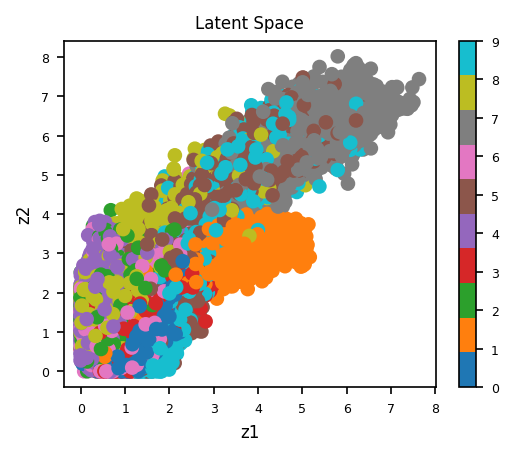

In [10]:
# Plot the latent space
plot_latent(autoencoder, trainloader, num_batches=BATCH_SIZE, path=f'{RESULTS_DIR}ae_latent.png')

In [11]:
# Report the training and validation loss of the autoencoder every ten epochs.
def plot_loss(train_losses, test_losses, label='Loss curve',figsize=(5, 4), path='loss.png'):
    """ Plot test and training loss into the same plot """
    
    plt.figure(figsize=figsize)  # set the figure size
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(label)
    plt.legend()
    plt.savefig(path)
    plt.show()

In [12]:
# 1.4 During the computation of the testing loss plot ten input samples as well as their reconstructions produced by the autoencoder

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    samples = [] 

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, _ = data
            inputs = inputs.to(device)

            # forward pass
            outputs = model(inputs)

            # calculate loss
            loss = criterion(outputs, inputs)
            running_loss += loss.item()

            # store the first image from each batch
            inputs = inputs[0].view(1, 1, 28, 28)
            outputs = outputs[0].view(1, 1, 28, 28)
            inputs = to_img(inputs)
            outputs = to_img(outputs)
            samples.append((inputs.cpu(), outputs.cpu()))

            # every 10 batches plot input samples + reconstructions
            if (i+1) % 10 == 0:
                # plot samples
                plot_samples(samples, path=f'{RESULTS_DIR}ae_ten_samples_{i}.png')
                samples = []

    return running_loss / len(test_loader)

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


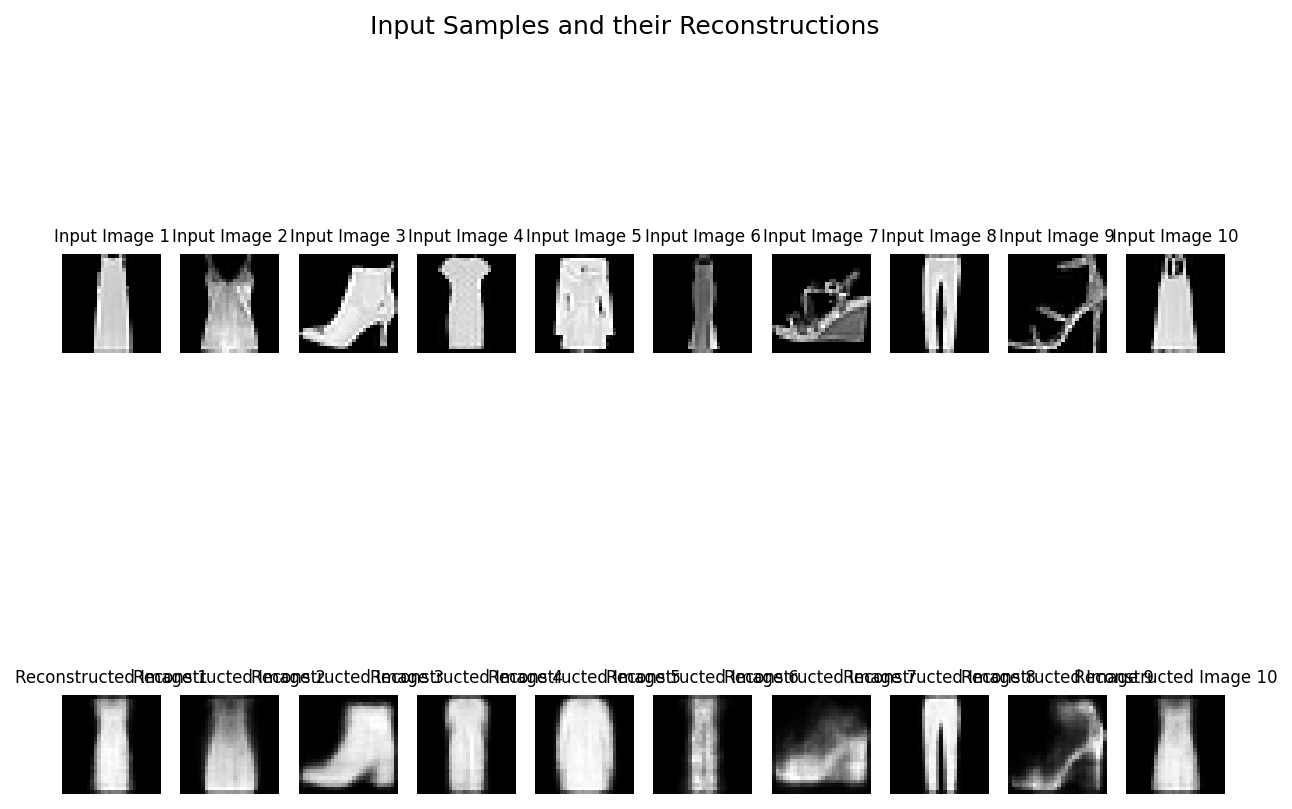

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


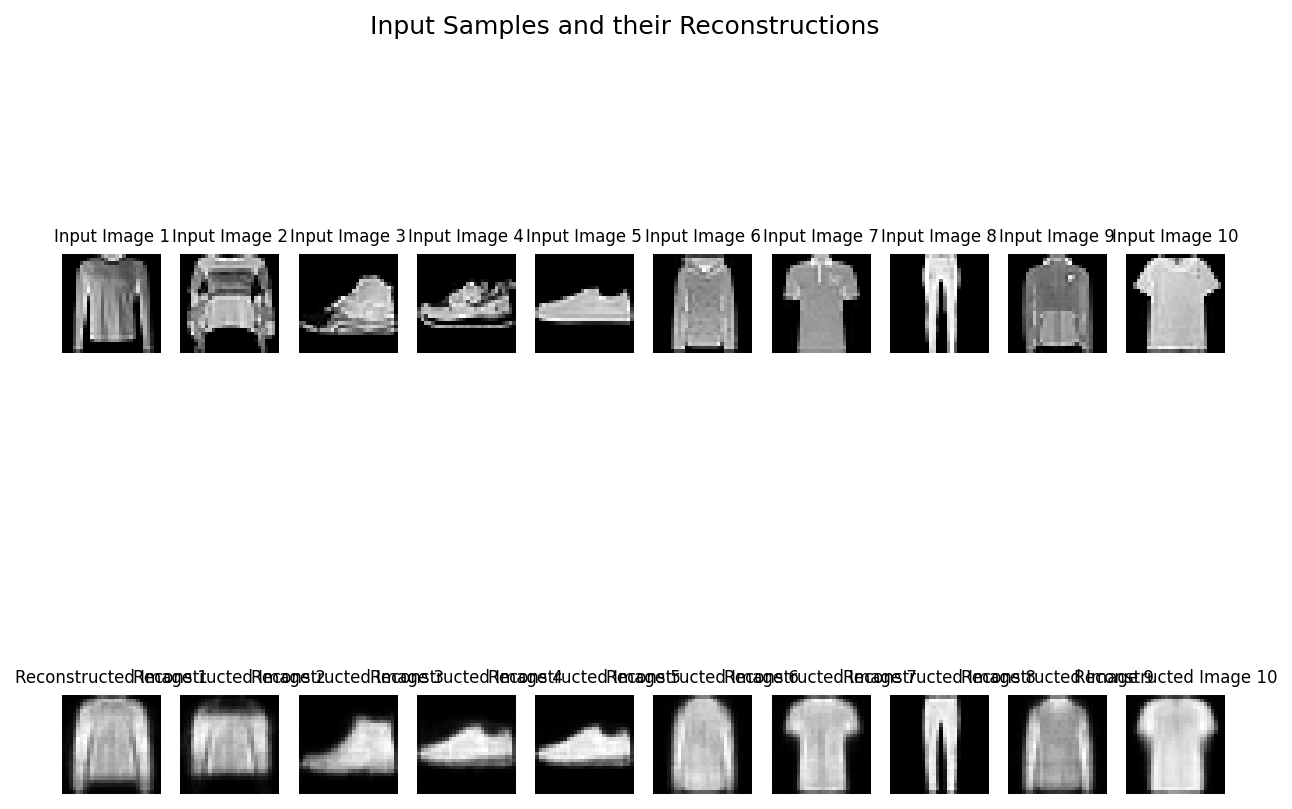

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


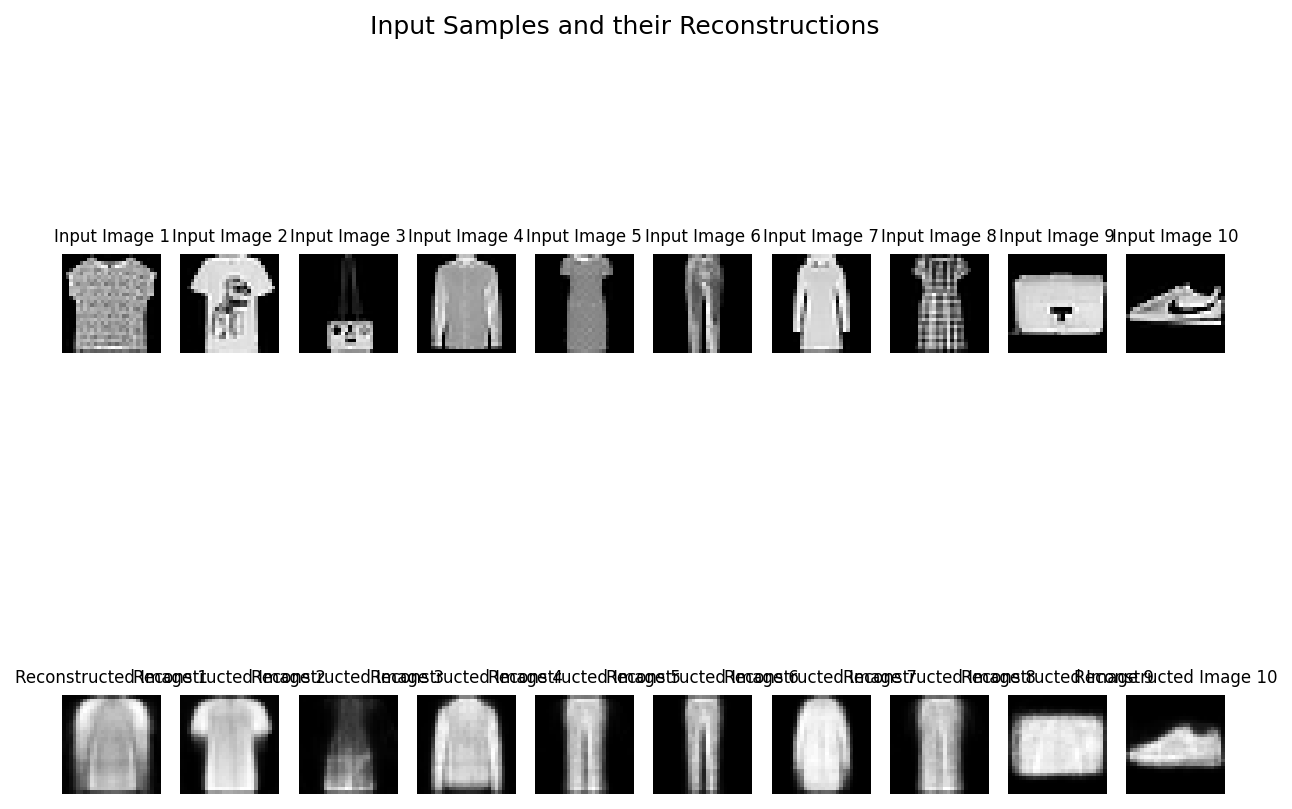

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


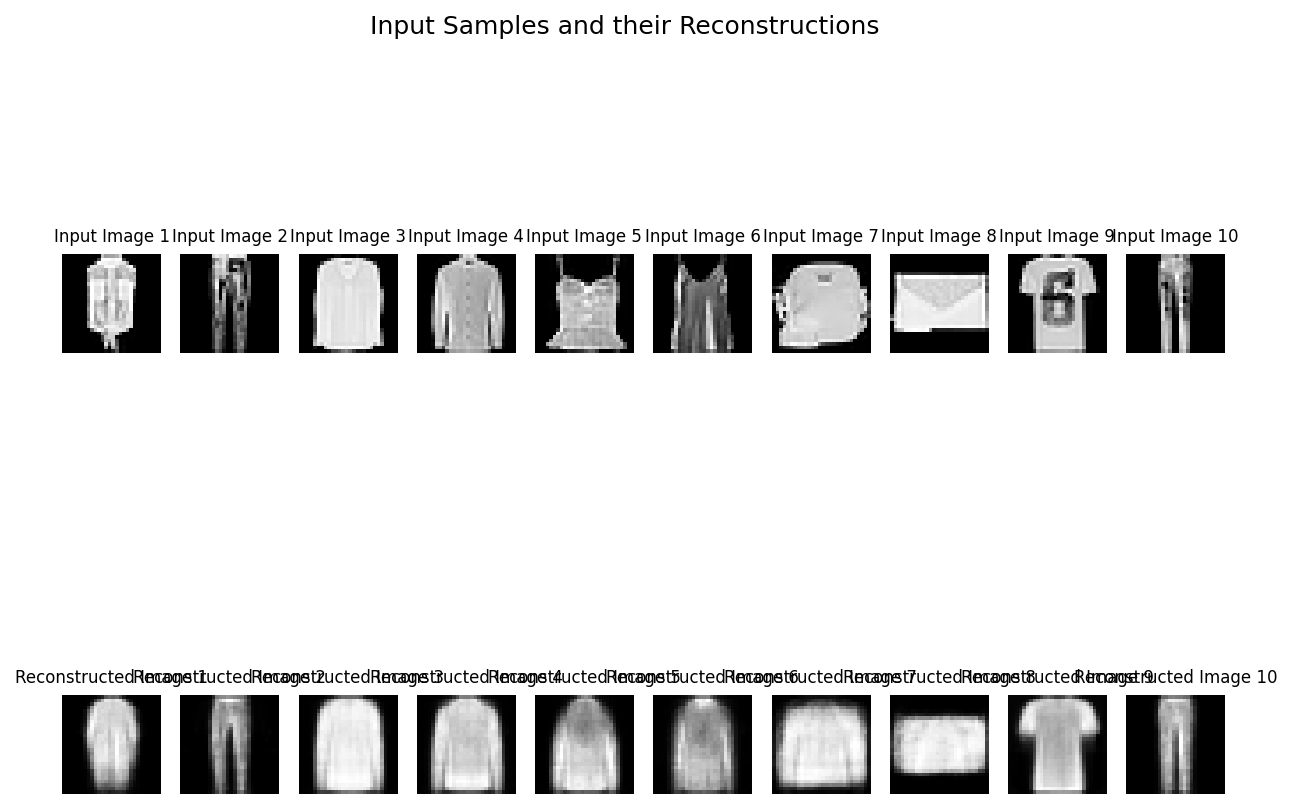

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


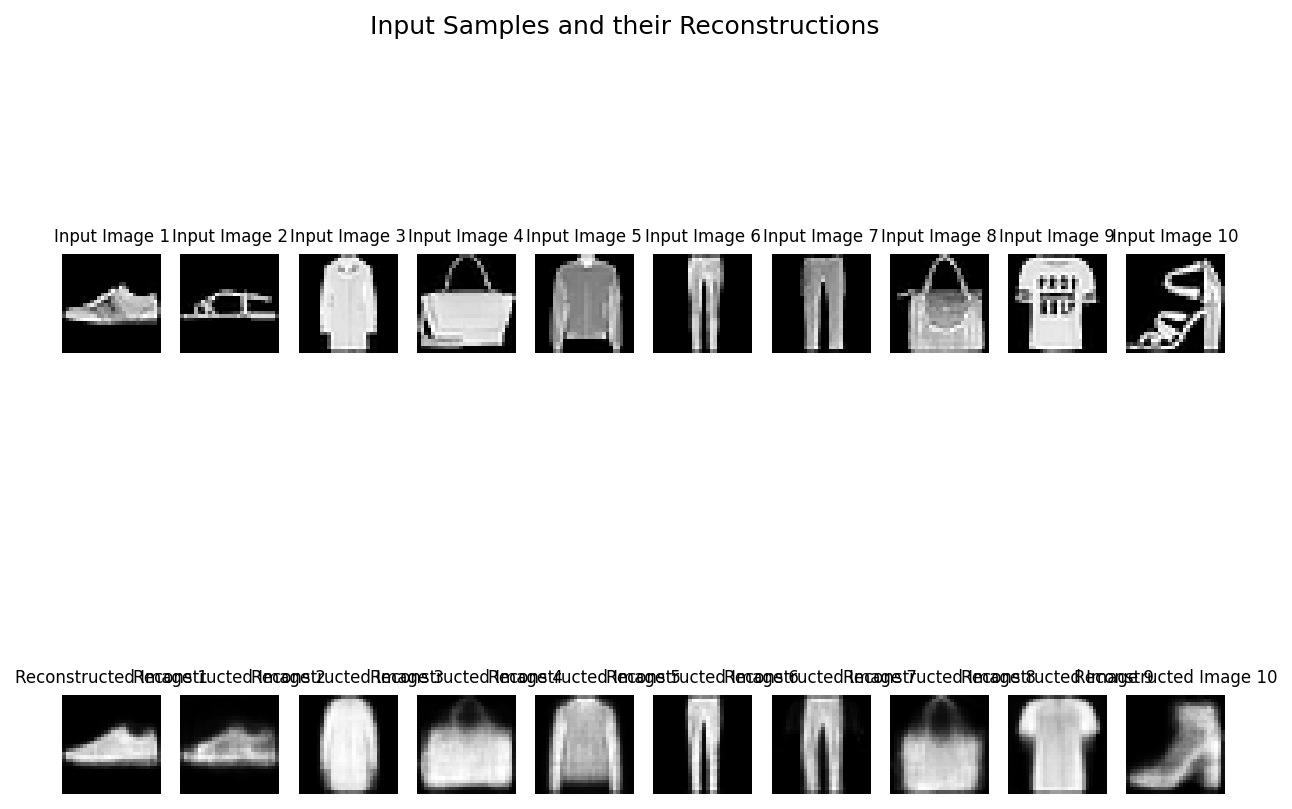

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


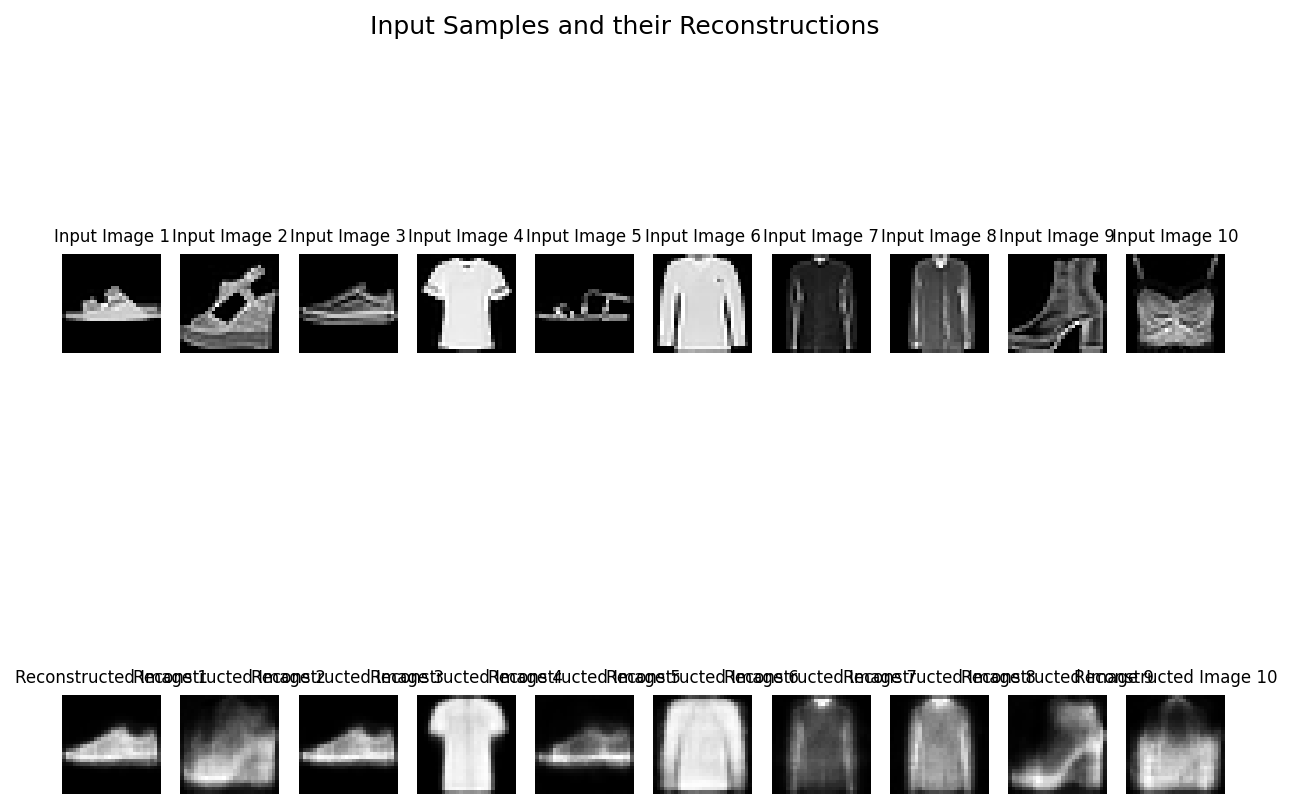

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


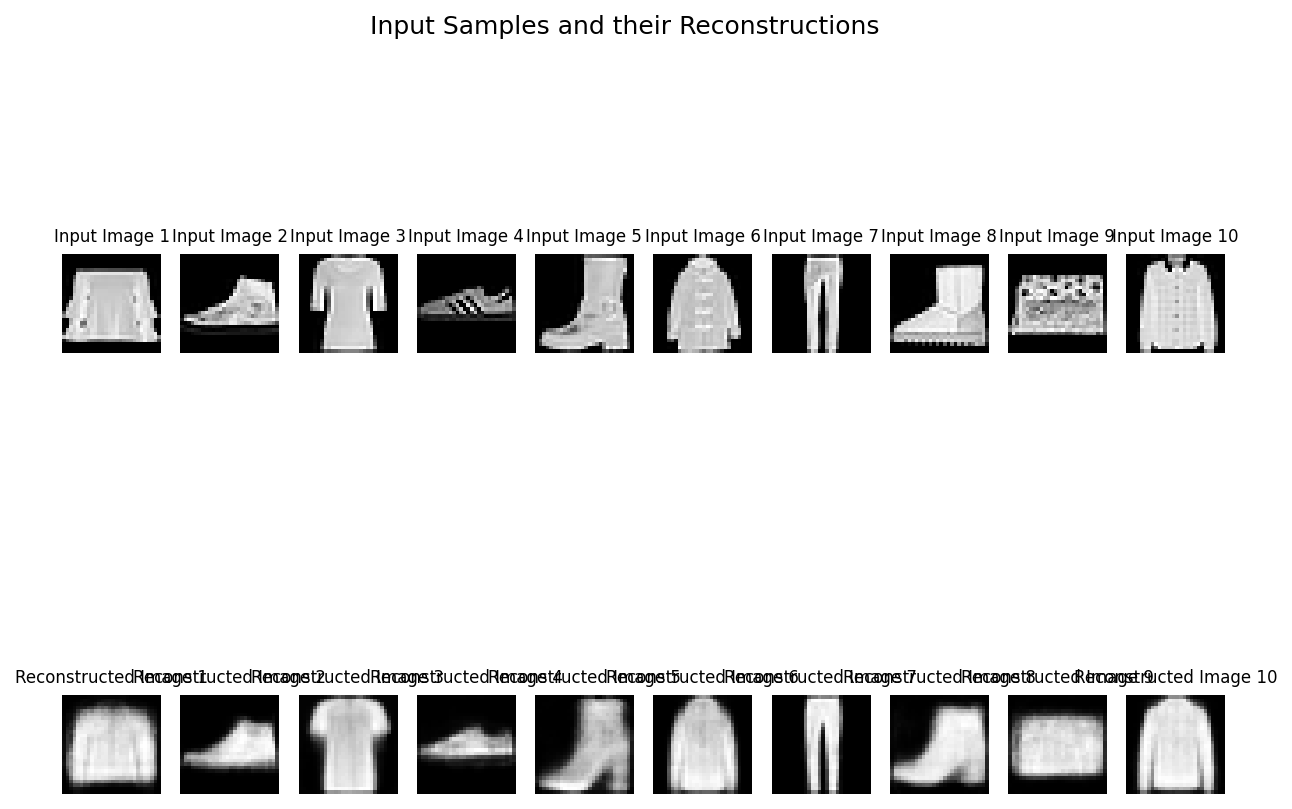

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Epoch 1/3, Loss: 0.0941
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 2

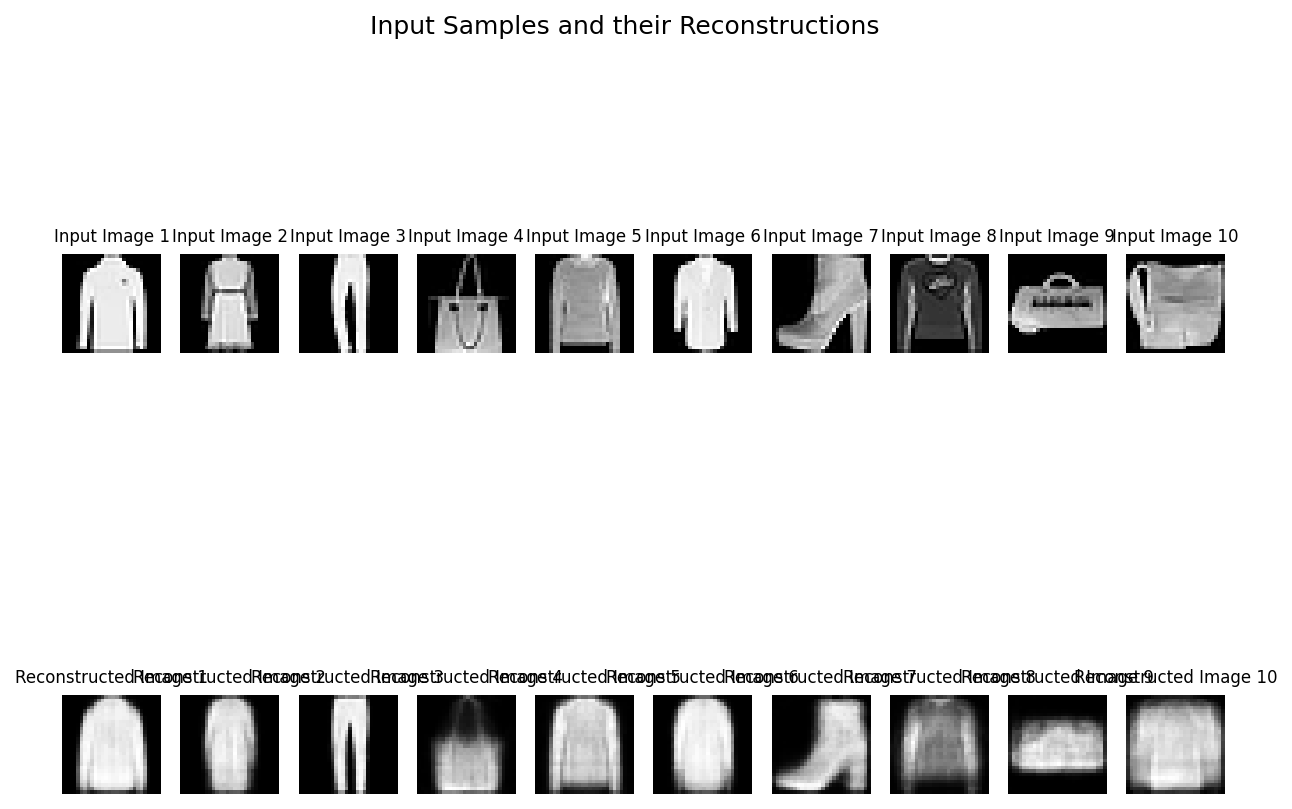

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


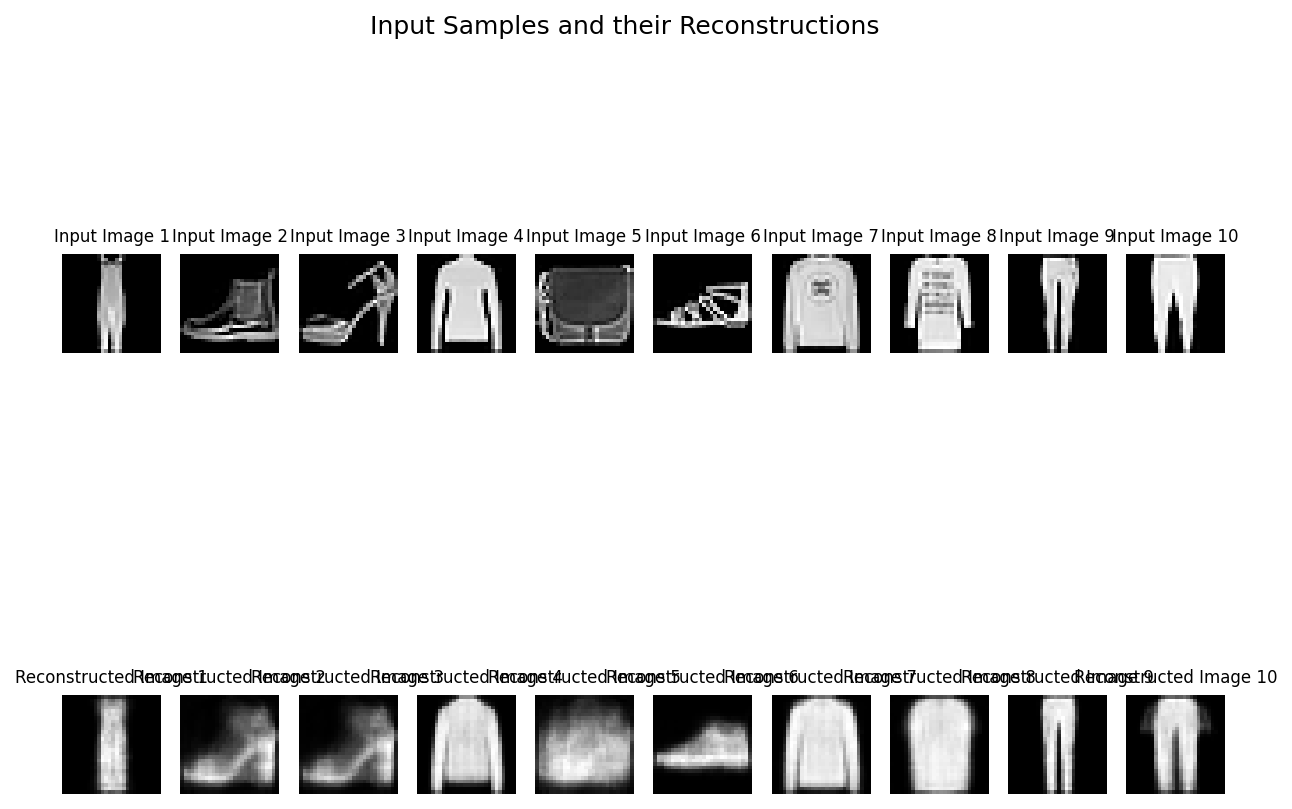

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


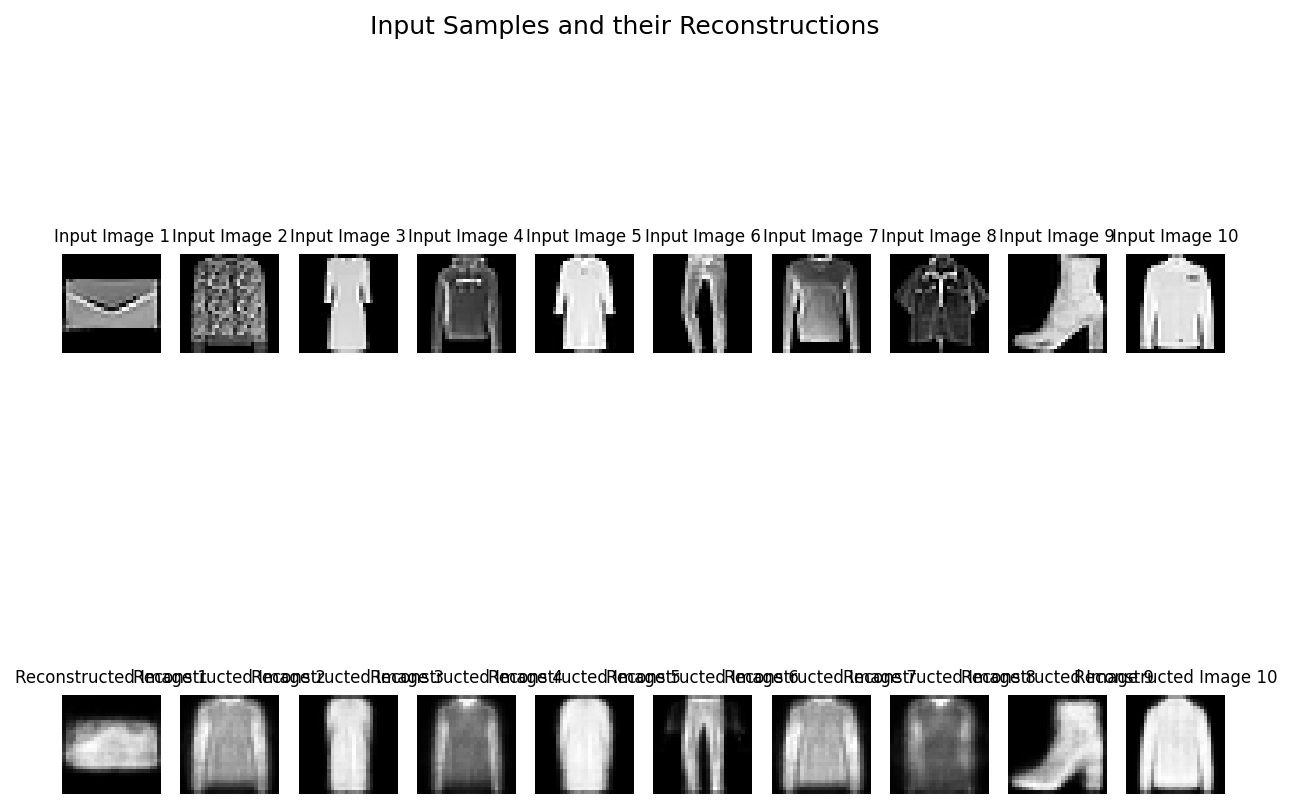

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


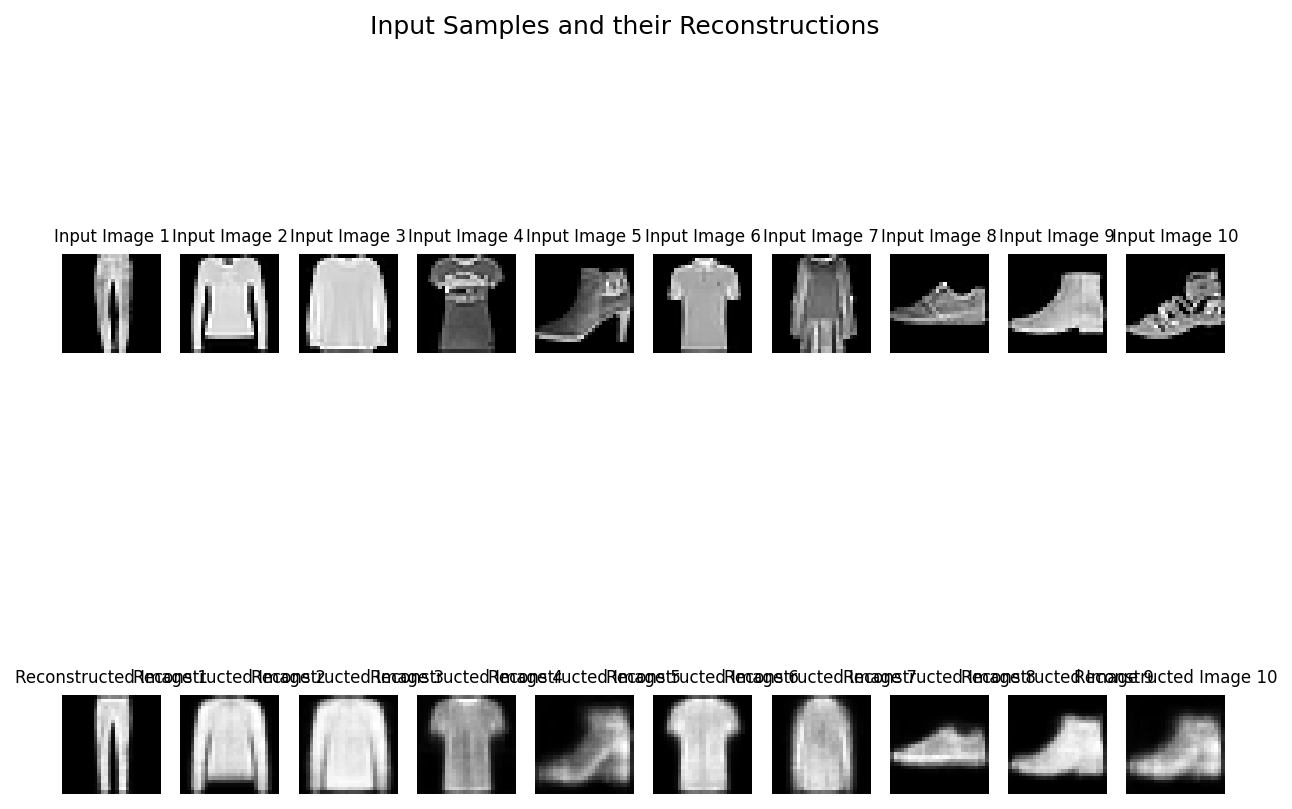

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


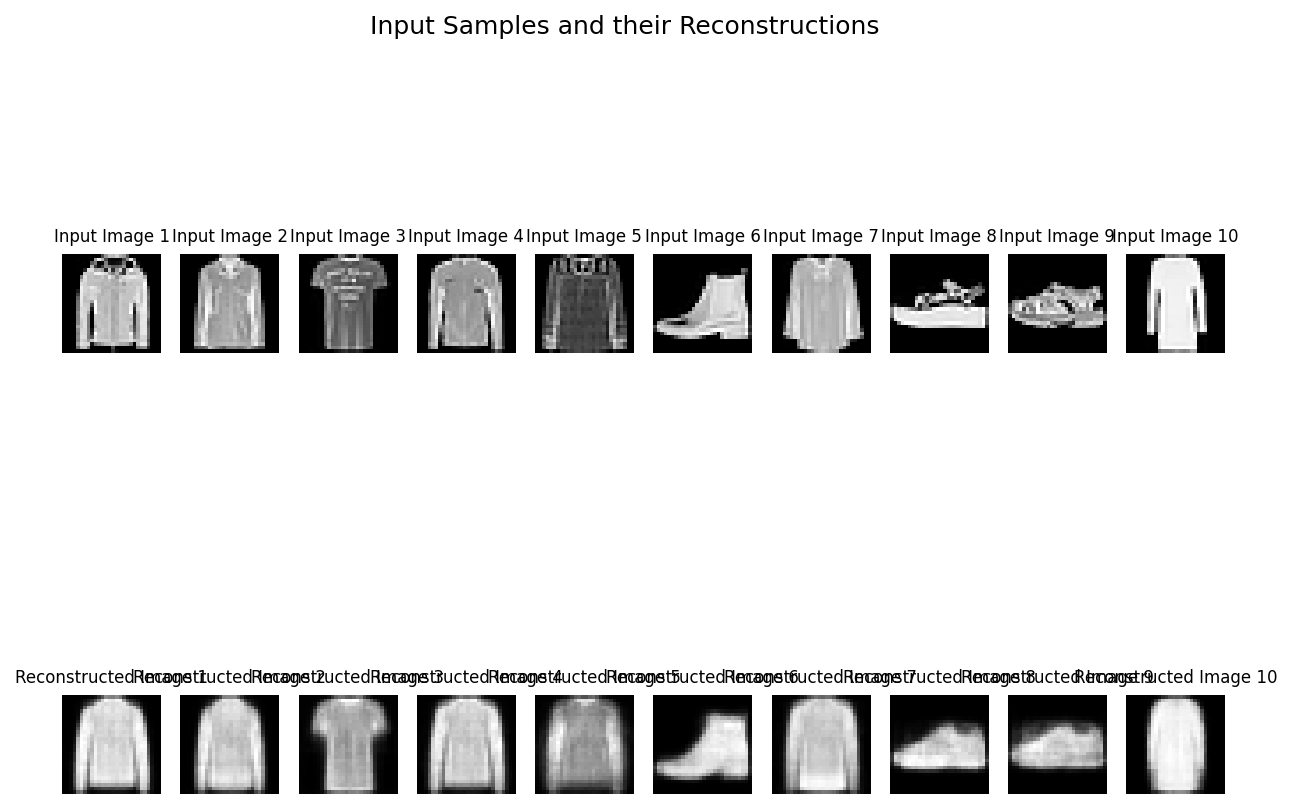

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


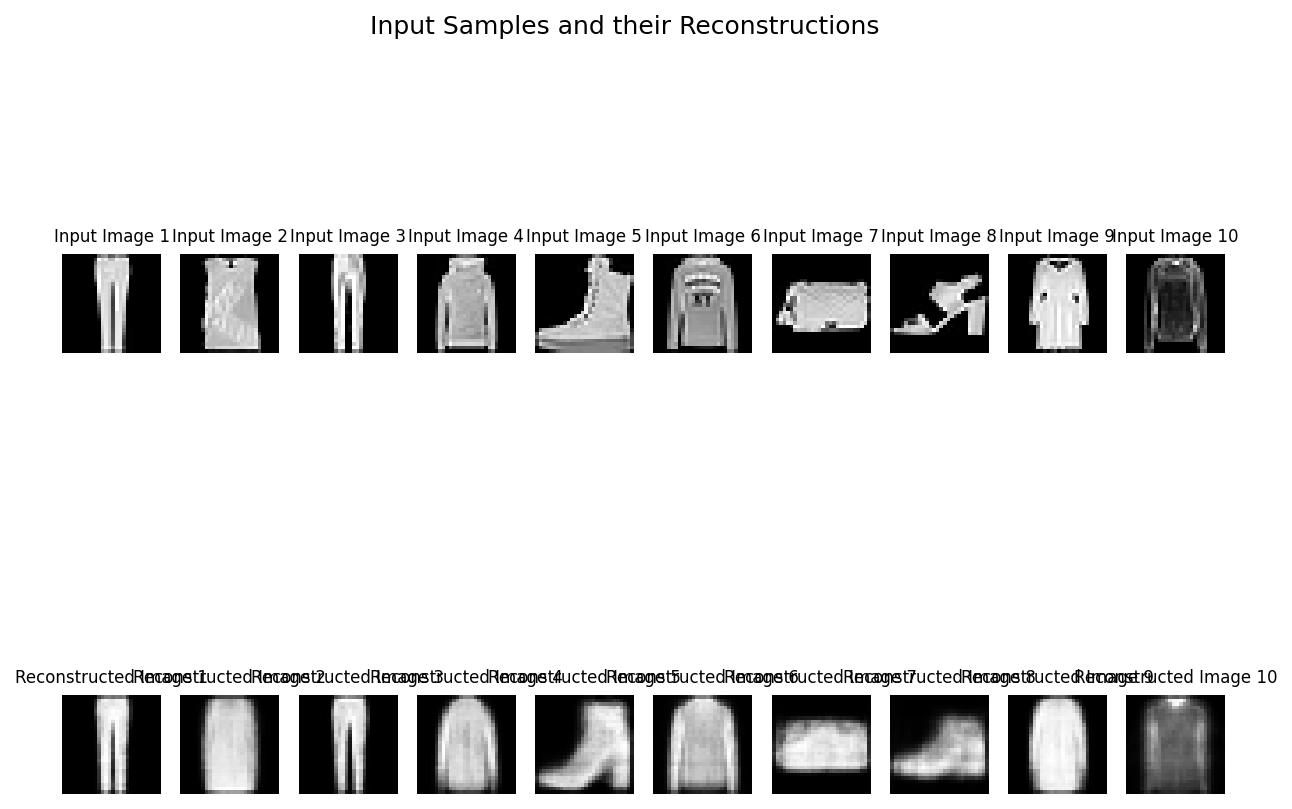

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


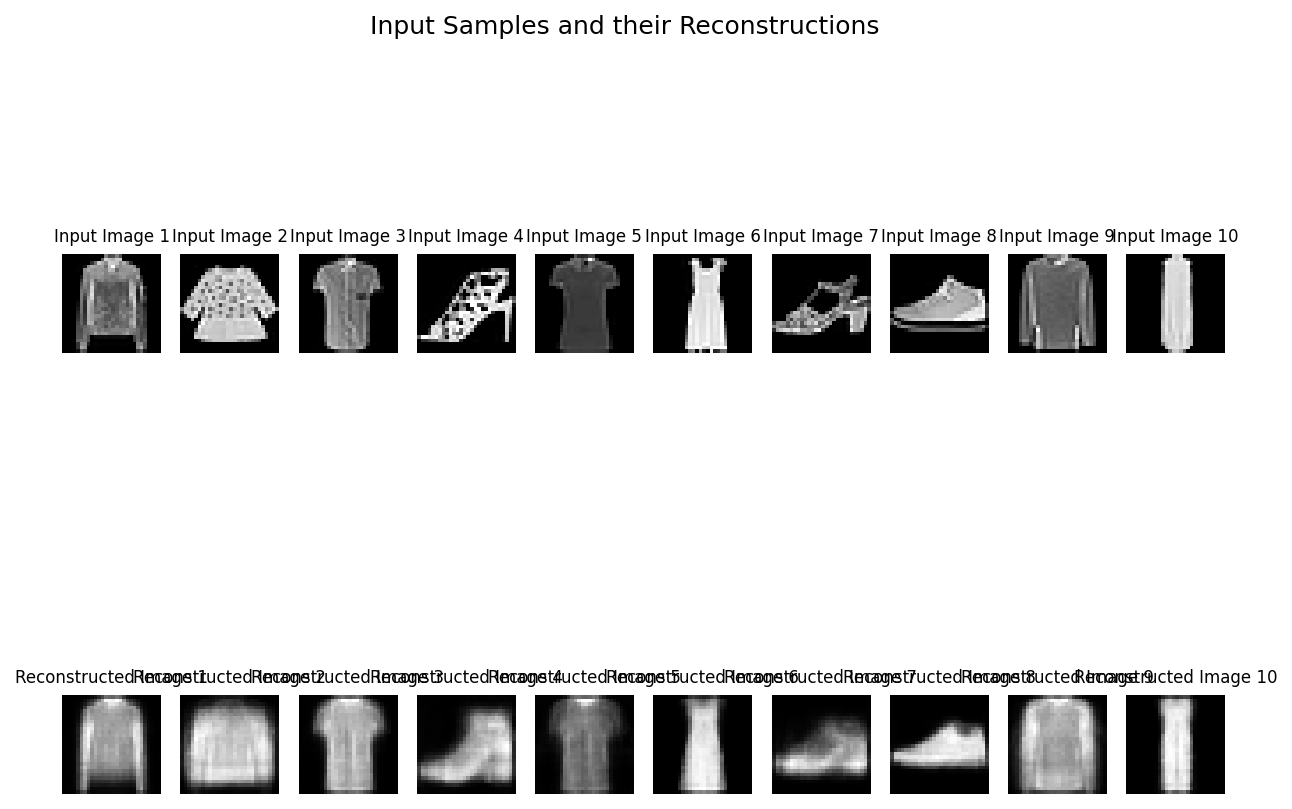

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Epoch 2/3, Loss: 0.0945
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 2

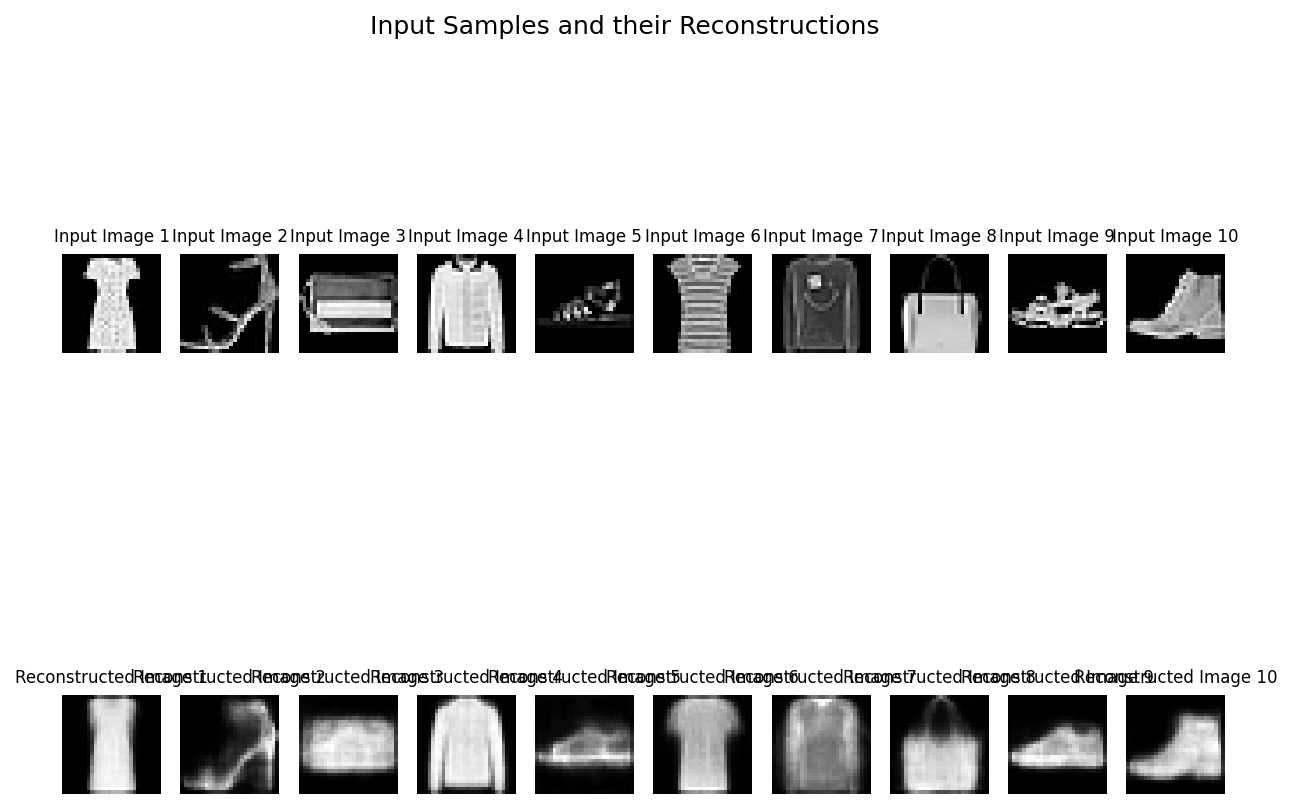

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


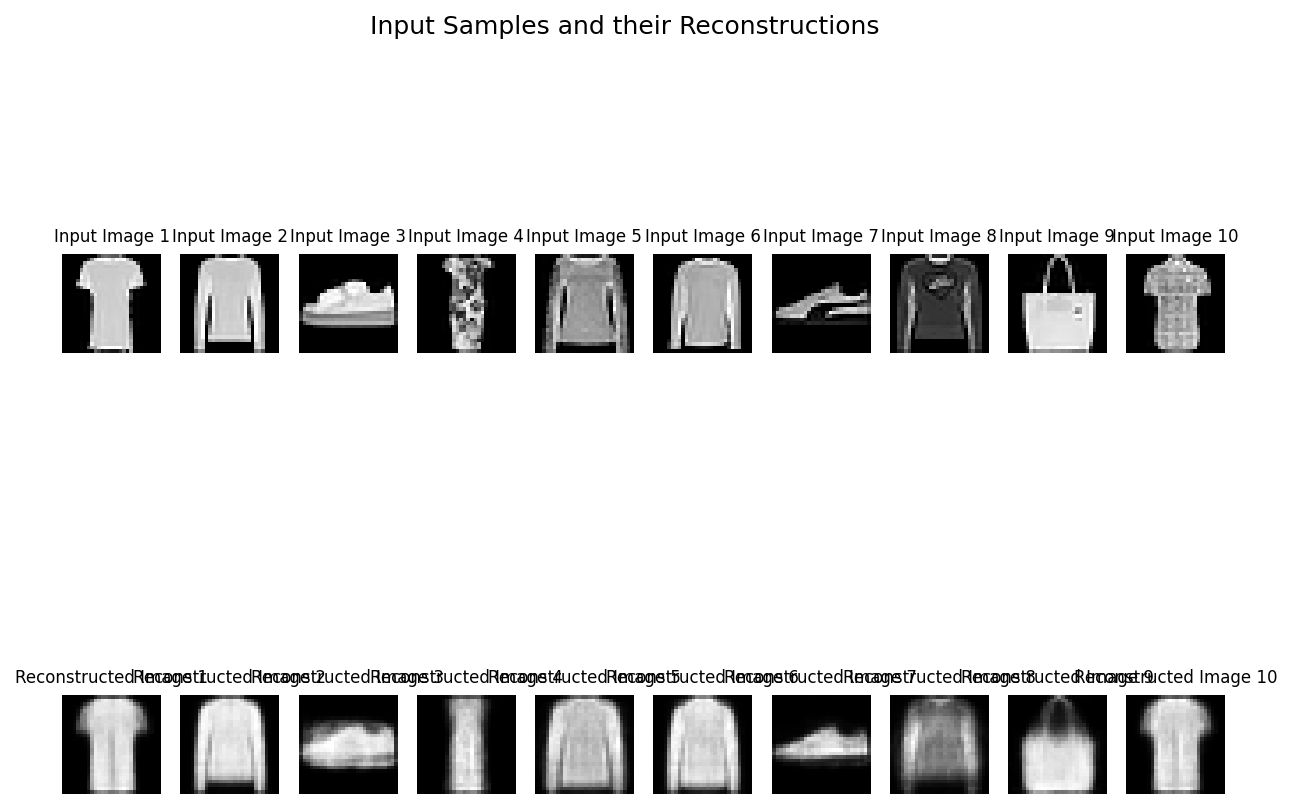

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


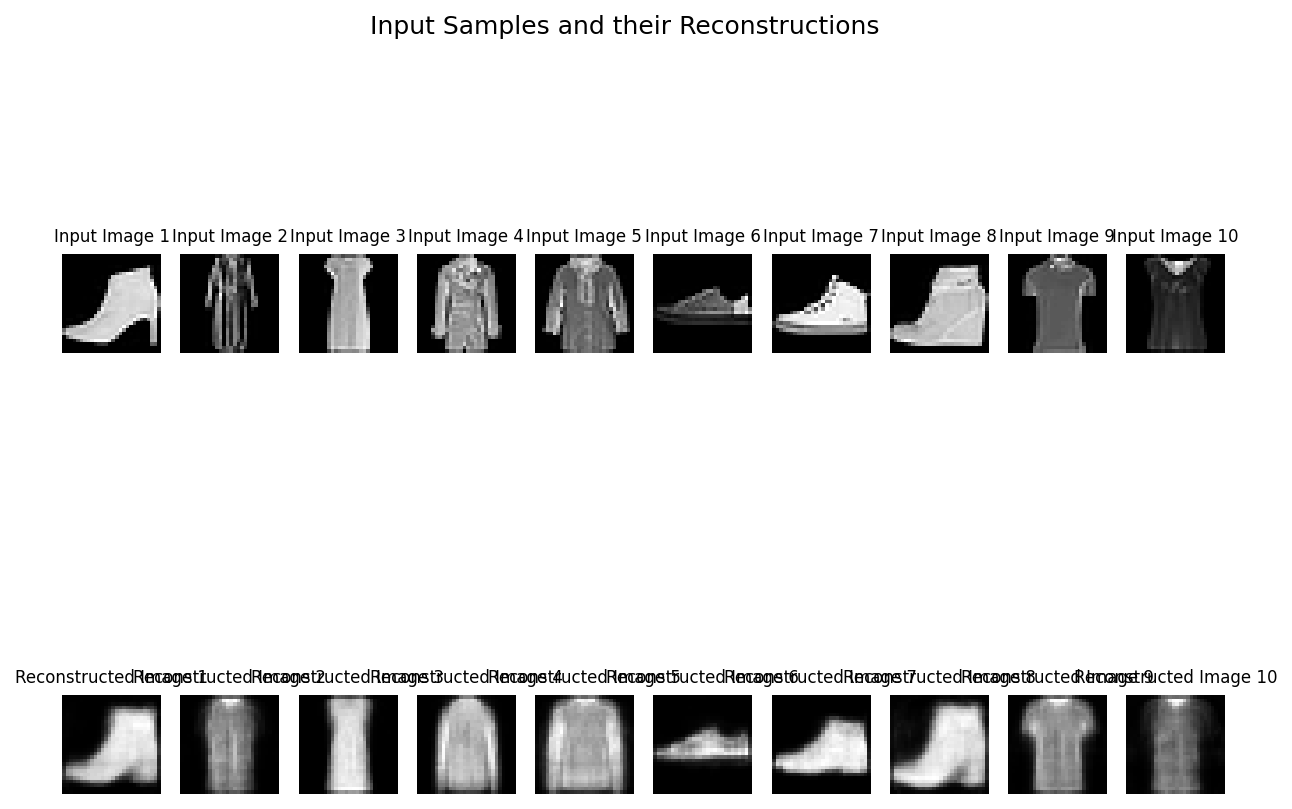

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


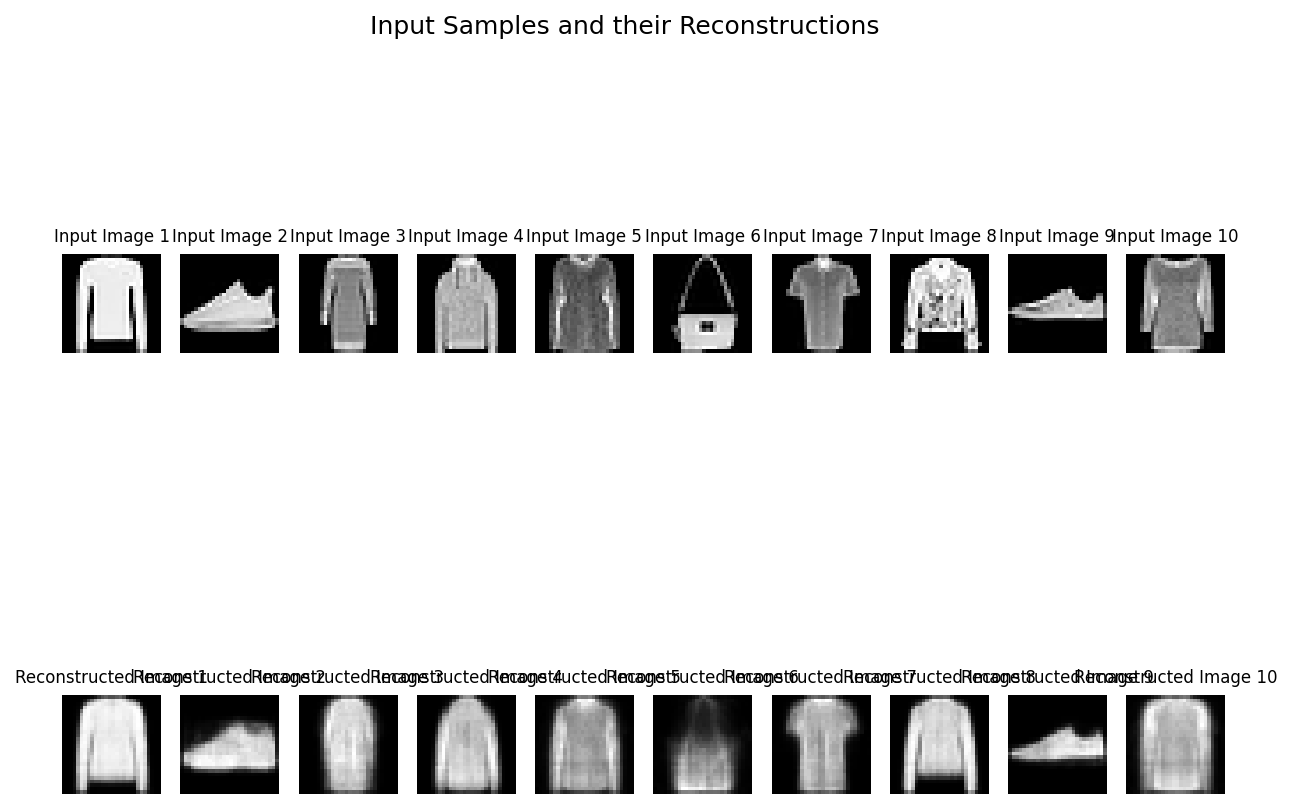

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


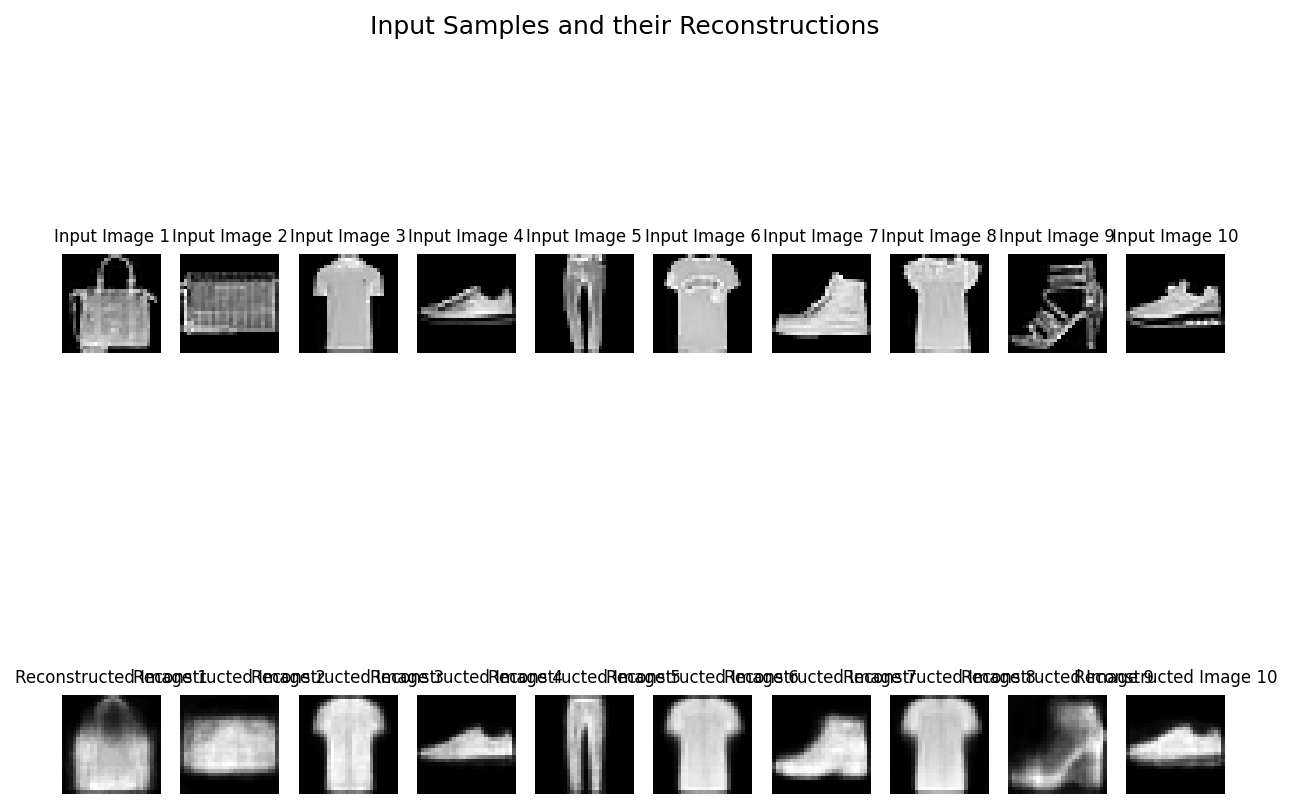

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


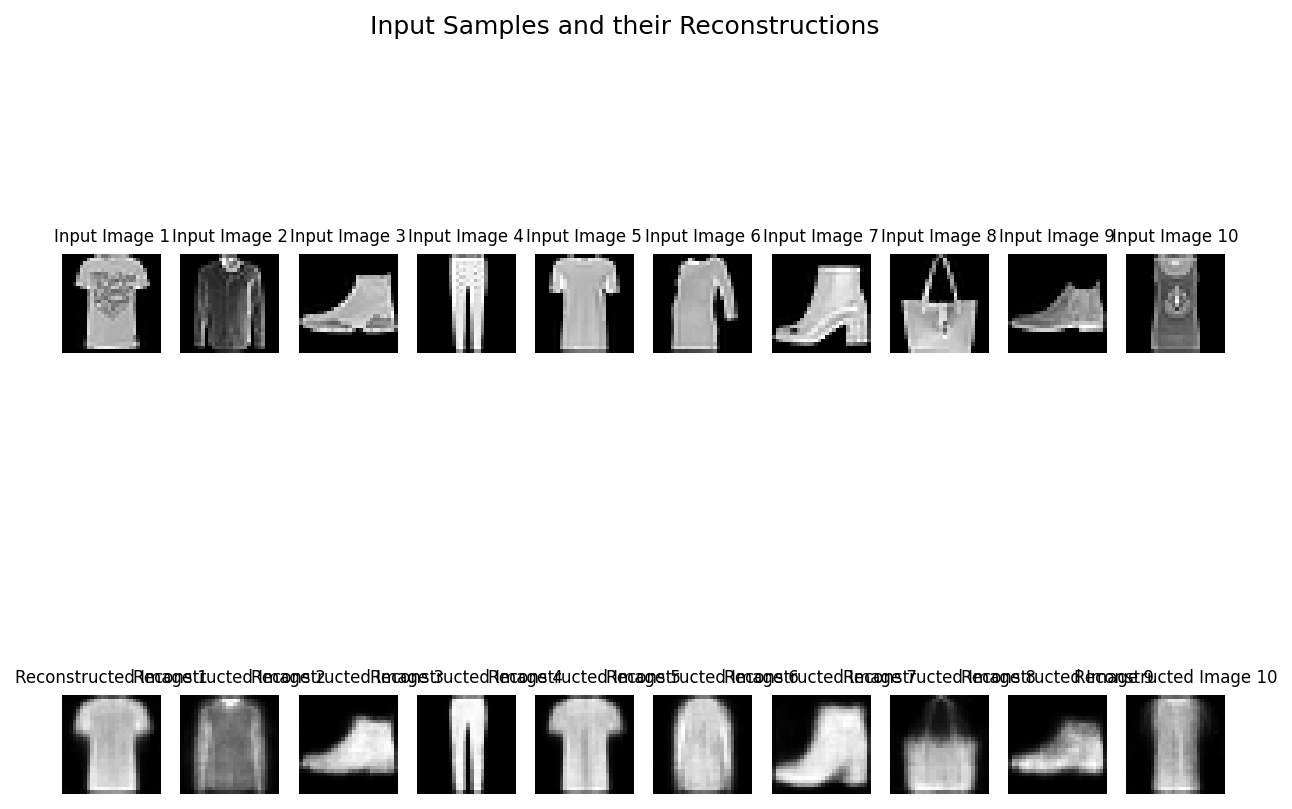

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


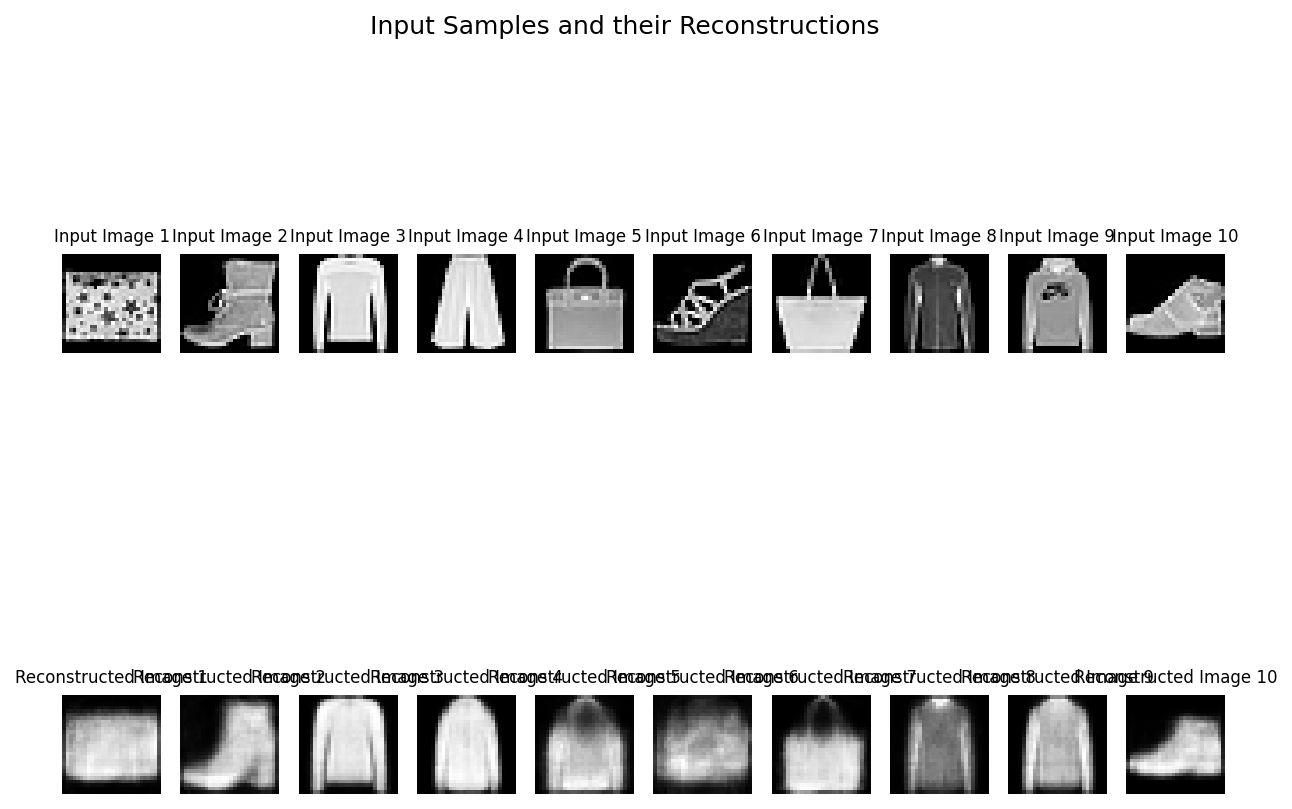

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Epoch 3/3, Loss: 0.0941


In [13]:
# test the model
for epoch in range(EPOCHS):
    test_loss = test(autoencoder, testloader, criterion, device=device)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {test_loss:.4f}')

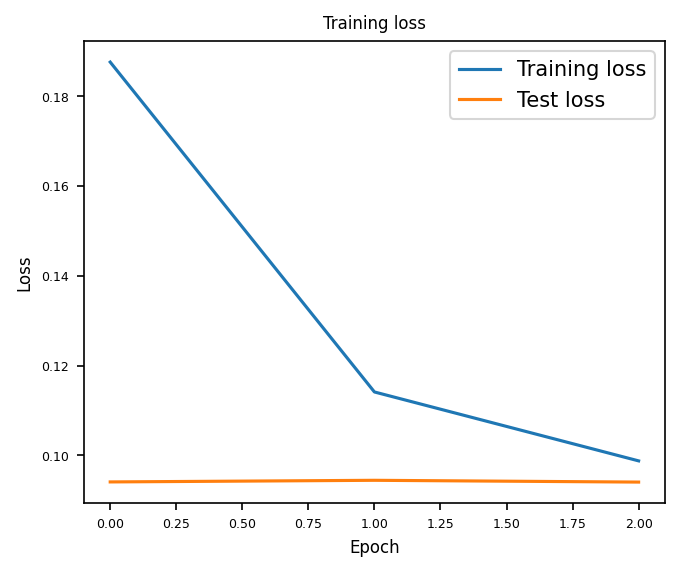

In [14]:
plot_loss(train_losses, test_losses, label='Training loss', path=RESULTS_DIR+'ae_loss_curve.png')

### Task 2: Denoising Autoencoders

2.1 Use your code for the previous task. The model stays the same. But instead of the original input apply your network to the noised input (see function add noise in network.py)

In [15]:
# Note that you should still count loss between not noised image and your prediction.
# Compute the testing loss
autoencoder = Autoencoder().to(device)
train_losses = []
test_losses = []

# train the model
for epoch in range(EPOCHS):
    start = time.time()
    train_loss = train(autoencoder, trainloader, optimizer, criterion, noise=True, noise_factor=0.3, noise_stddev=1, device=device)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}, Time: {time.time()-start:.2f} sec')


Epoch 1/3, Loss: 0.6823, Time: 4.73 sec
Epoch 2/3, Loss: 0.6823, Time: 4.48 sec
Epoch 3/3, Loss: 0.6823, Time: 4.62 sec


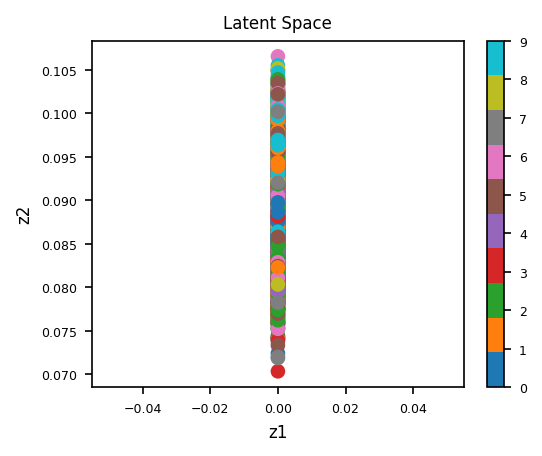

In [16]:
# Plot the latent space
plot_latent(autoencoder, trainloader, num_batches=BATCH_SIZE, path=f'{RESULTS_DIR}ae_latent_with_noise.png')

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


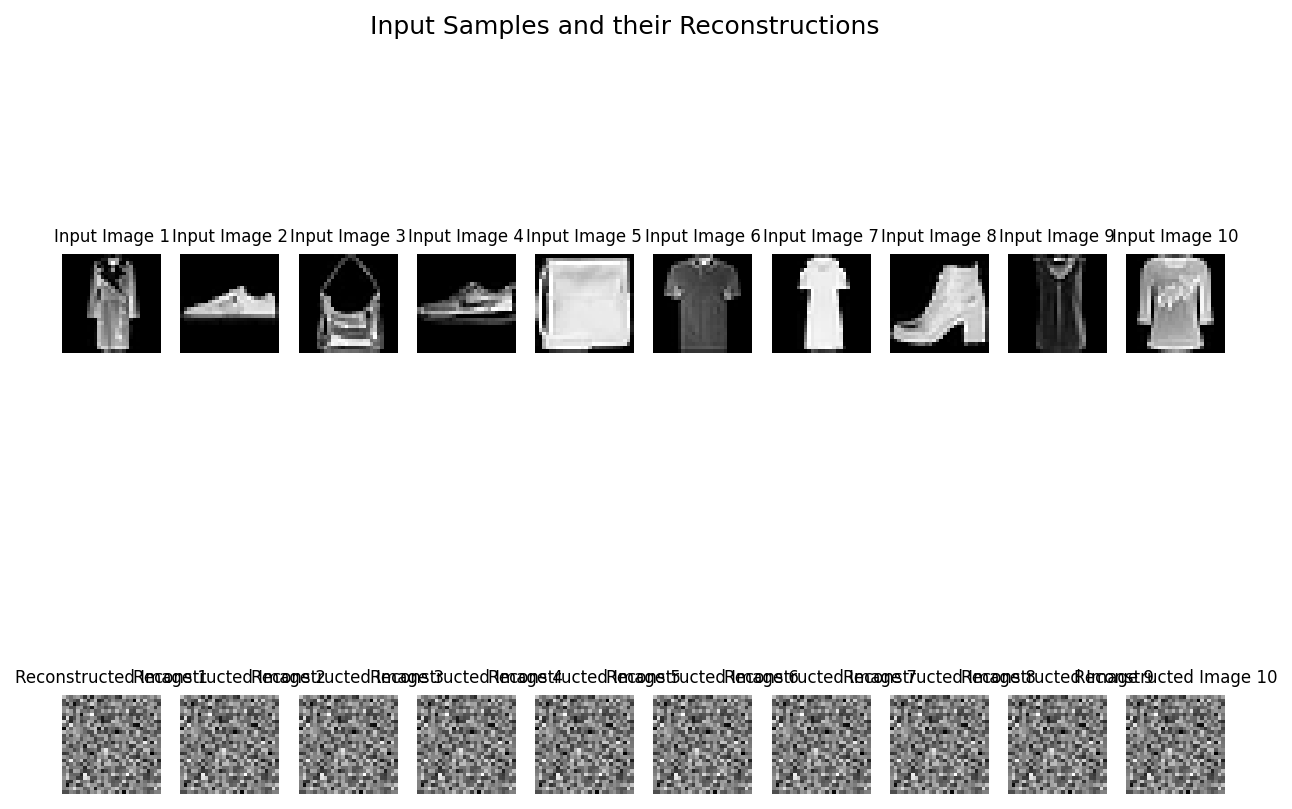

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


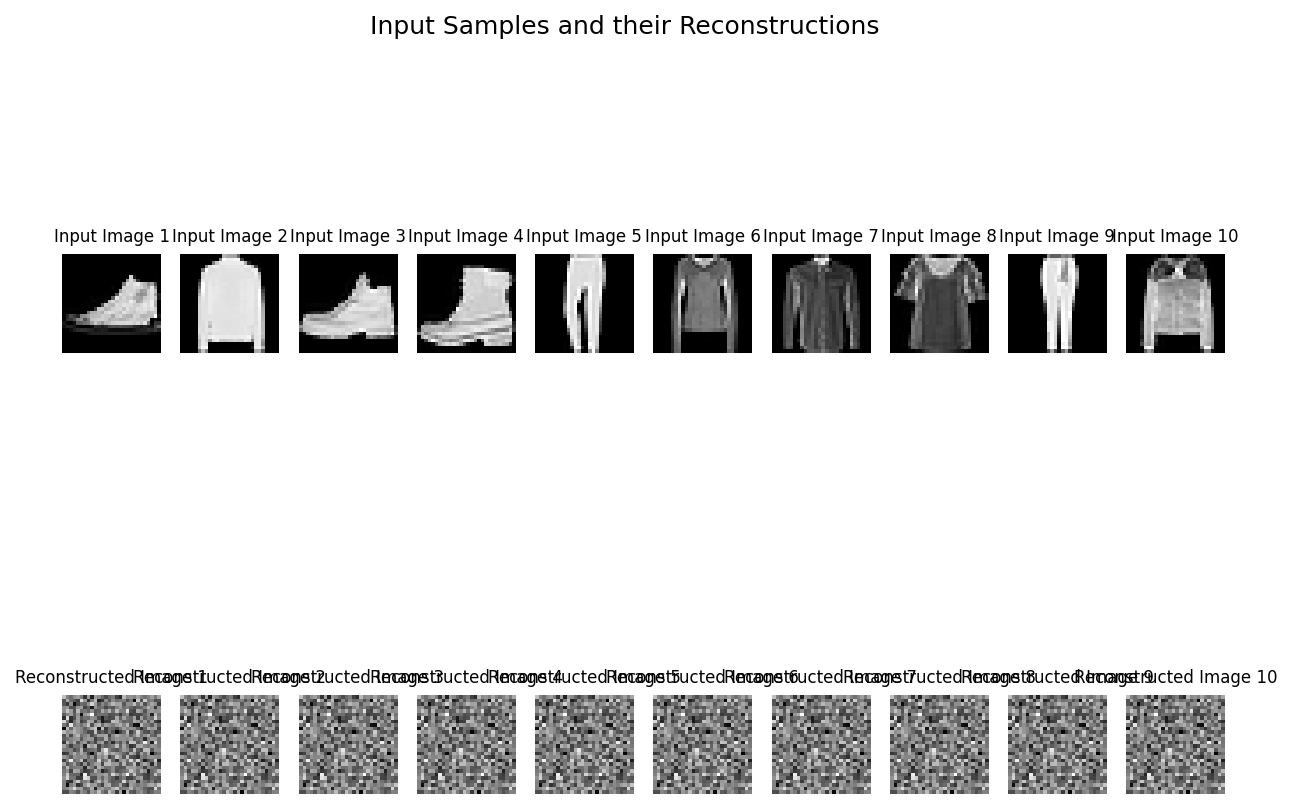

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


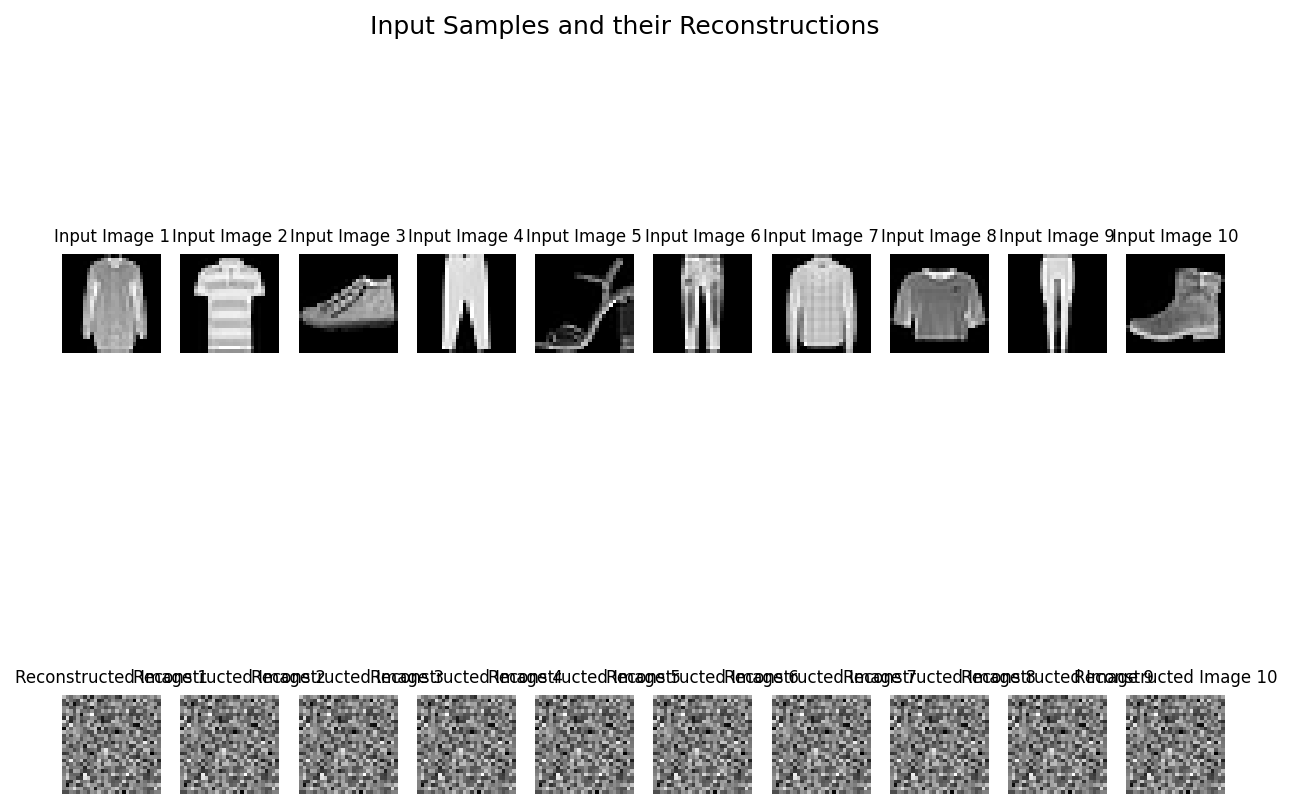

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


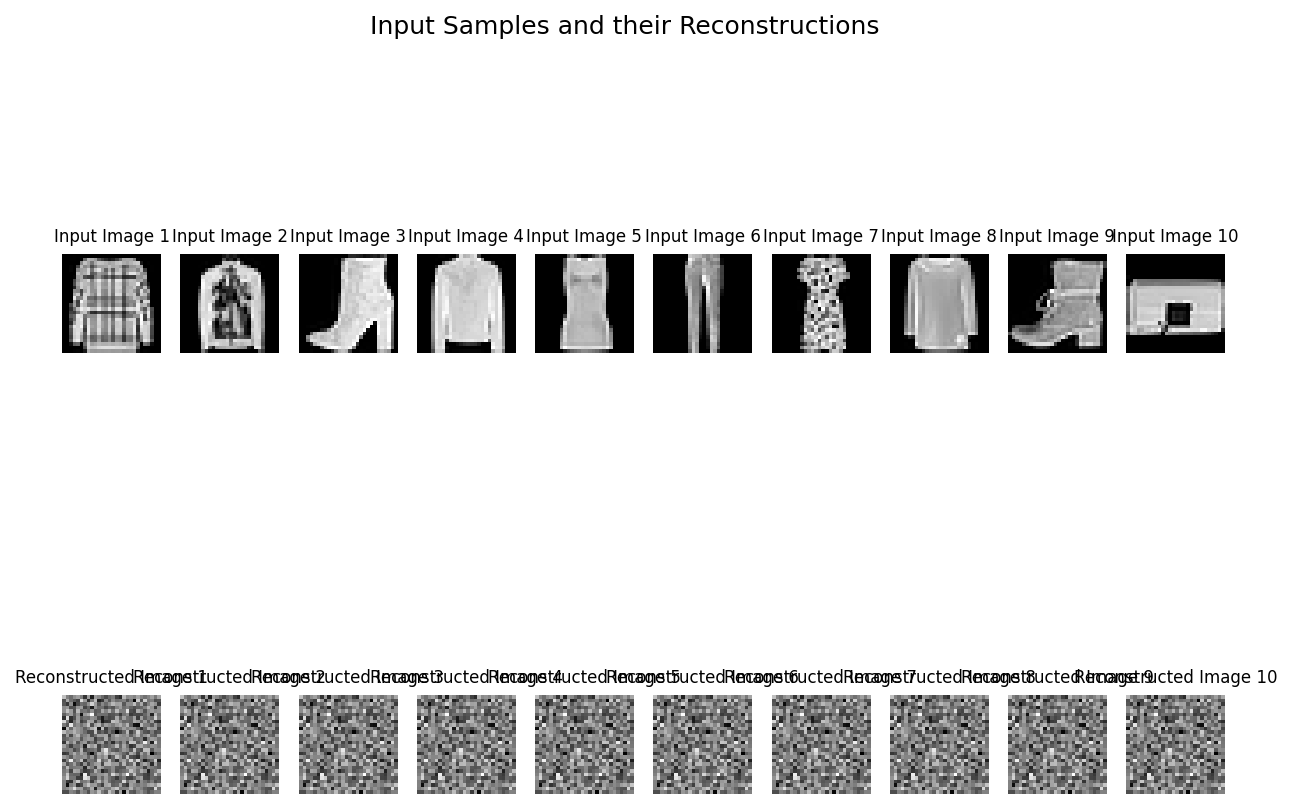

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


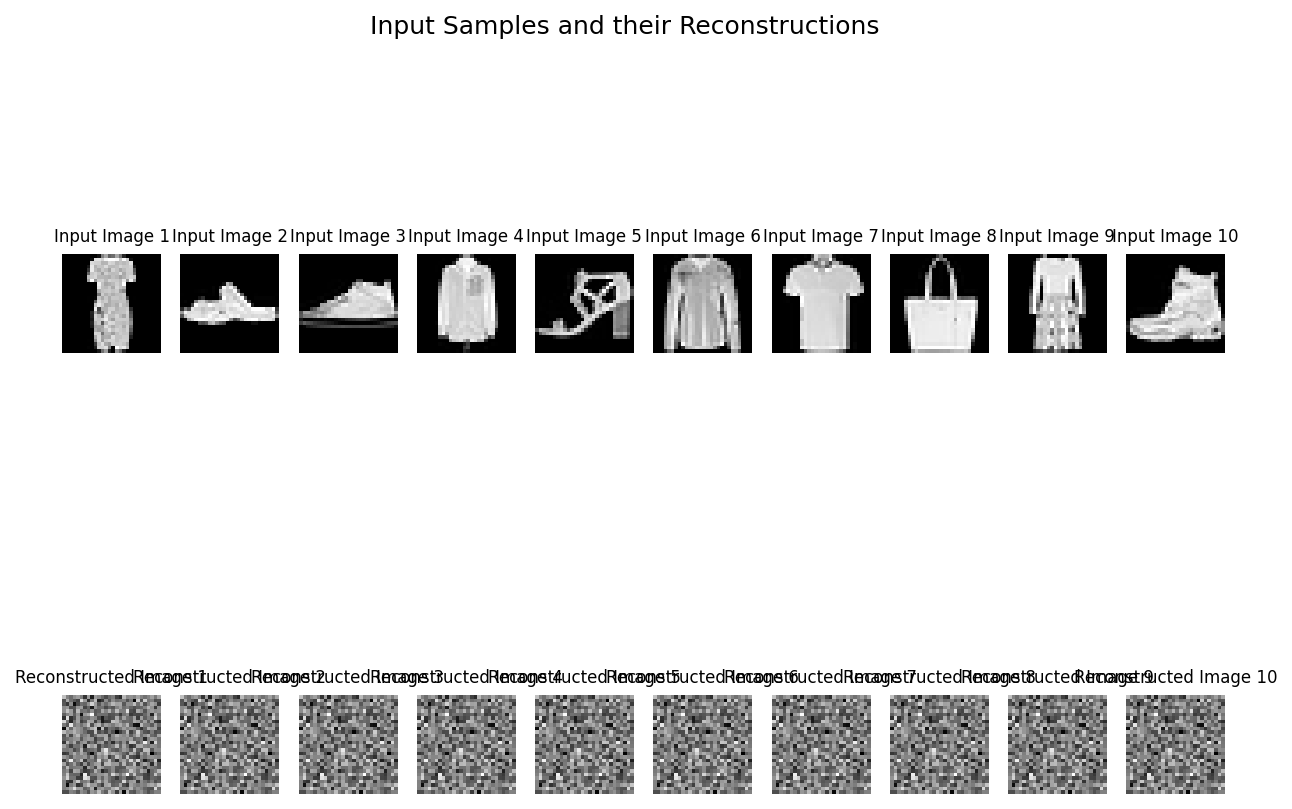

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


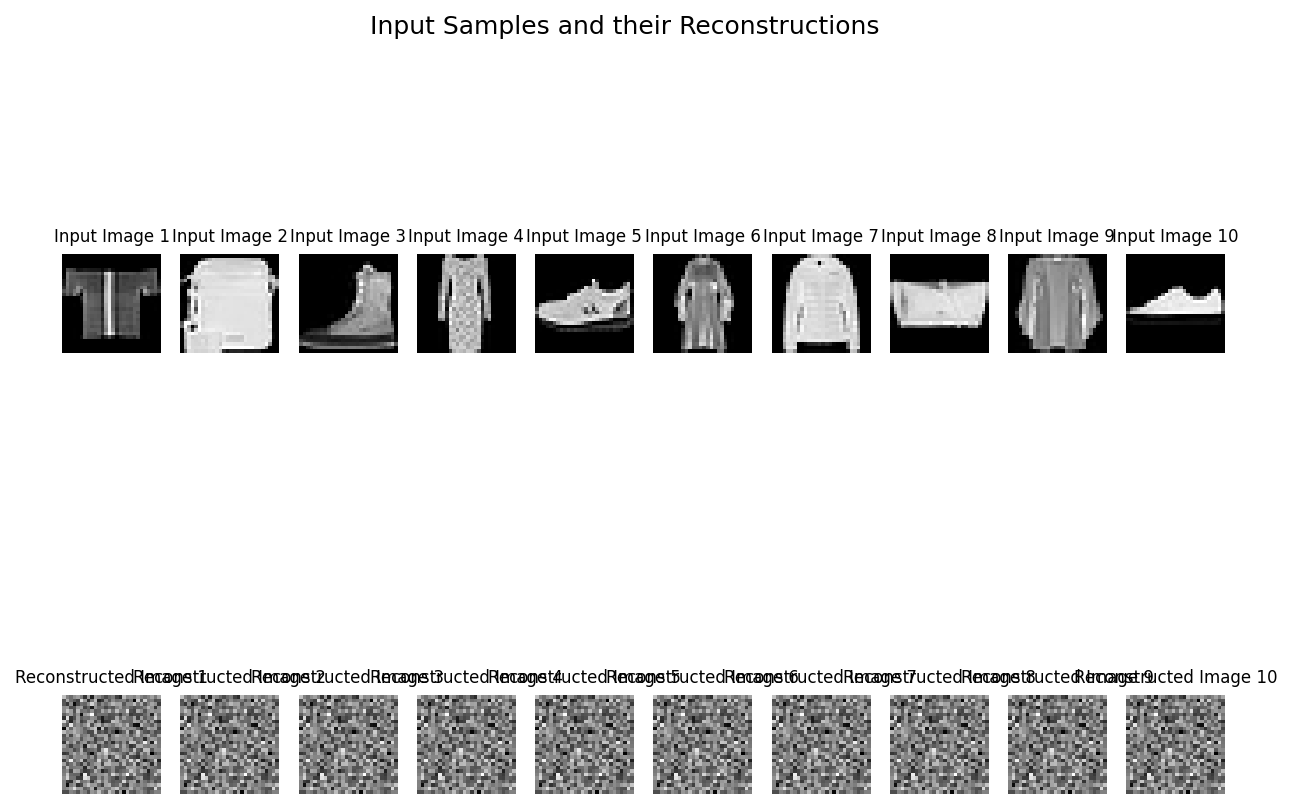

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


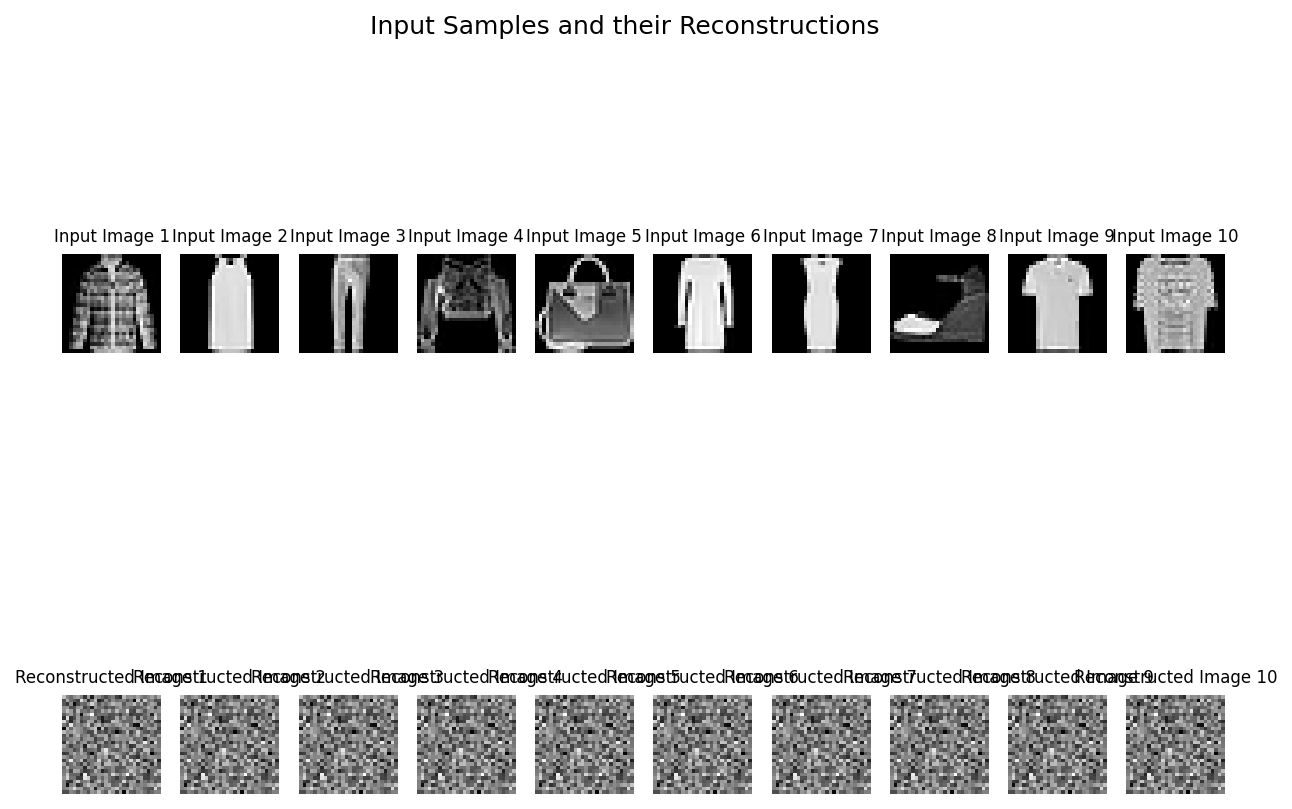

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Epoch 1/3, Loss: 0.6796
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 2

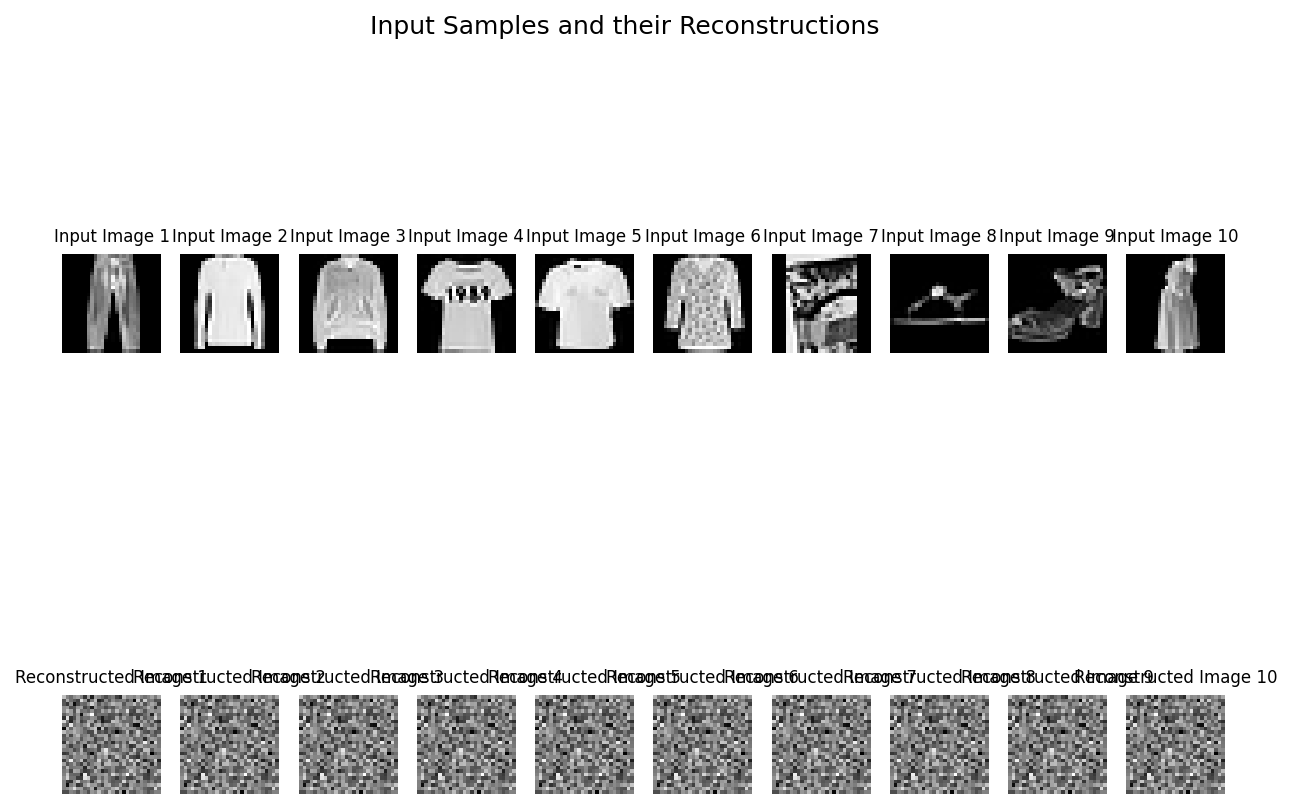

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


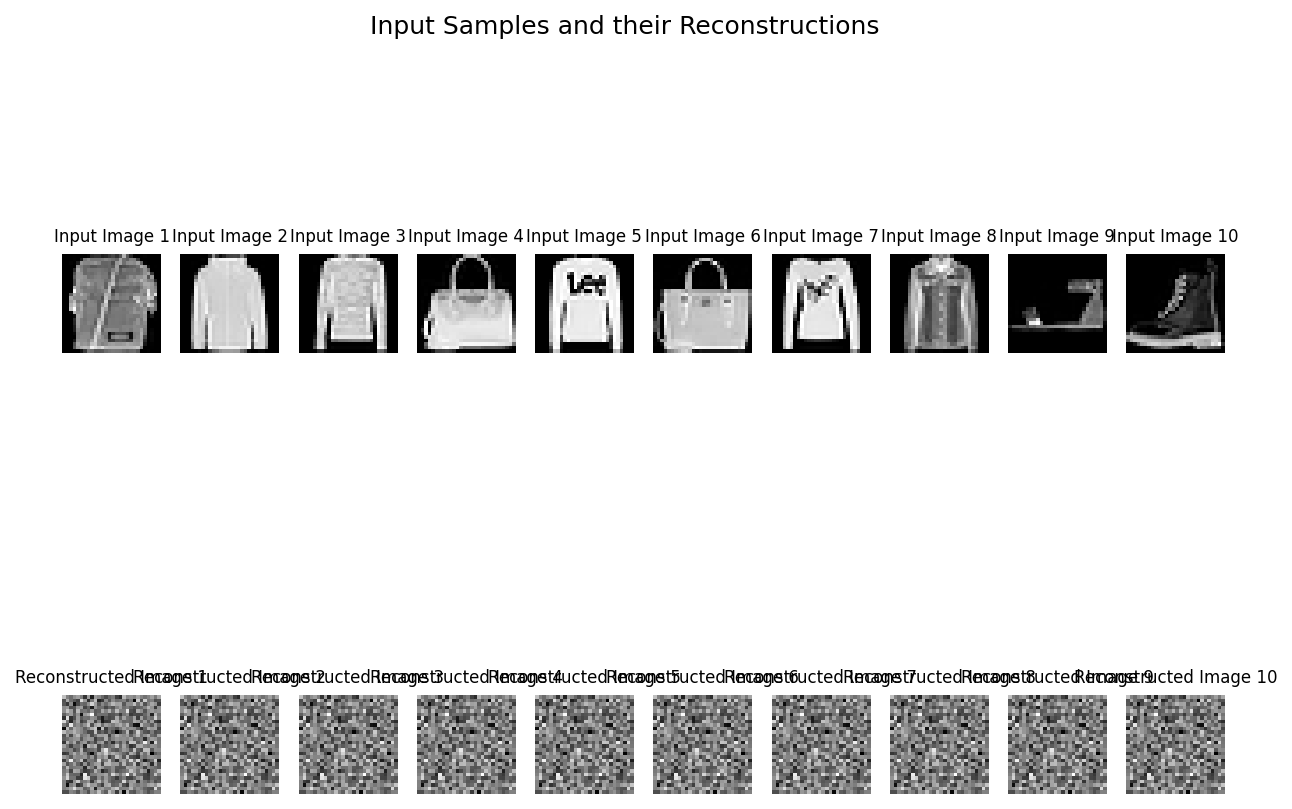

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


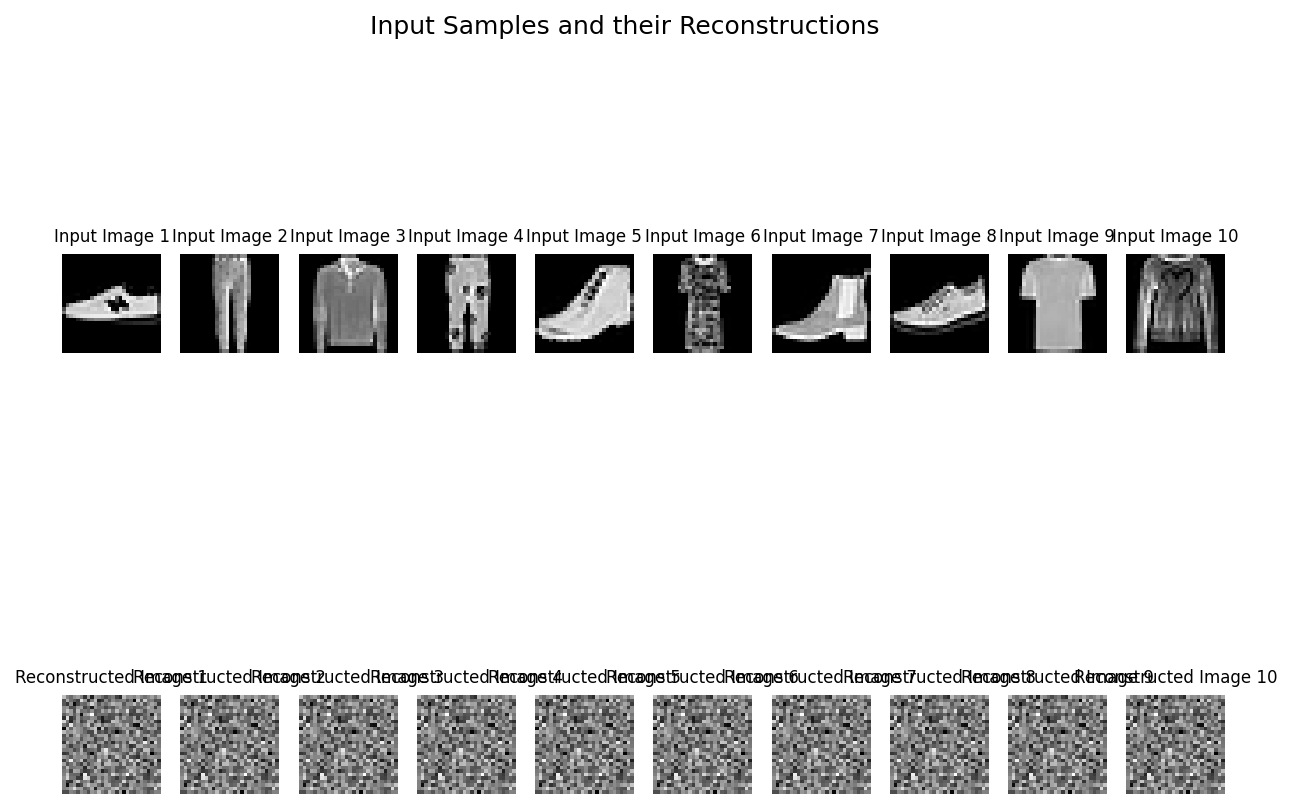

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


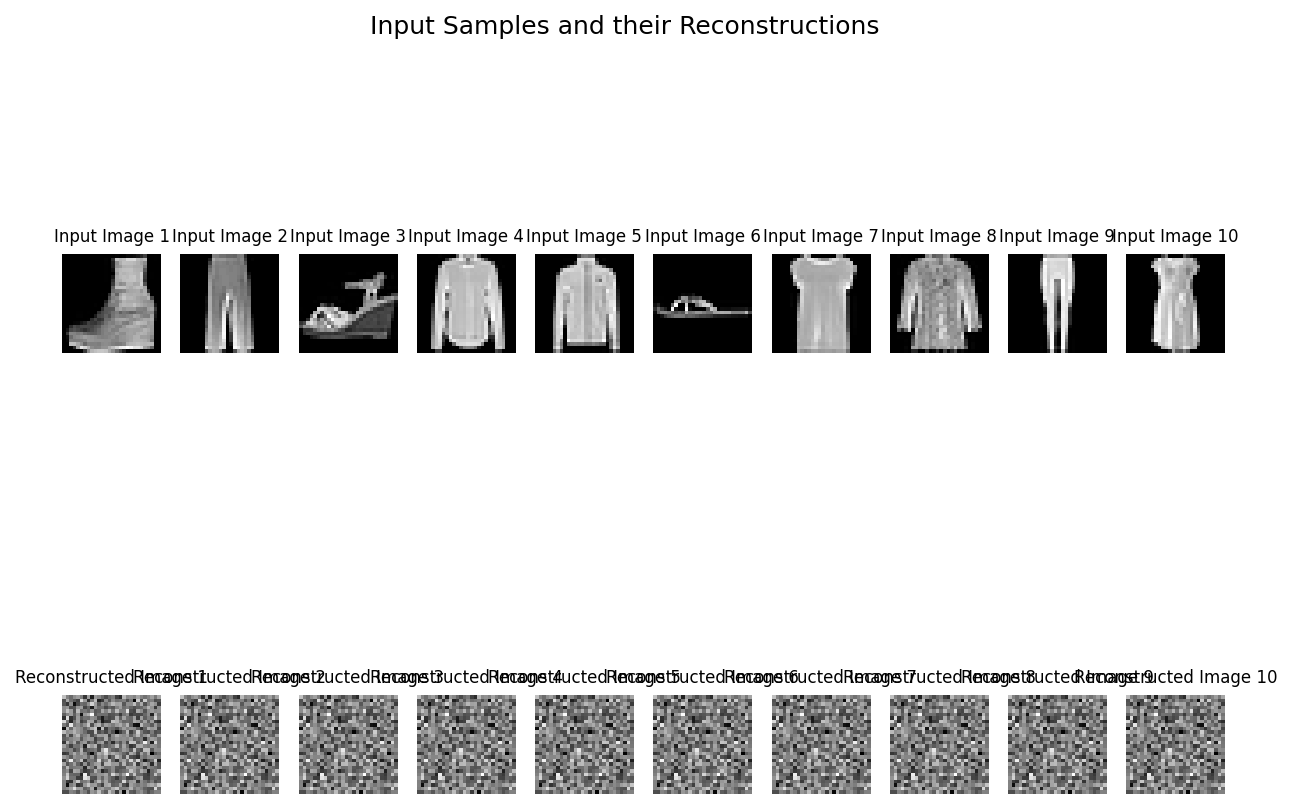

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


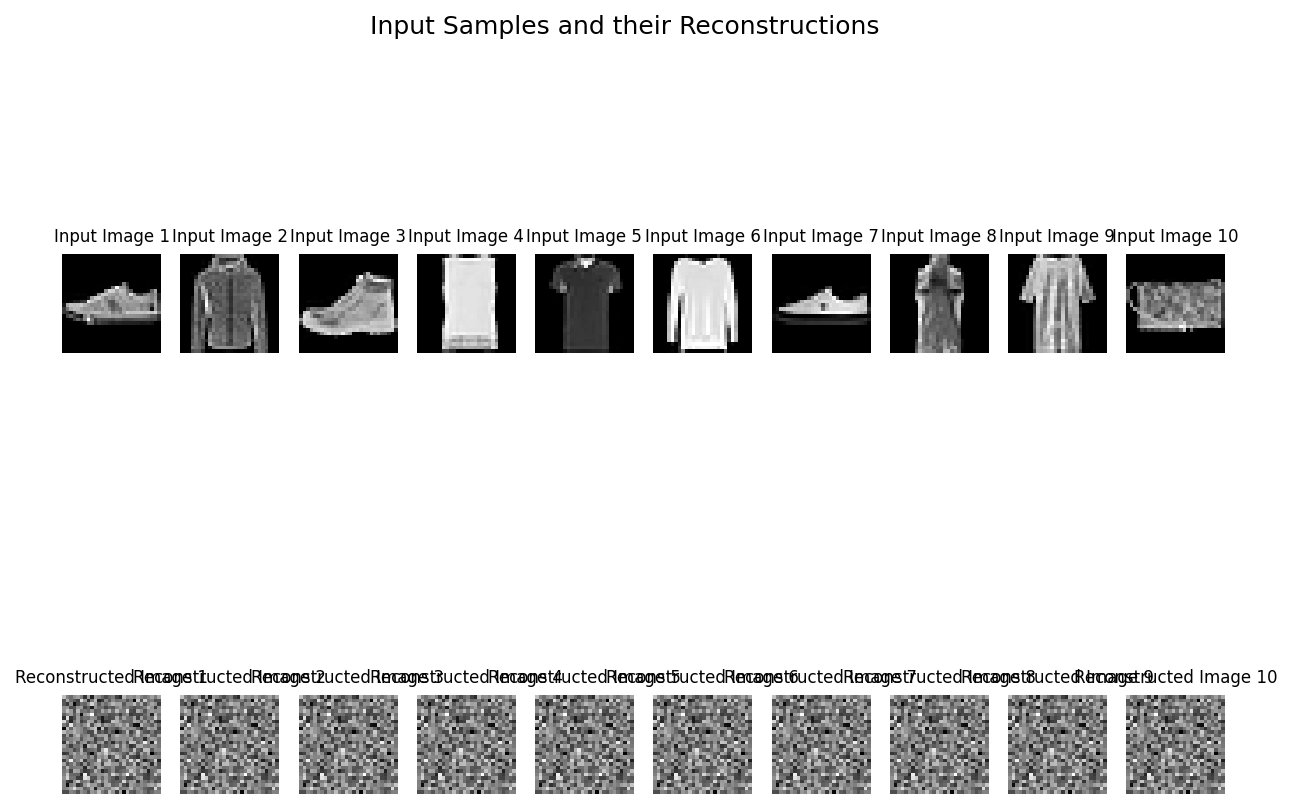

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


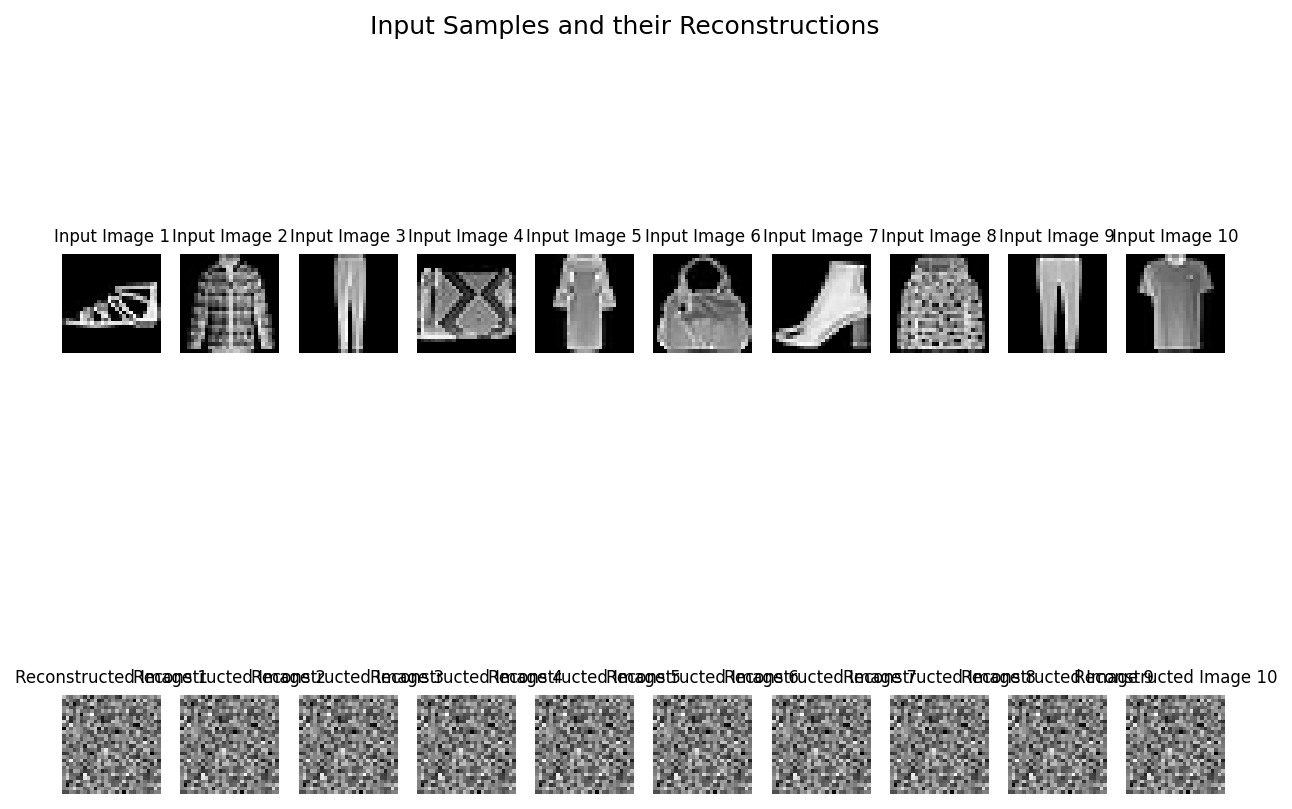

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


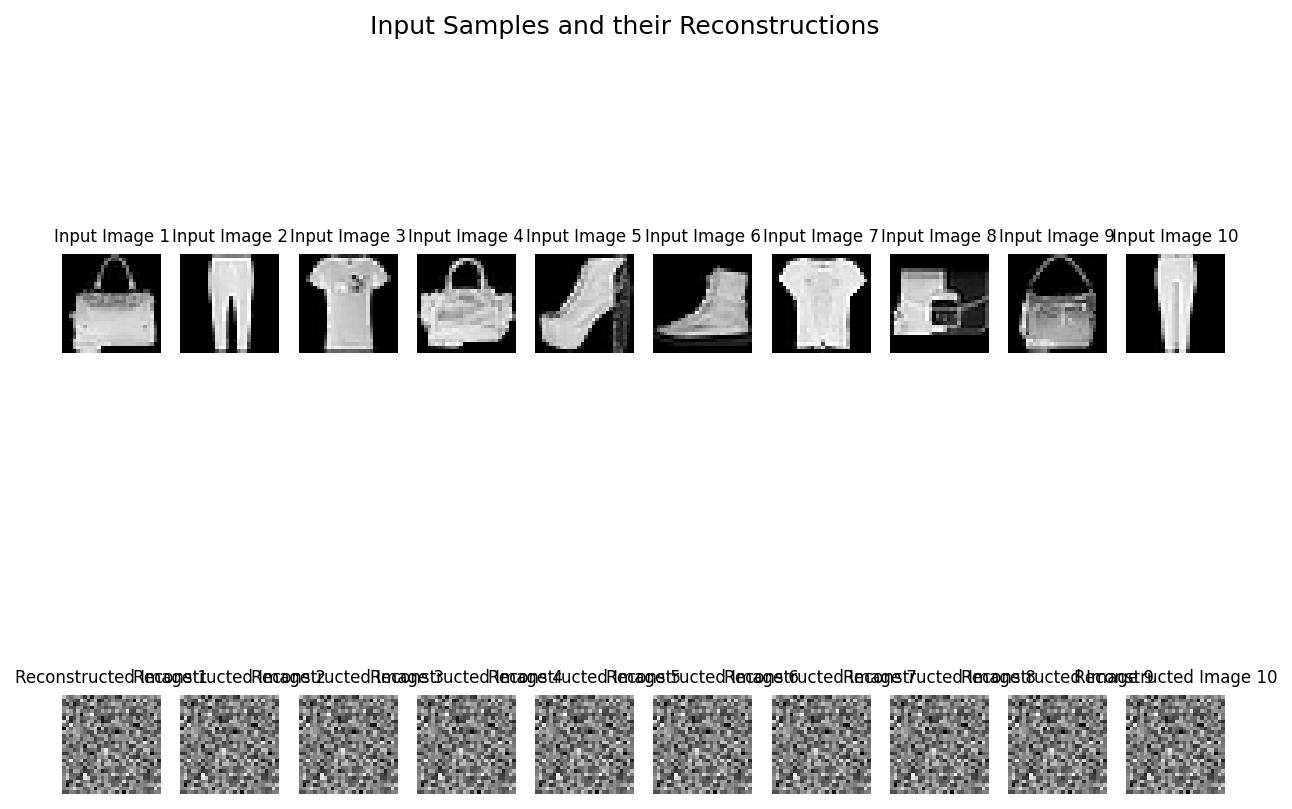

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Epoch 2/3, Loss: 0.6798
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 2

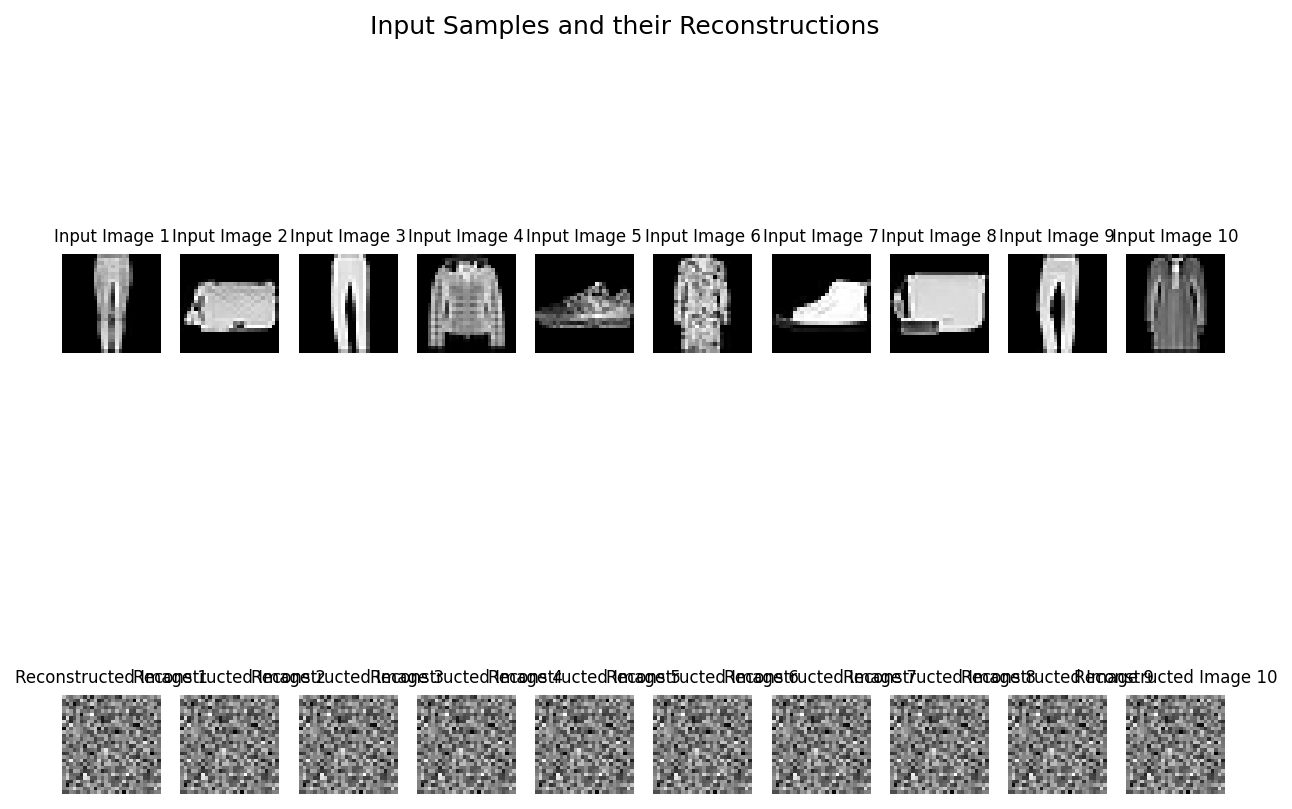

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


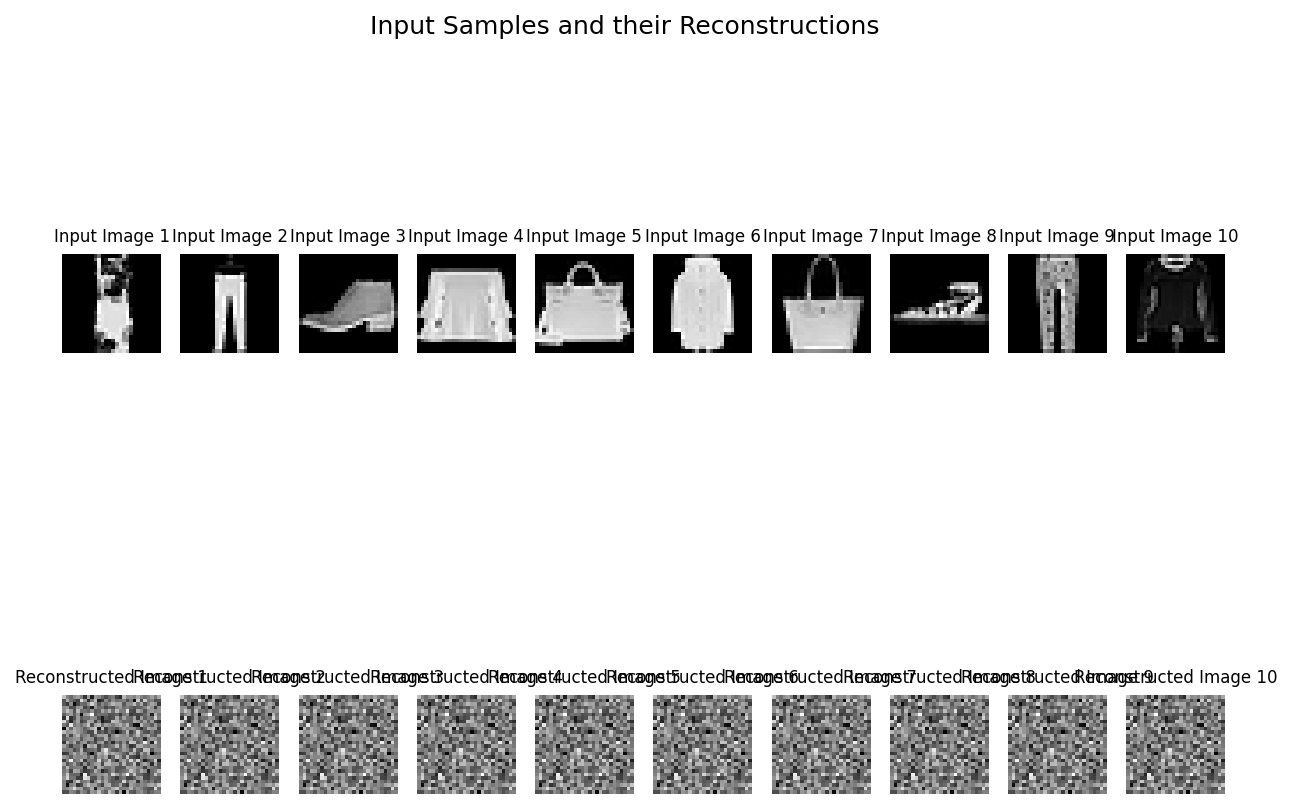

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


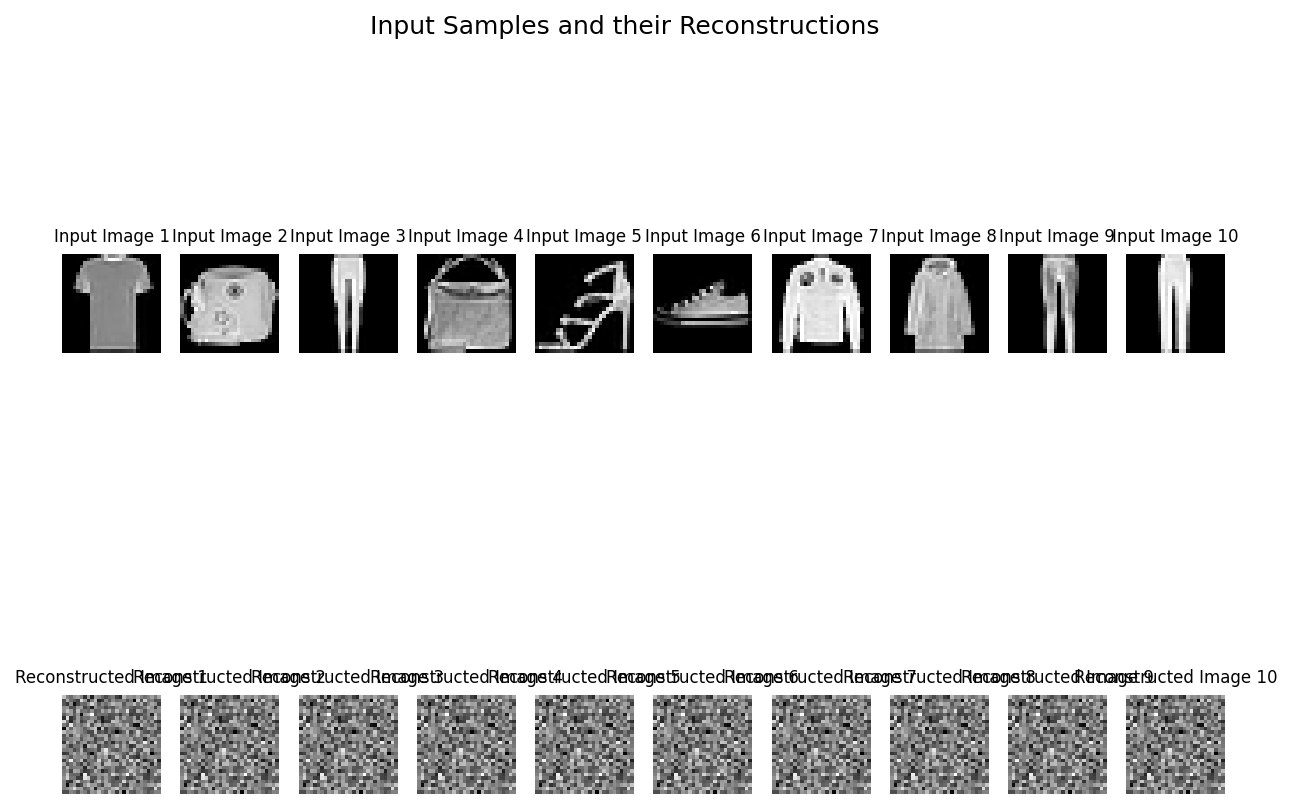

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


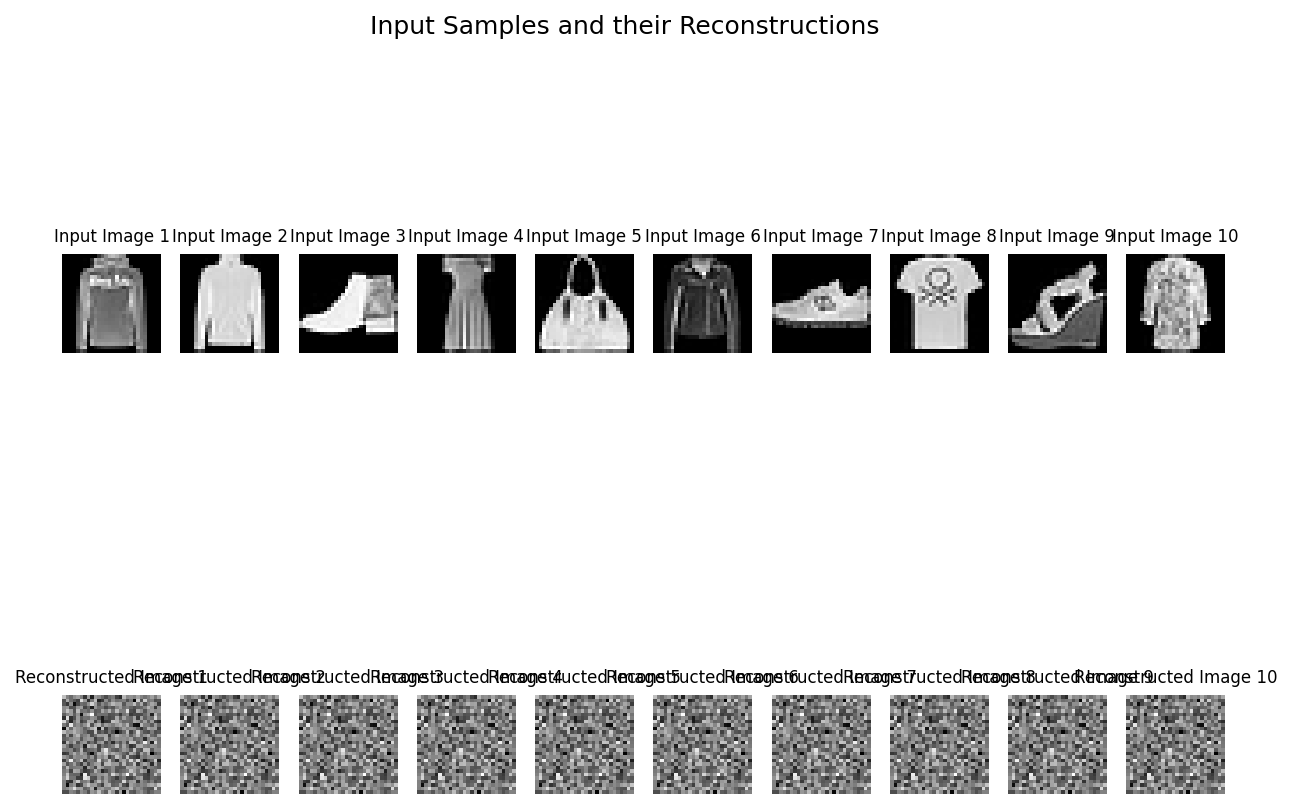

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


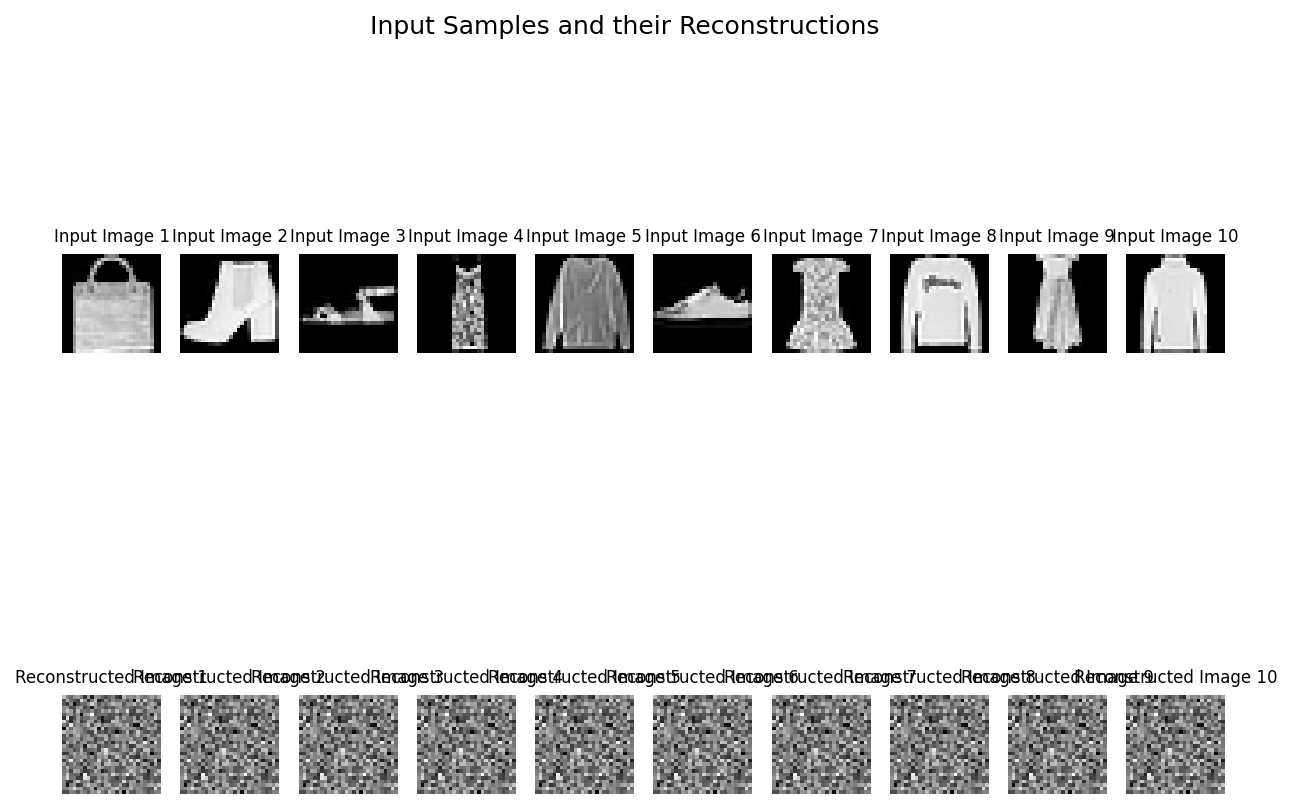

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


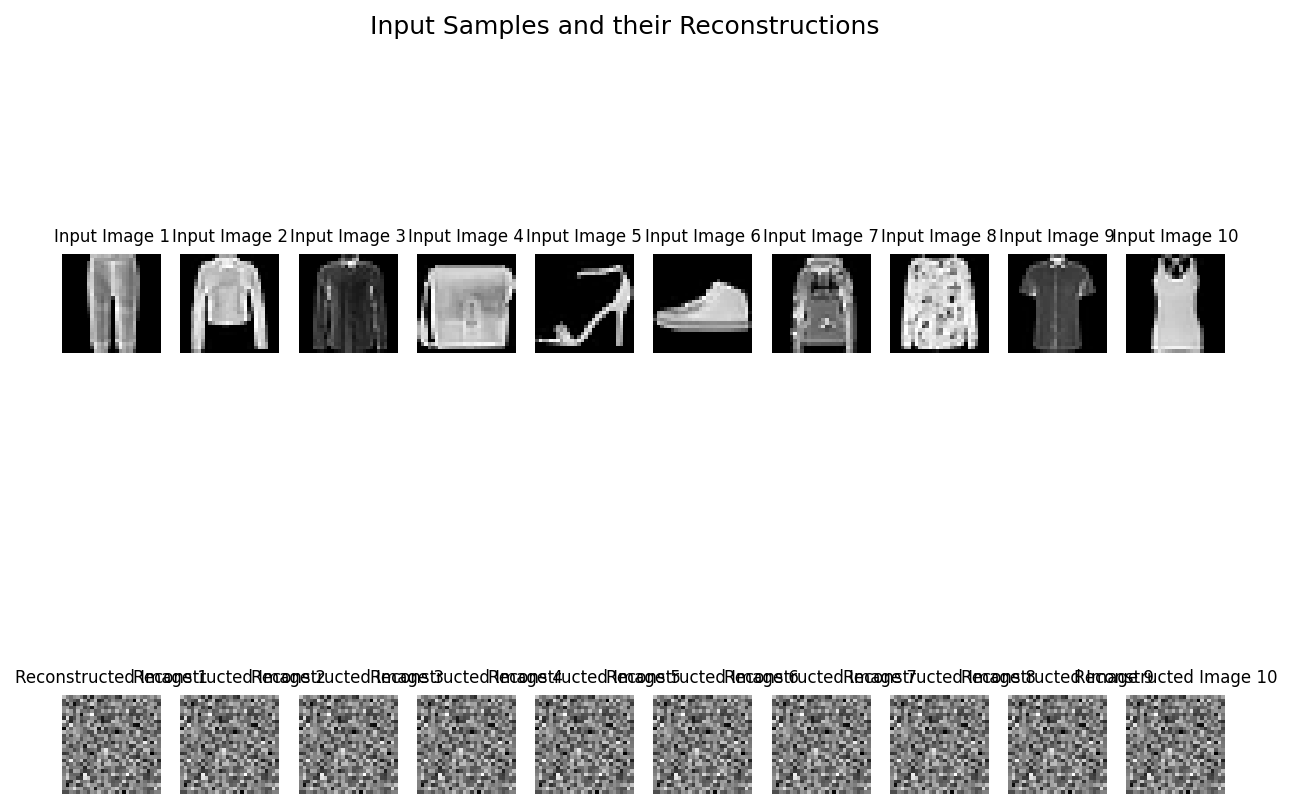

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


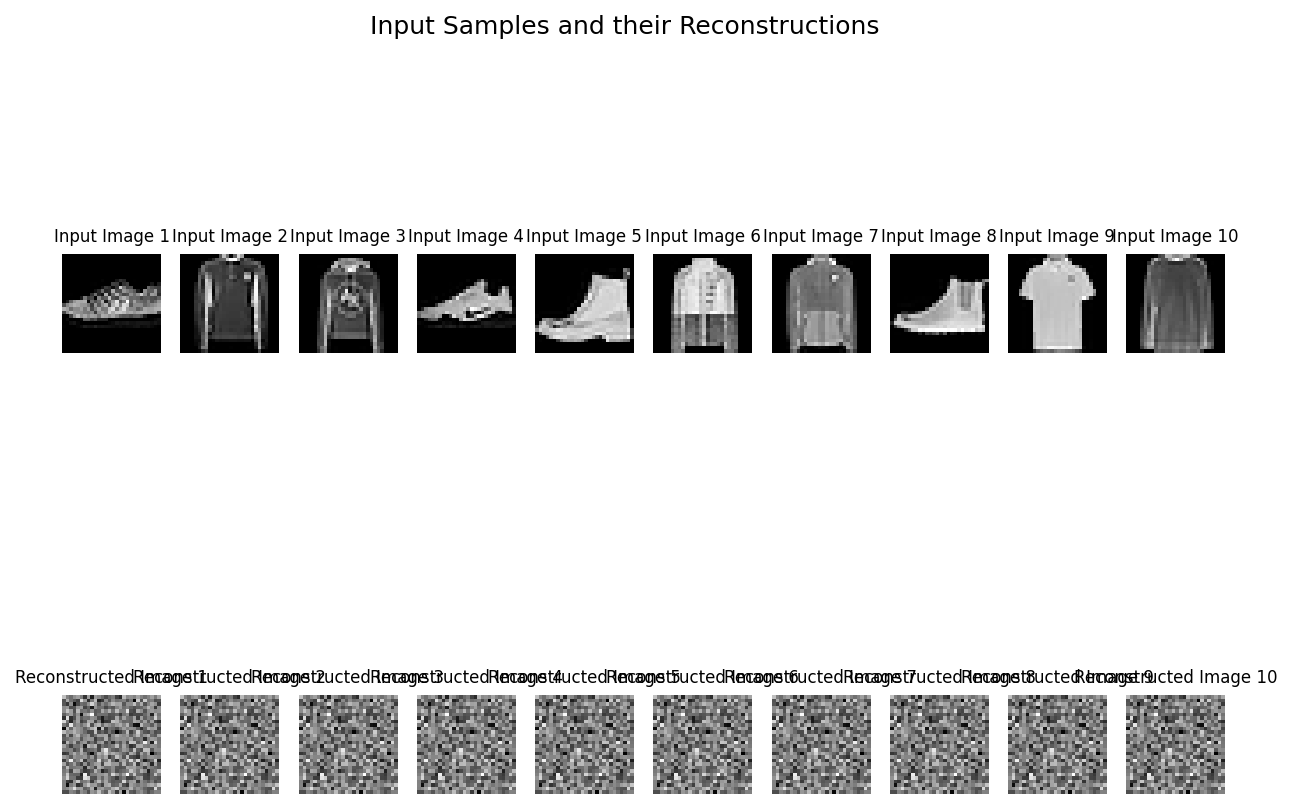

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Epoch 3/3, Loss: 0.6791


In [17]:
# test the model
for epoch in range(EPOCHS):
    test_loss = test(autoencoder, testloader, criterion, device=device)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {test_loss:.4f}')

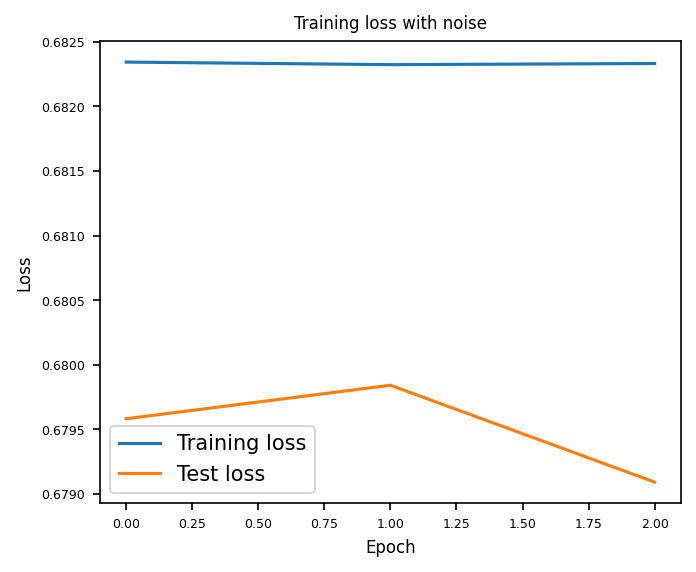

In [18]:
# Plot the loss curve
plot_loss(train_losses, test_losses, label='Training loss with noise', path=RESULTS_DIR+'ae_loss_curve_noise.png')

**Describe how has the performance of the model changed.**

TODO: 

* One technique that can be used to improve the robustness of a model is the regularization technique of noise. However, during the early stages of training, the addition of noise can make it more difficult for the encoder to learn how to denoise the input images to extract meaningful features from the input data, resulting in a higher training loss. 
* As training progresses, however, the encoder shows that it can become more adept at extracting meaningful features from the noisy data, resulting in improved performance on both the training and validation data.

### Task 3: Implement a Convolutional Autoencoder

In [19]:
# 3.1 mplement a convolutional autoencoder using the class torch.nn.Module4 from pytorch. Use the provided starter code as a template.
conv_autoencoder = ConvAutoencoder().to(device)
print(conv_autoencoder)

ConvAutoencoder(
  (encoder): ConvEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Flatten(start_dim=1, end_dim=-1)
      (5): Linear(in_features=3200, out_features=10, bias=True)
      (6): Softmax(dim=1)
    )
  )
  (decoder): ConvDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=400, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=400, out_features=4000, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
      (4): Unflatten(dim=1, unflattened_size=(10, 20, 20))
      (5): ConvTranspose2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
      (6): LeakyReLU(negative_slope=0.1)
      (7): ConvTranspose2d(10, 1, kernel_size=(5, 5), stride=(1, 1))
      (8): Tanh()
    )
  )
)


In [20]:
# 3.2 Use the mean squared error5 to implement the reconstruction error of the autoencoder. 
# The error will be computed between the input image x and the output of the autoencoder g(f (x)).

criterion = nn.MSELoss()

In [21]:
# 3.3 For training use Adam as optimizer with a learning rate of 0.001, weight decay of 1e −5 and a batch size of 128. Run it for at least 50 epochs.
lr = 0.001
weight_decay = 1e-5

# create optimizer
optimizer = torch.optim.Adam(conv_autoencoder.parameters(), lr=lr, weight_decay=weight_decay) # Adam optimizer

In [22]:
# Report the loss on the training split for each epoch, and every ten epochs on the test set
train_losses = []
test_losses = []

# train the model
for epoch in range(EPOCHS):
    start = time.time()
    train_loss = train(conv_autoencoder, trainloader, optimizer, criterion, device=device)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}, Time: {time.time()-start:.2f} sec')

Epoch 1/3, Loss: 0.1458, Time: 37.91 sec
Epoch 2/3, Loss: 0.0824, Time: 35.73 sec
Epoch 3/3, Loss: 0.0752, Time: 38.55 sec


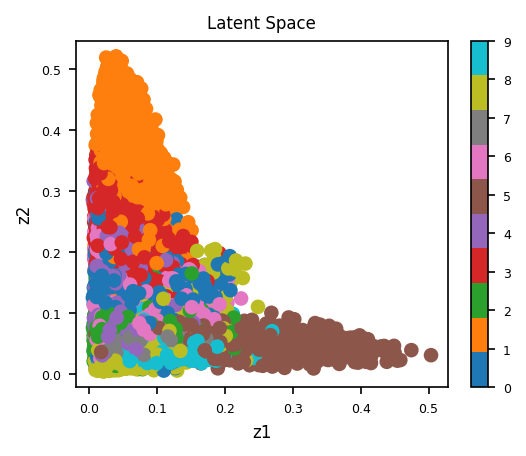

In [23]:
# Plot the latent space
plot_latent(conv_autoencoder, trainloader, num_batches=BATCH_SIZE, path=f'{RESULTS_DIR}aeconv_latent.png')

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


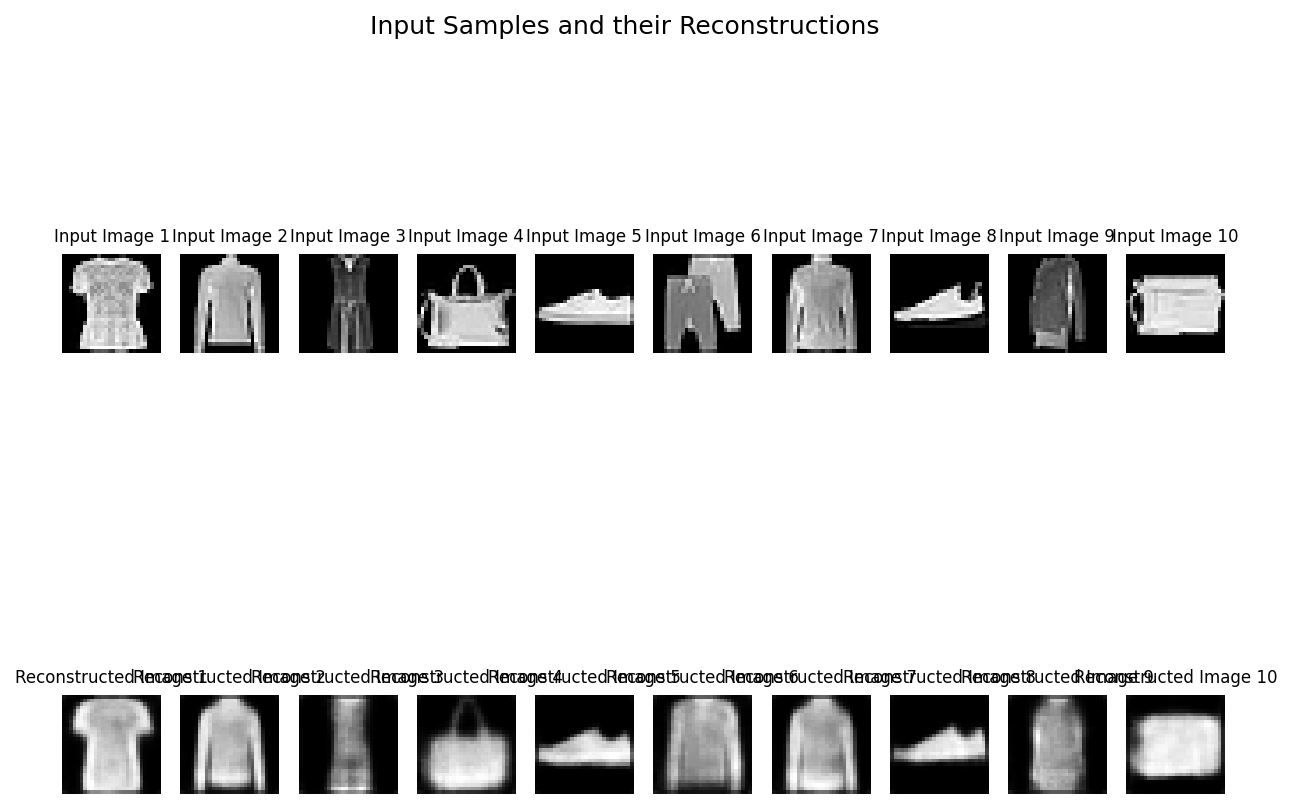

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


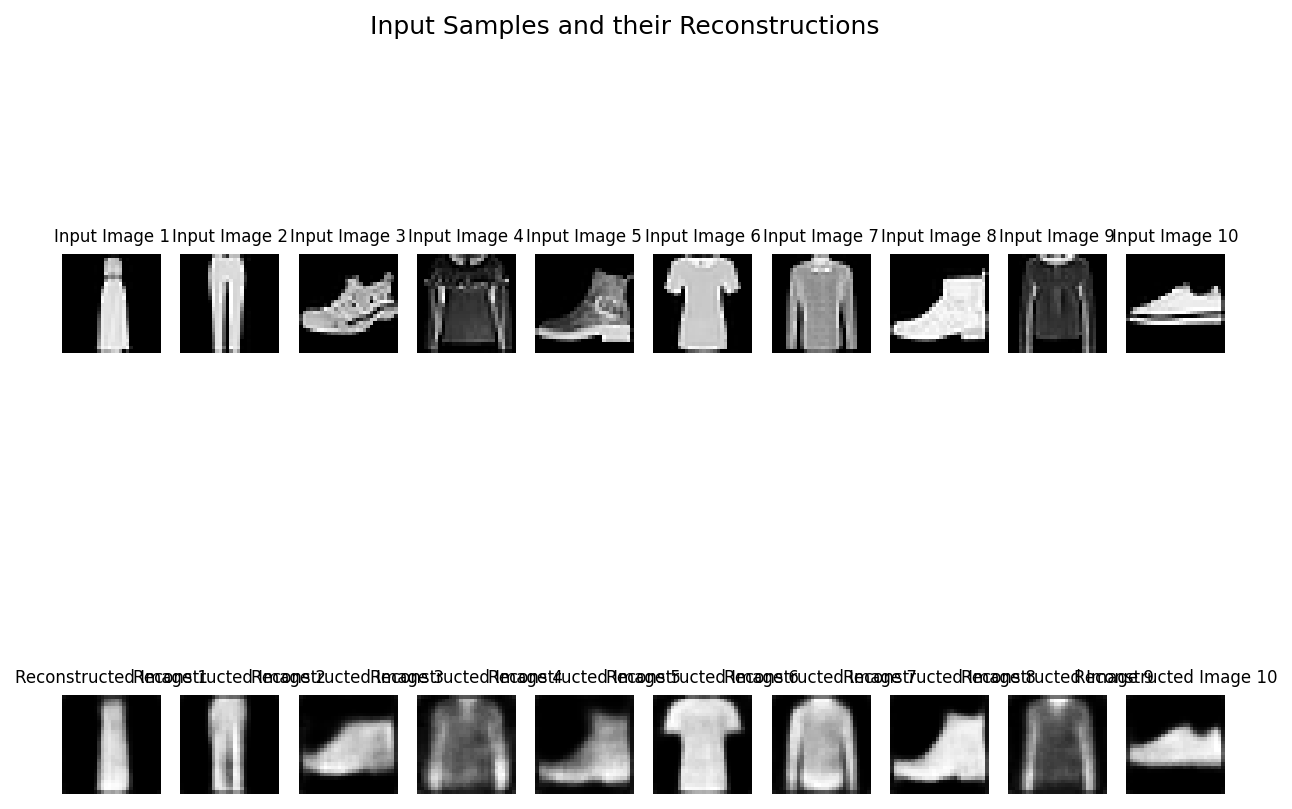

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


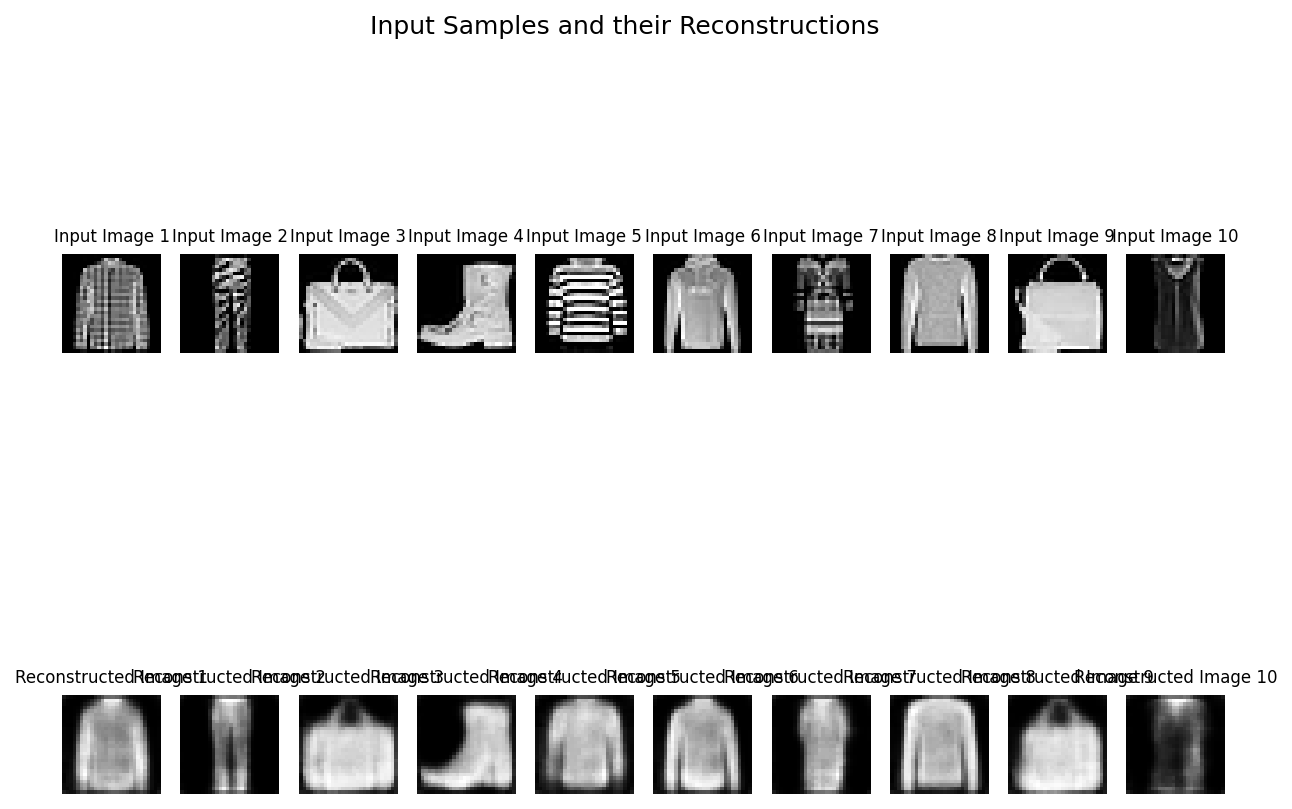

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


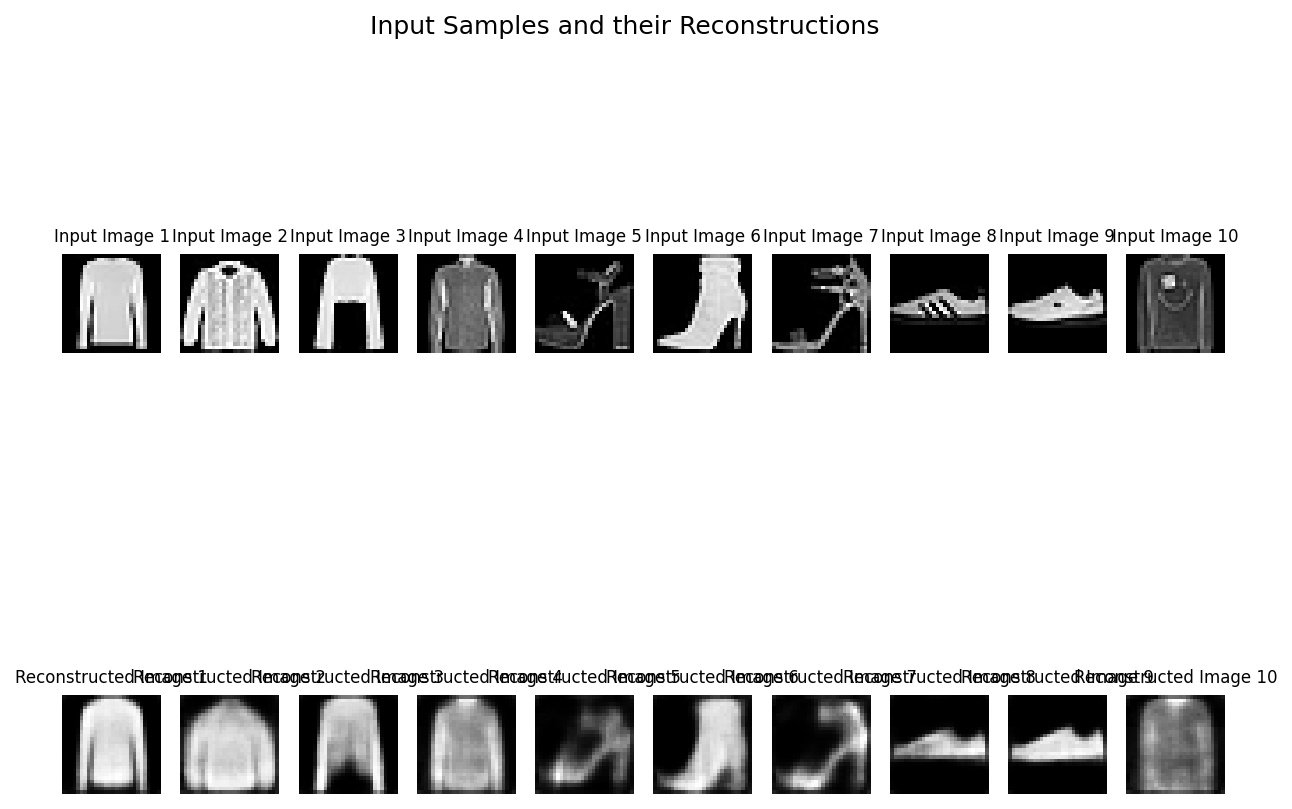

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


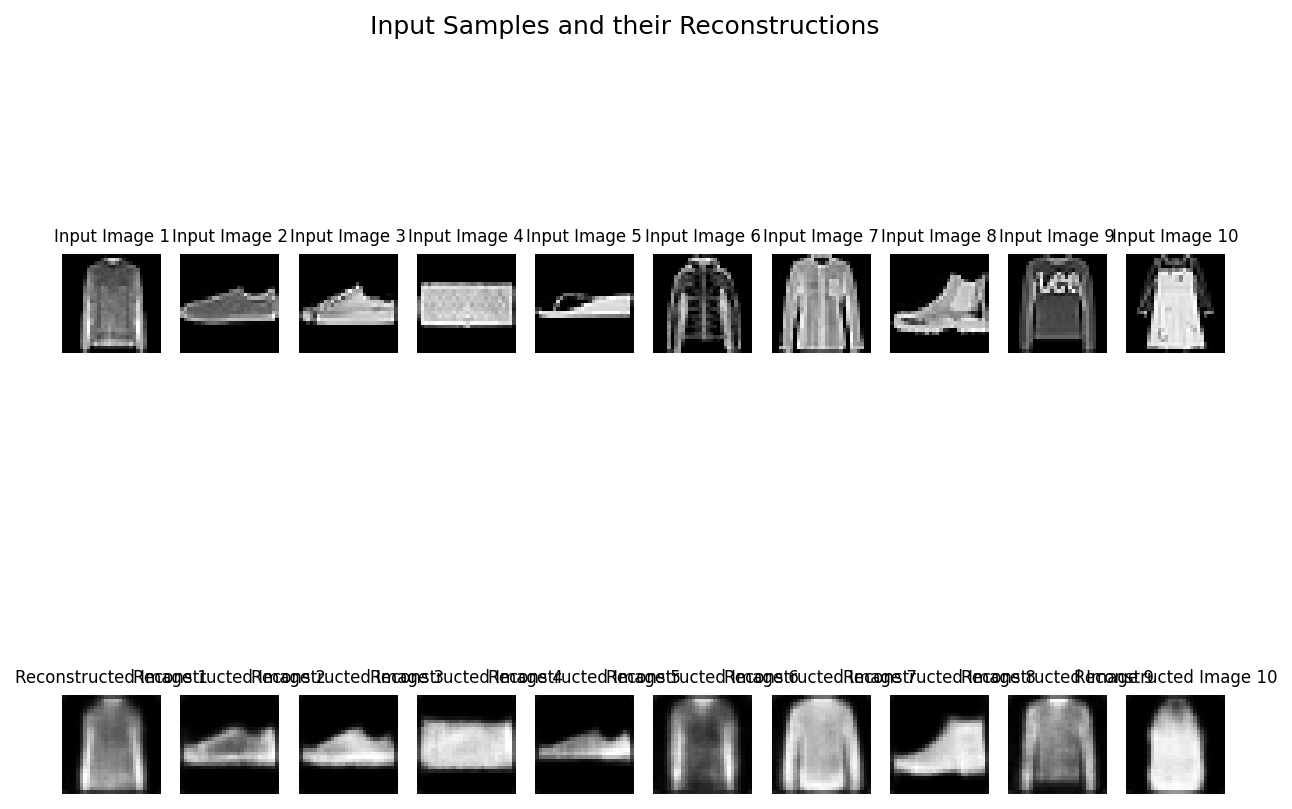

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


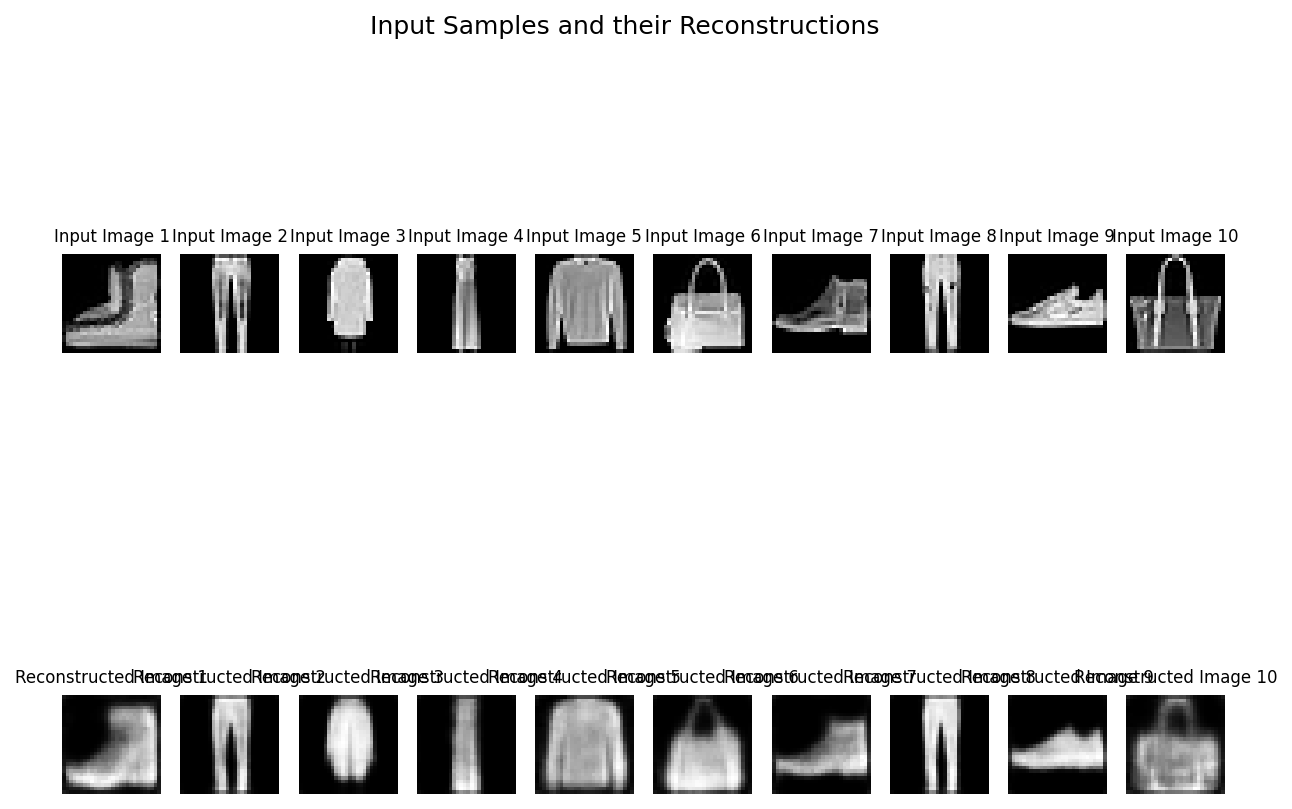

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


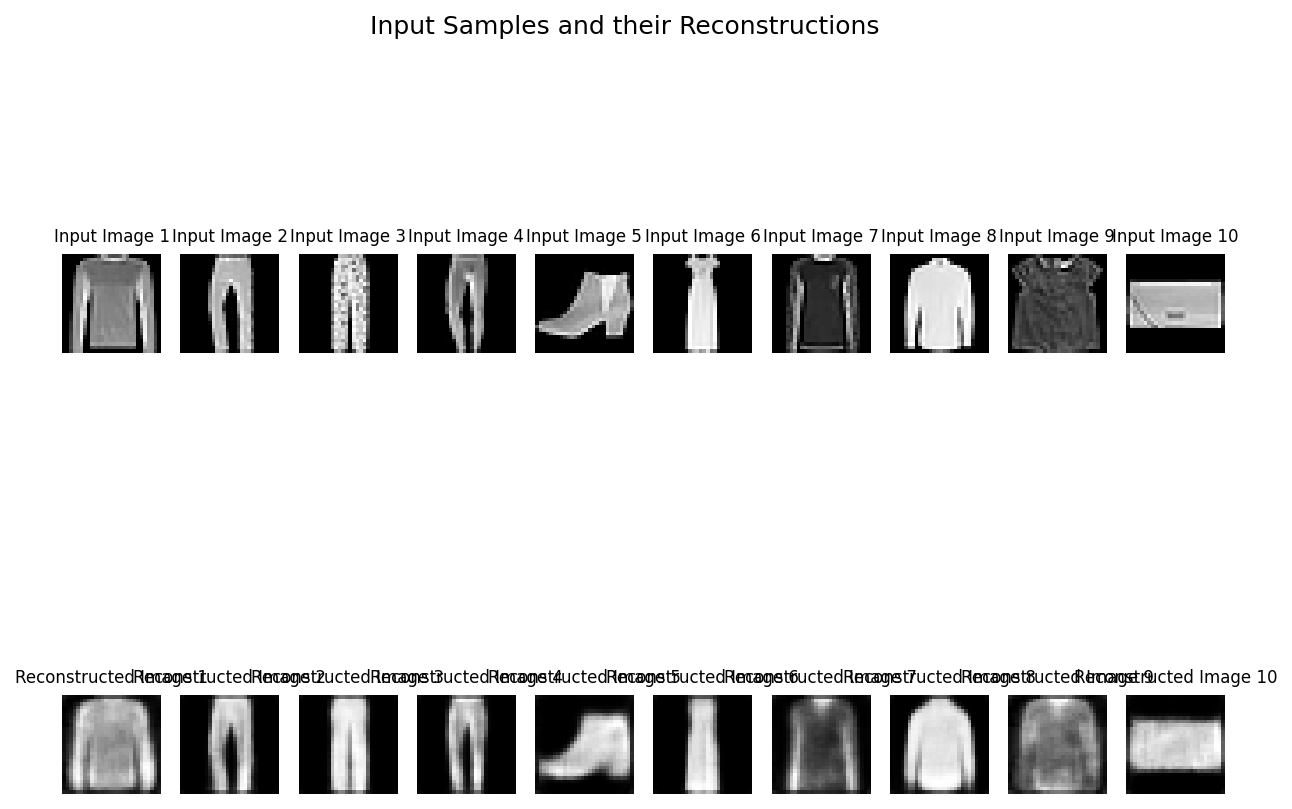

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Epoch 1/3, Loss: 0.0733
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 2

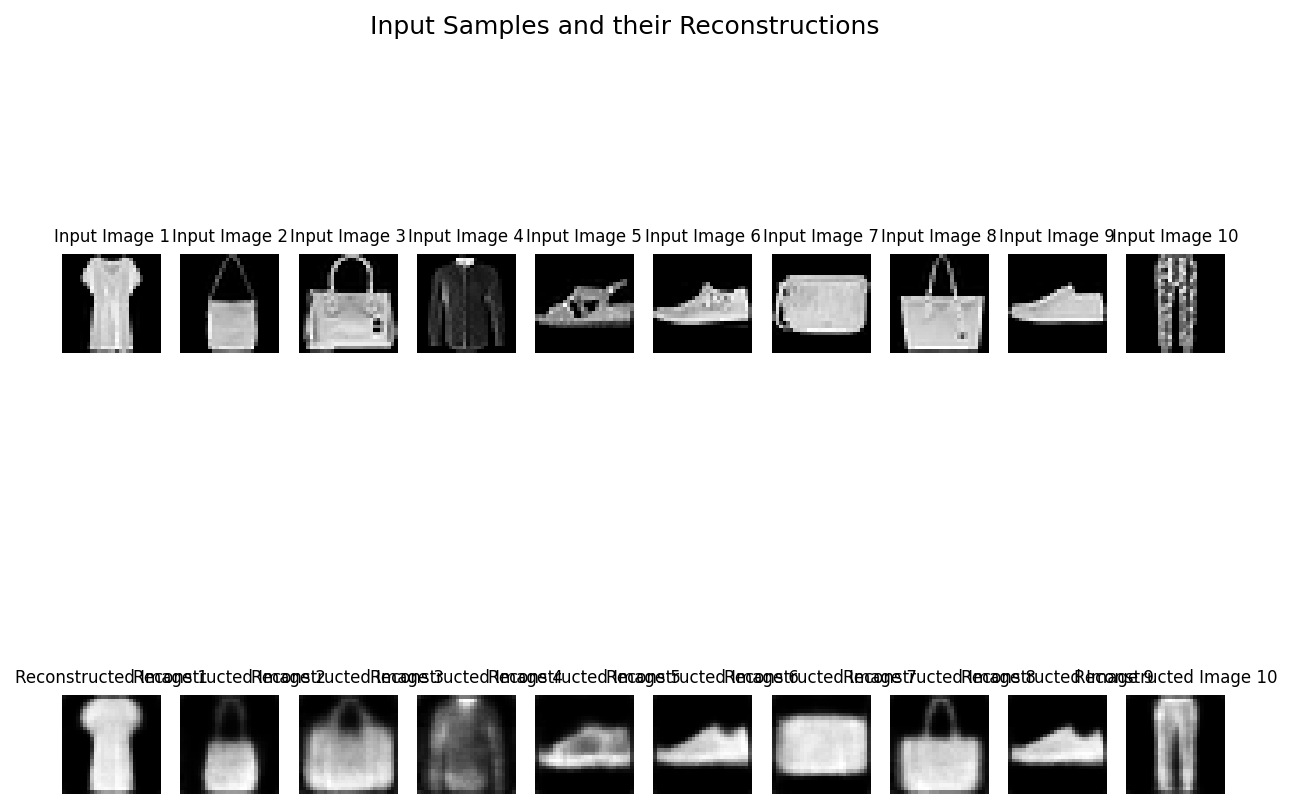

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


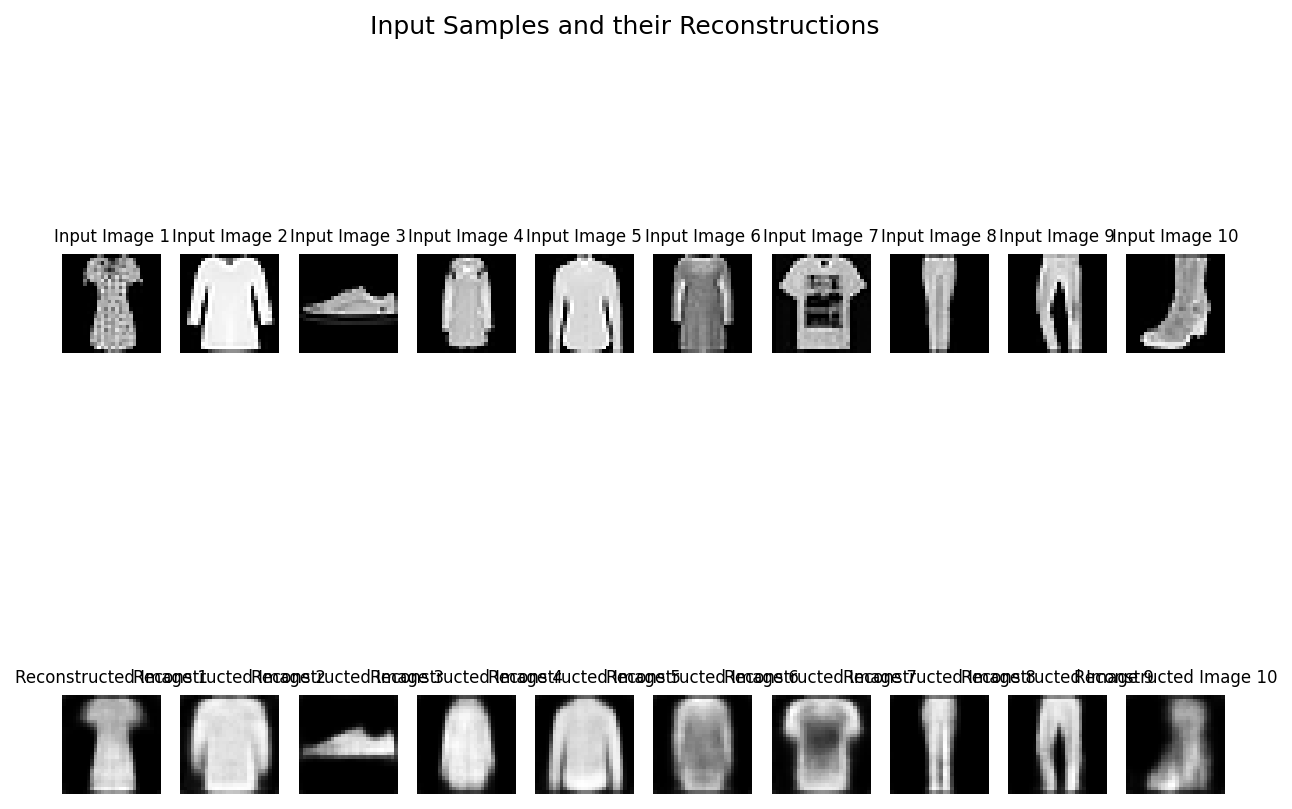

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


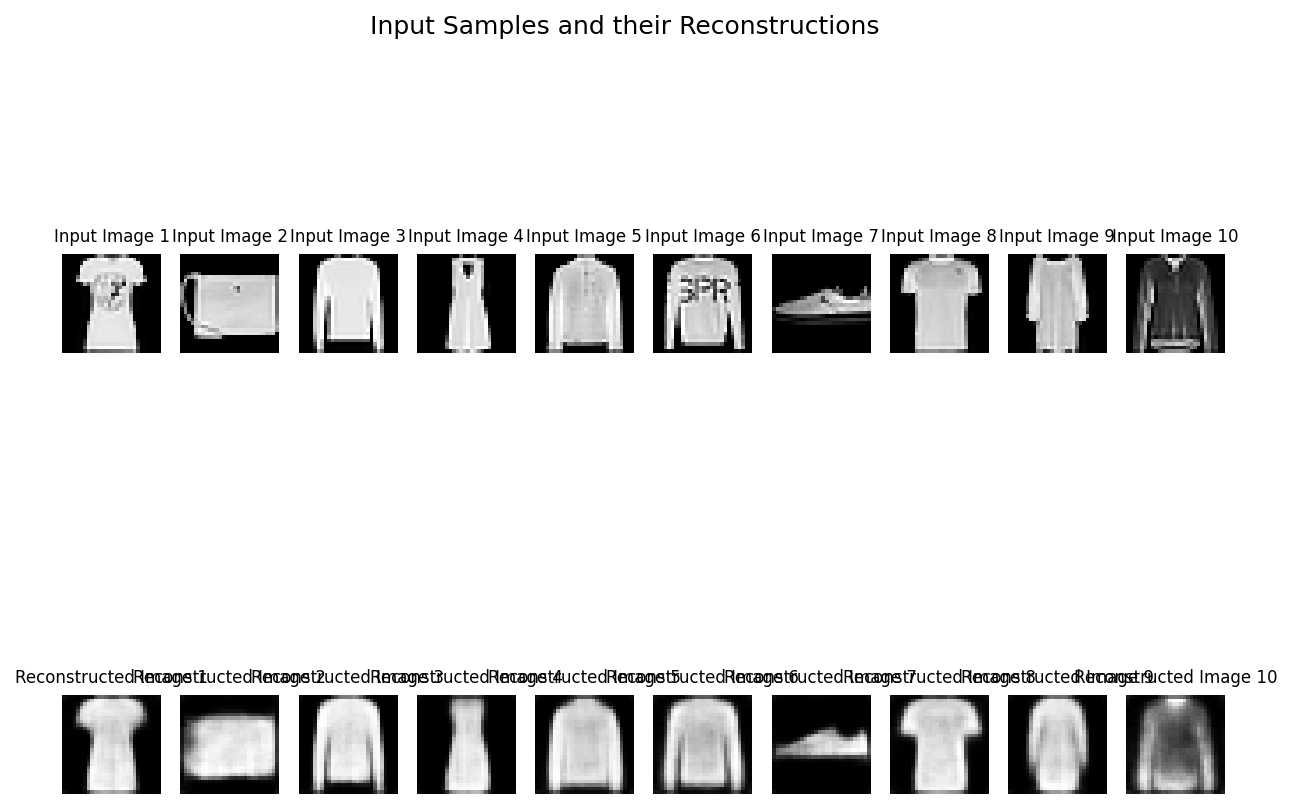

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


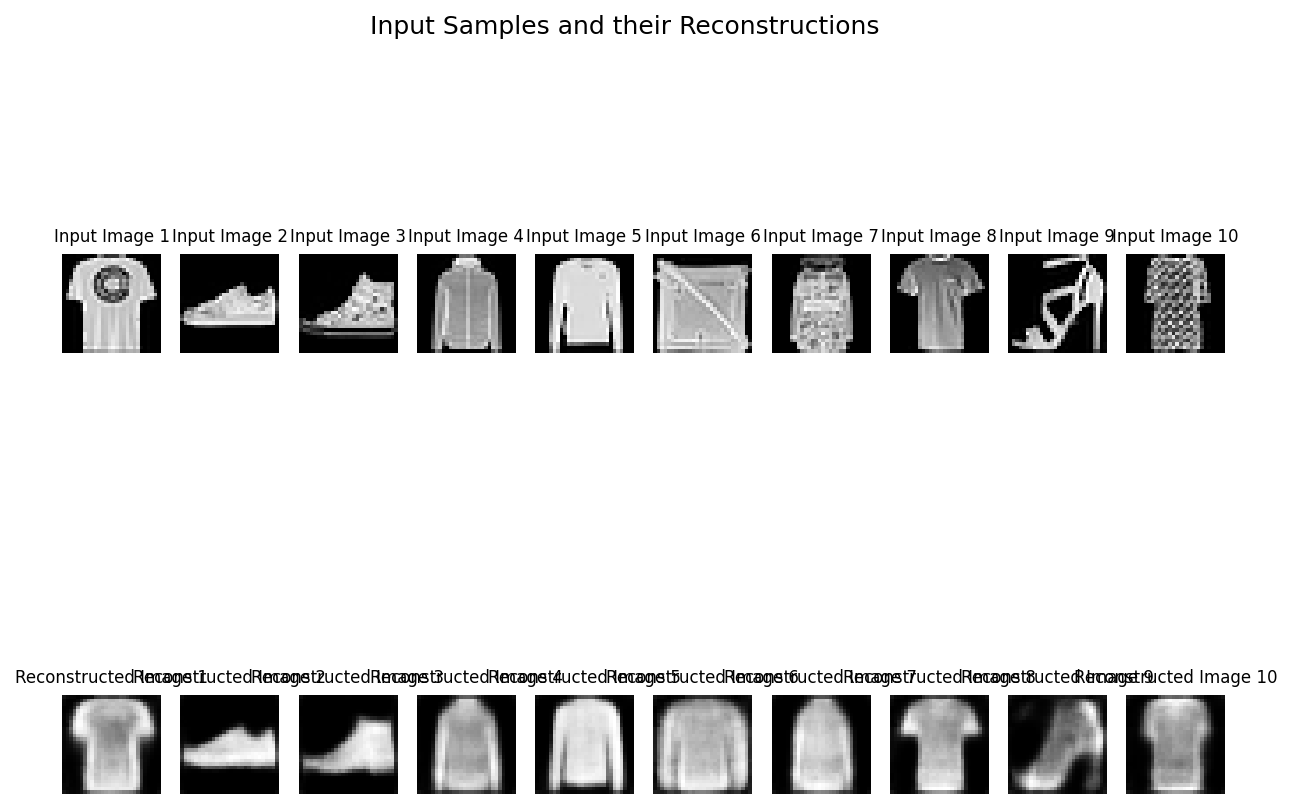

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


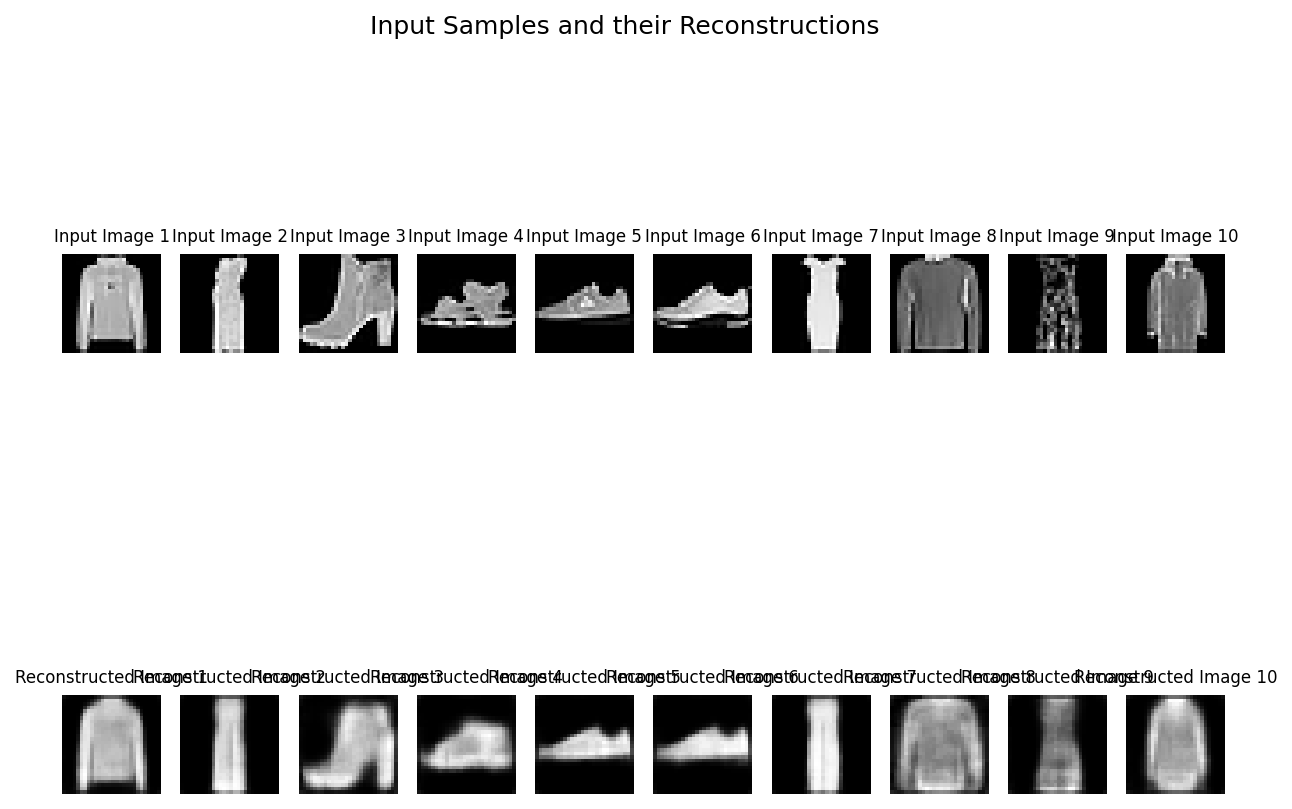

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


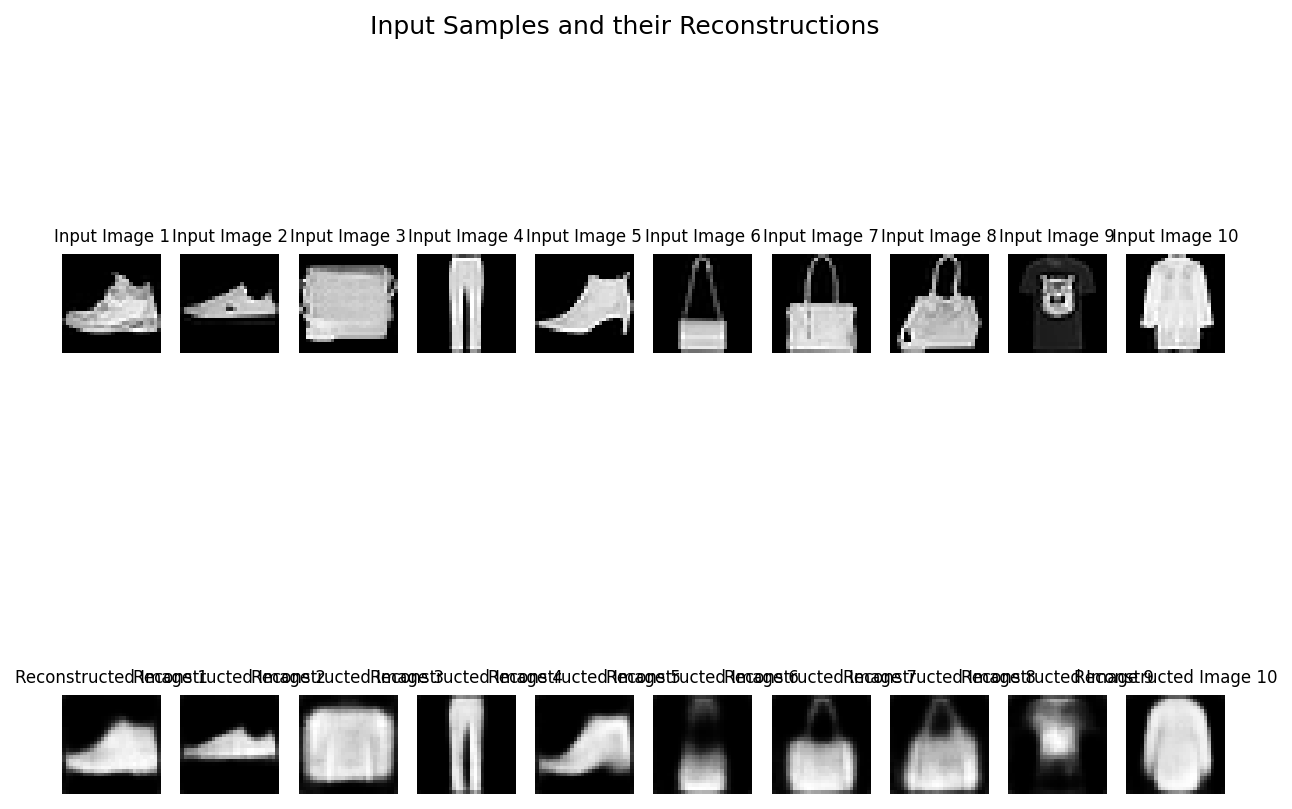

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


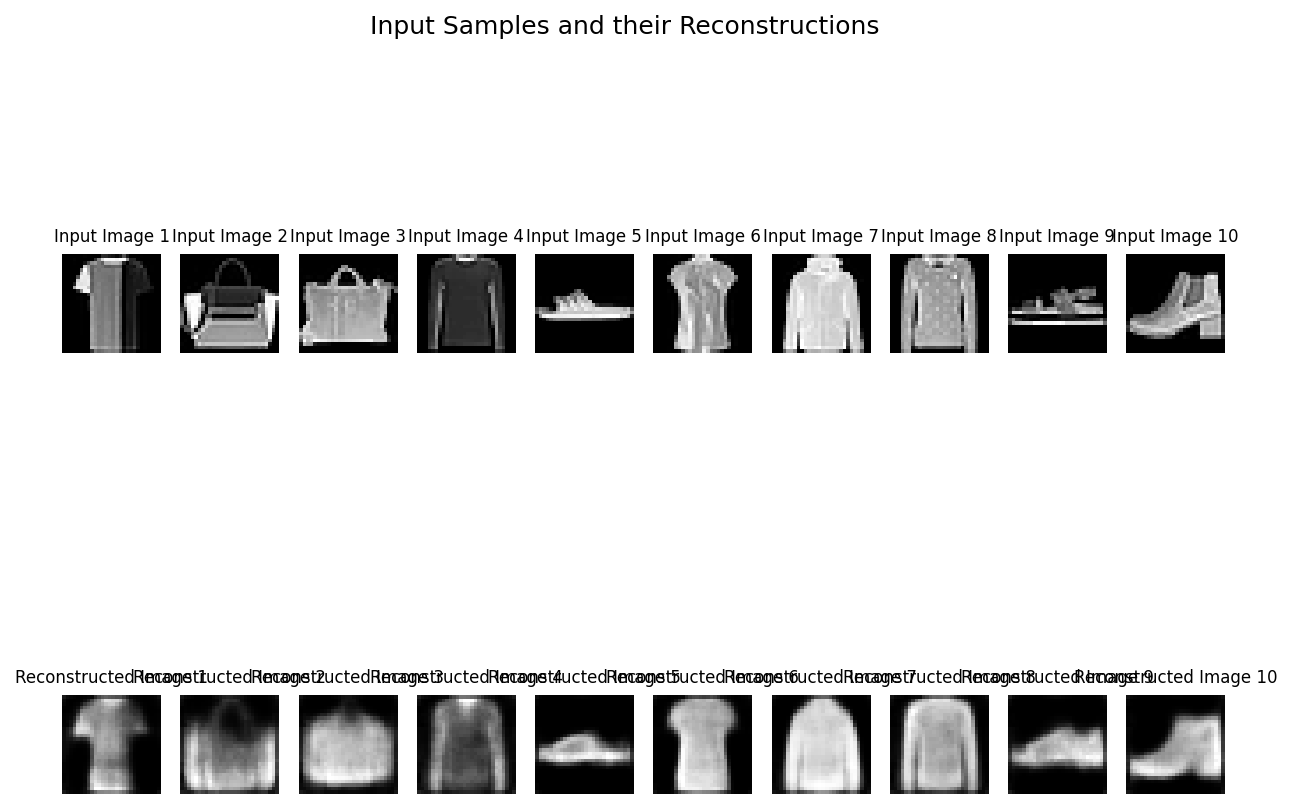

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Epoch 2/3, Loss: 0.0734
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 2

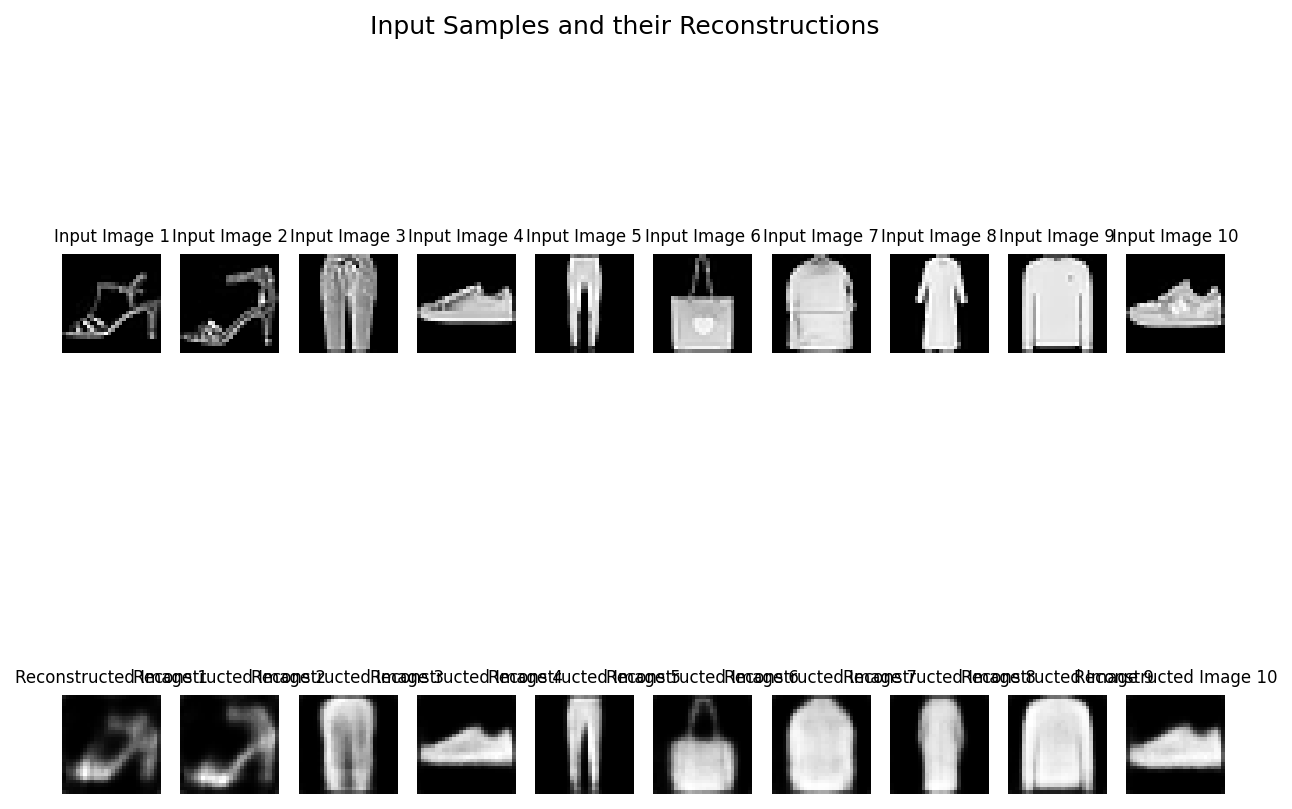

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


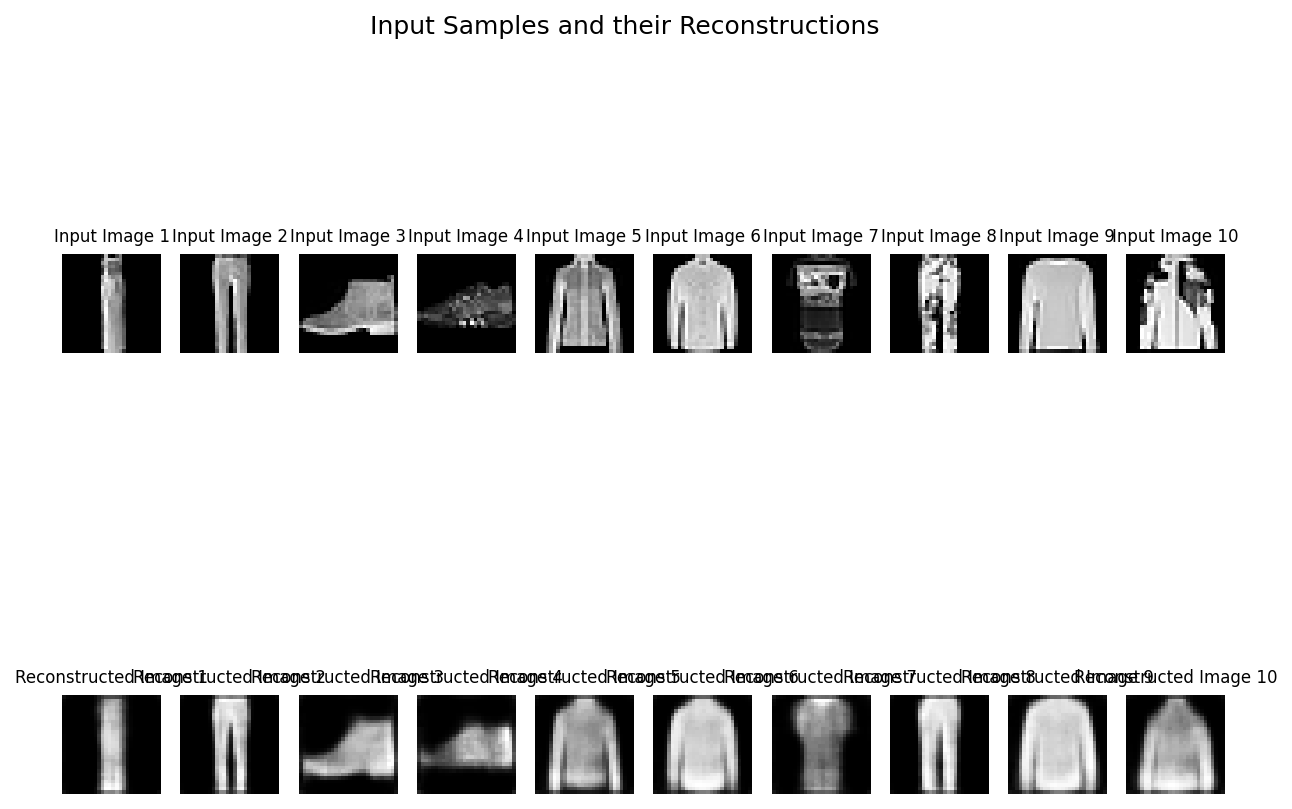

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


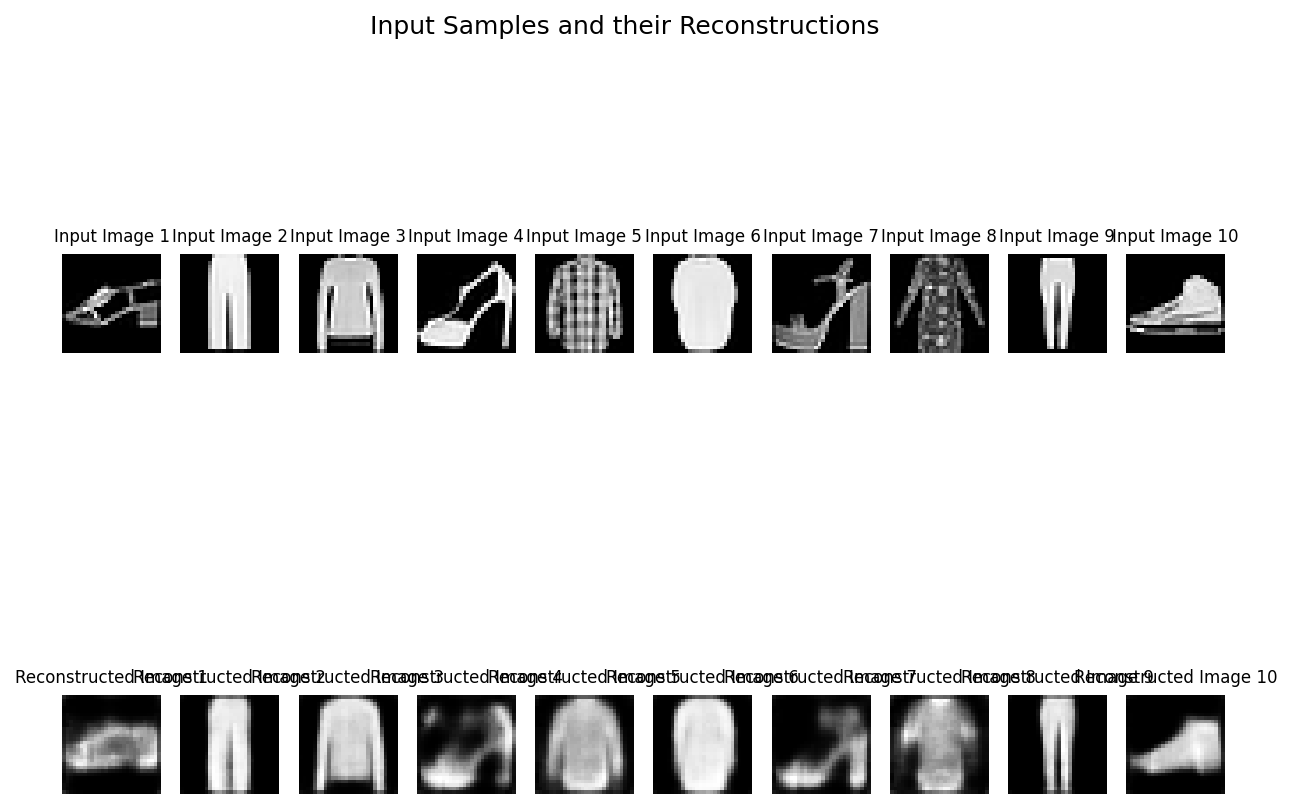

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


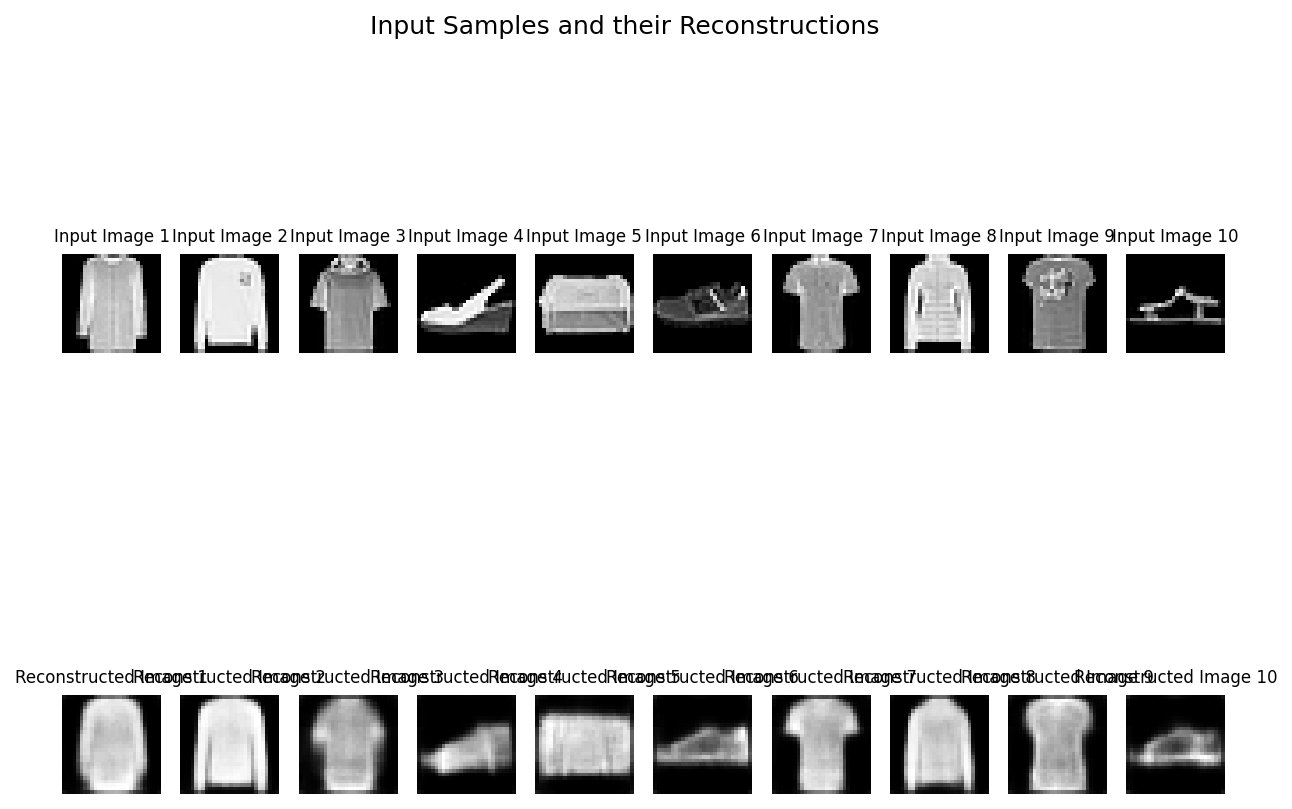

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


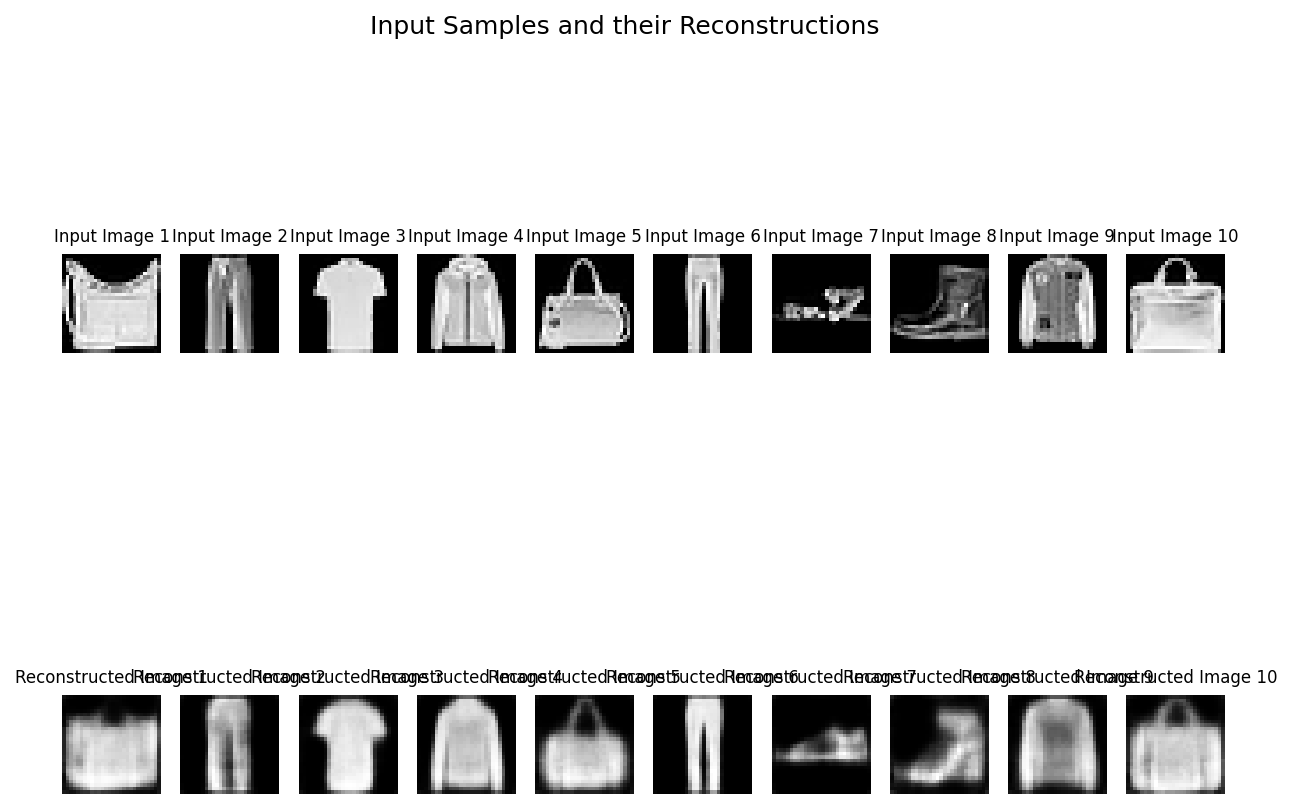

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


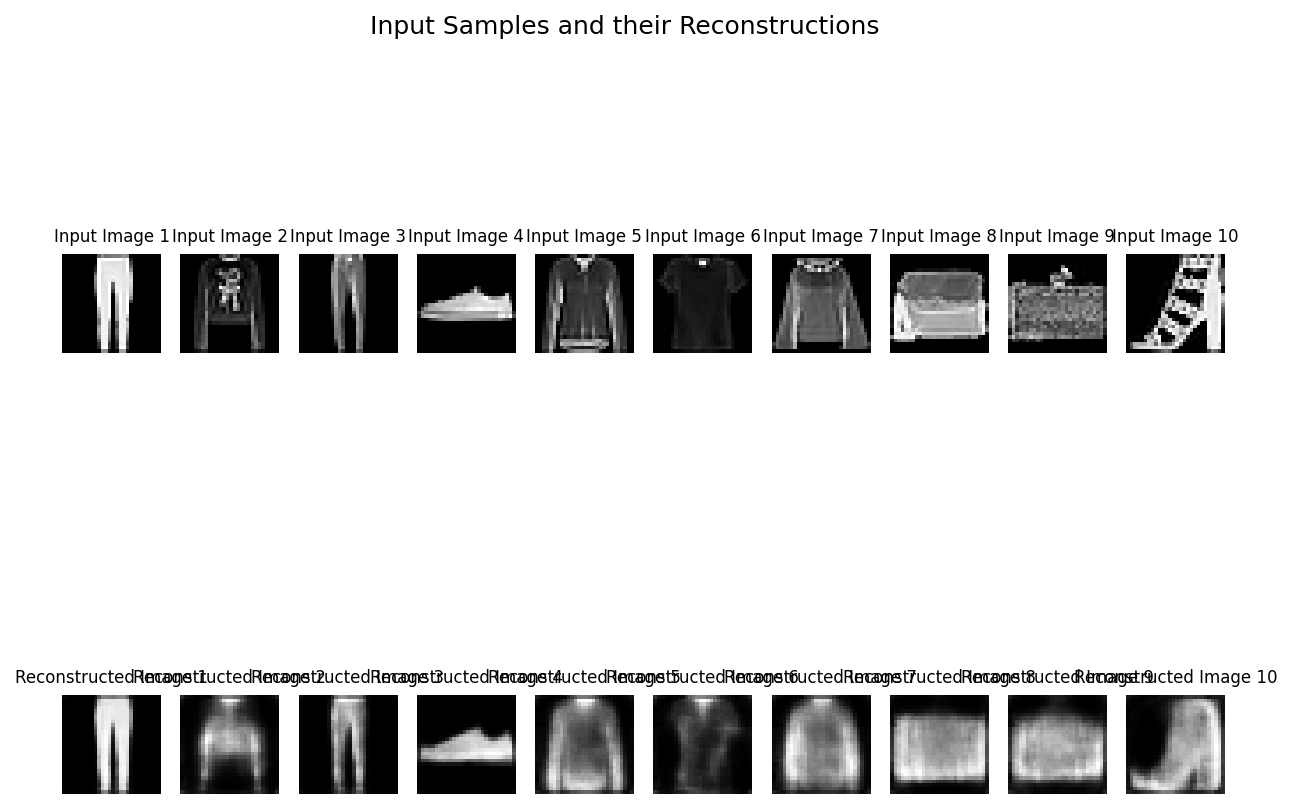

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


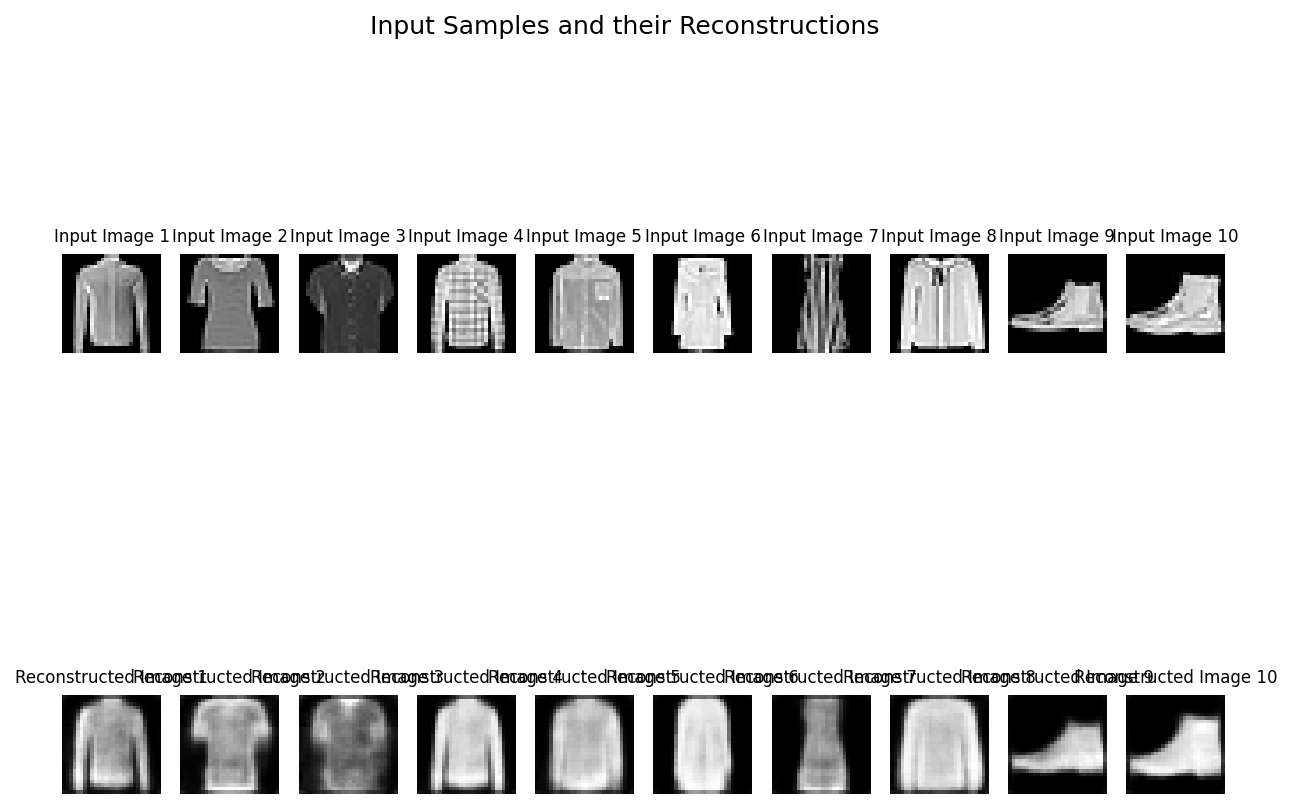

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Epoch 3/3, Loss: 0.0734


In [24]:
# 3.4 During the computation of the testing loss plot ten input samples as well as their reconstructions produced by the autoencoder
# test the model
for epoch in range(EPOCHS):
    test_loss = test(conv_autoencoder, testloader, criterion, device=device)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {test_loss:.4f}')

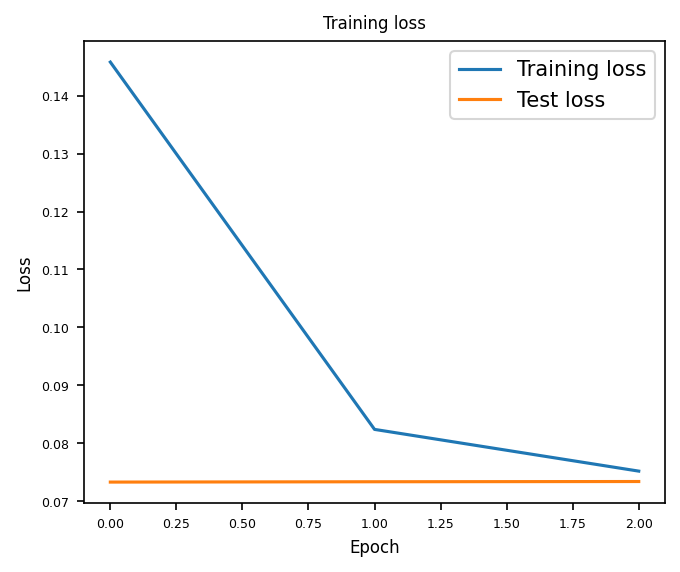

In [25]:
# Plot the loss curve
plot_loss(train_losses, test_losses, label='Training loss', path=RESULTS_DIR+'conv_ae_loss_curve.png')

**3.5 Compare the performance of this model to the model from the prior task**

* The model with Convolutional Layers demonstrates a greater capacity for learning patterns from high-dimensional, 2D spatial data, as the learned filters in a convolutional neural network are designed to recognize more complex local patterns. In contrast, linear models are less equipped to handle this task.
* Upon visualizing the learned lower-dimensional latent space Z of the encoder with linear layers, it is evident that the latent space scatter plots per class exhibit a linear structure. This suggests that the linear encoder also primarily captures linear relationships in the data.
* In contrast, when examining the components of the latent space of the convolutional encoder, it is clear that the convolutional layers have facilitated a more effective projection of the encoded input values into the latent space. The presence of distinct, separable clusters in the convolutional encoder's latent space indicates that this model is able to capture more complex, non-linear relationships in the data.
* Furthermore, the expressiveness and capacity of the convolutional encoder are shown to be superior to the linear encoder. This may be due to the limitations of a linear transformation when mapping input data into the latent space, where the relationship between the input features and the latent space is strictly linear. As a result, each class is also only represented by a linearly separable region, which may not reflect the true underlying patterns in the input data. The convolutional encoder, however, is not restricted by such linear assumptions and is therefore more capable of transforming the input data into a non-linear latent space. The result visible in the training and testing loss curve is also reflected in the reconstruction of the decoder, which shows higher capacity to reconstruct output images close to the input data distribution than the linear encoder.

## Convolutional Autoencoder with Noise

In [26]:
# train the model with noise
conv_autoencoder = ConvAutoencoder().to(device)

In [27]:
train_losses = []

# train the model
for epoch in range(EPOCHS):
    start = time.time()
    train_loss = train(conv_autoencoder, trainloader, optimizer, criterion, noise=True, noise_factor=0.3, noise_stddev=1, device=device)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}, Time: {time.time()-start:.2f} sec')

Epoch 1/3, Loss: 0.9177, Time: 35.55 sec
Epoch 2/3, Loss: 0.9177, Time: 31.80 sec
Epoch 3/3, Loss: 0.9177, Time: 32.60 sec


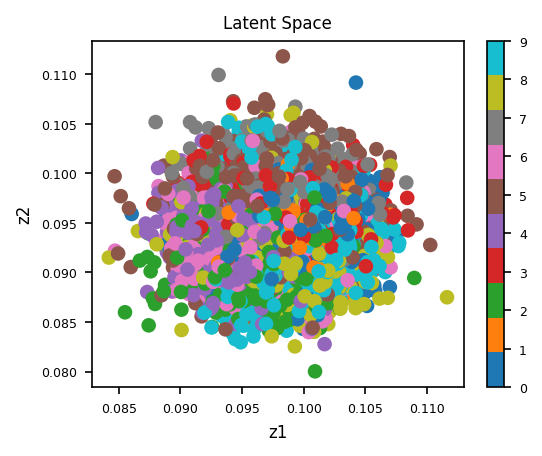

In [28]:
# Plot the latent space
plot_latent(conv_autoencoder, trainloader, num_batches=BATCH_SIZE, path=f'{RESULTS_DIR}aeconv_latent_with_noise.png')

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


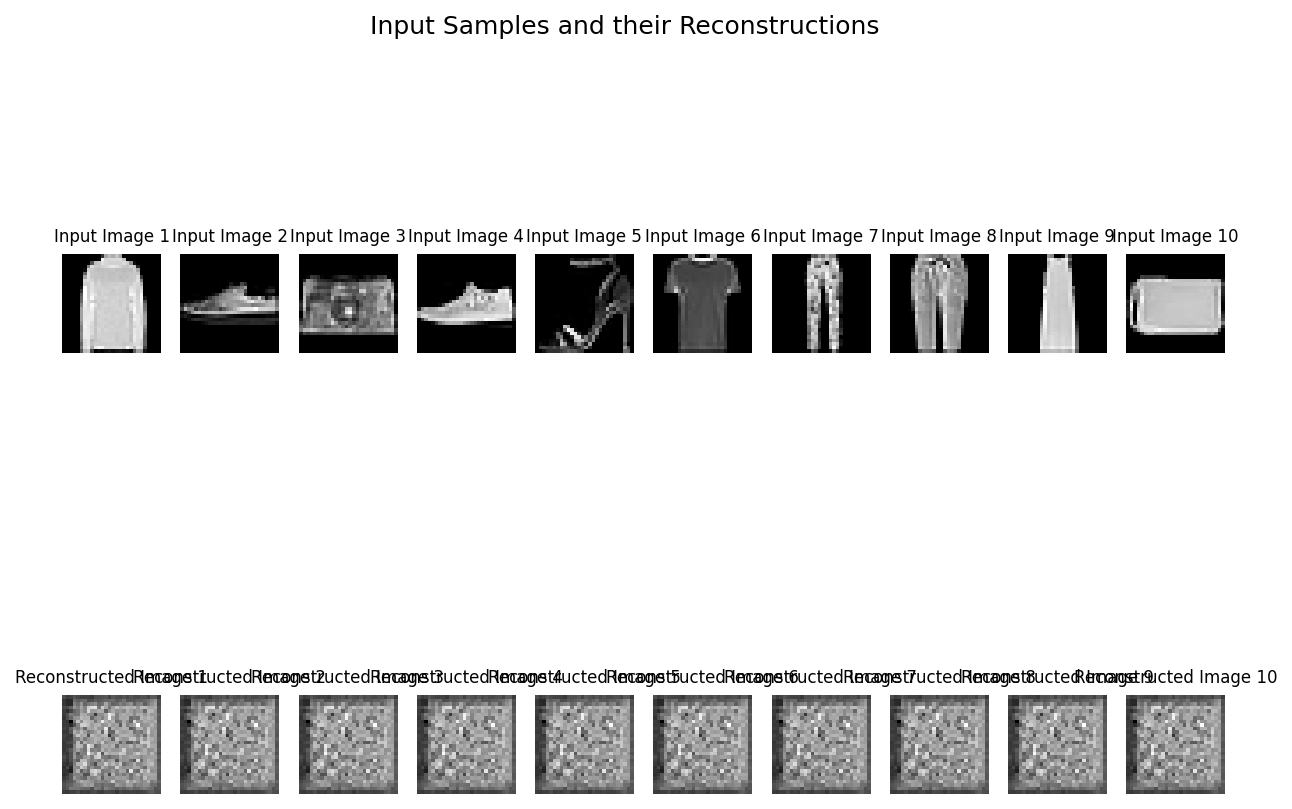

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


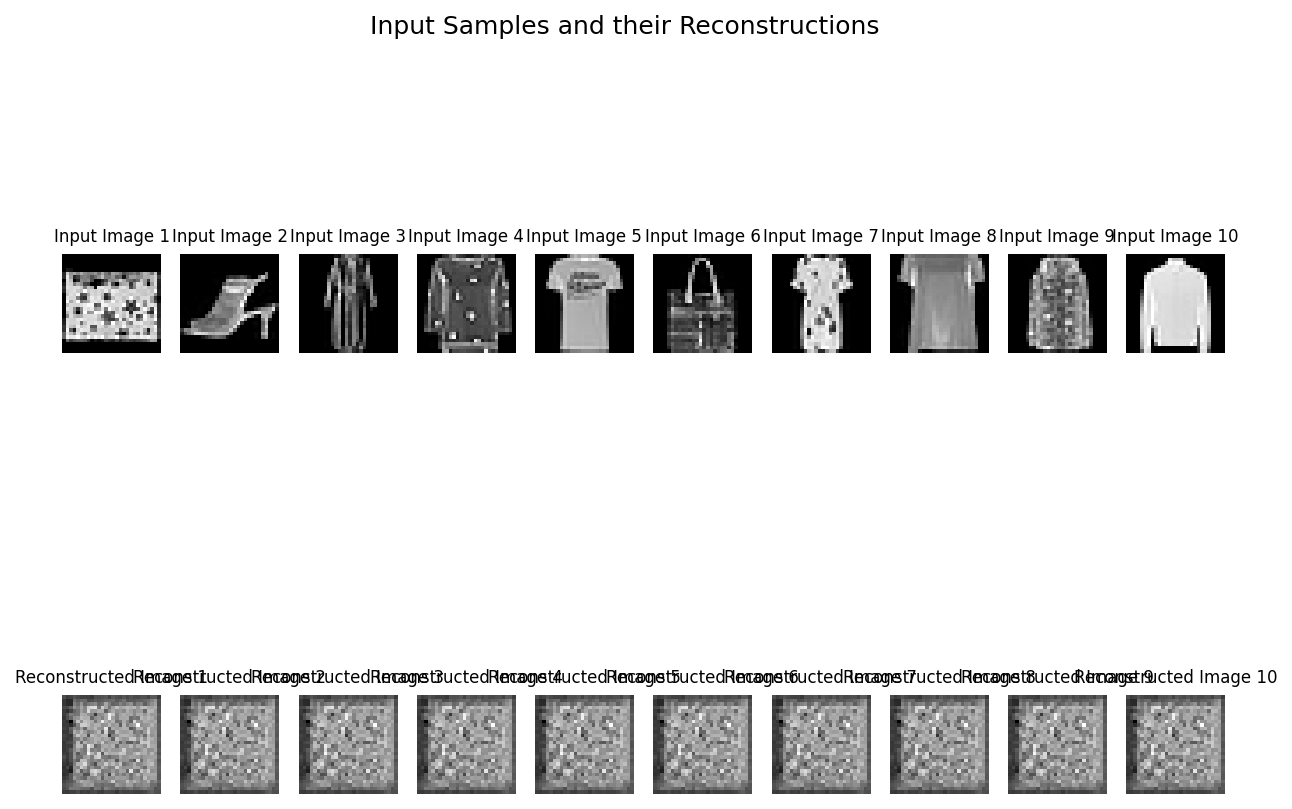

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


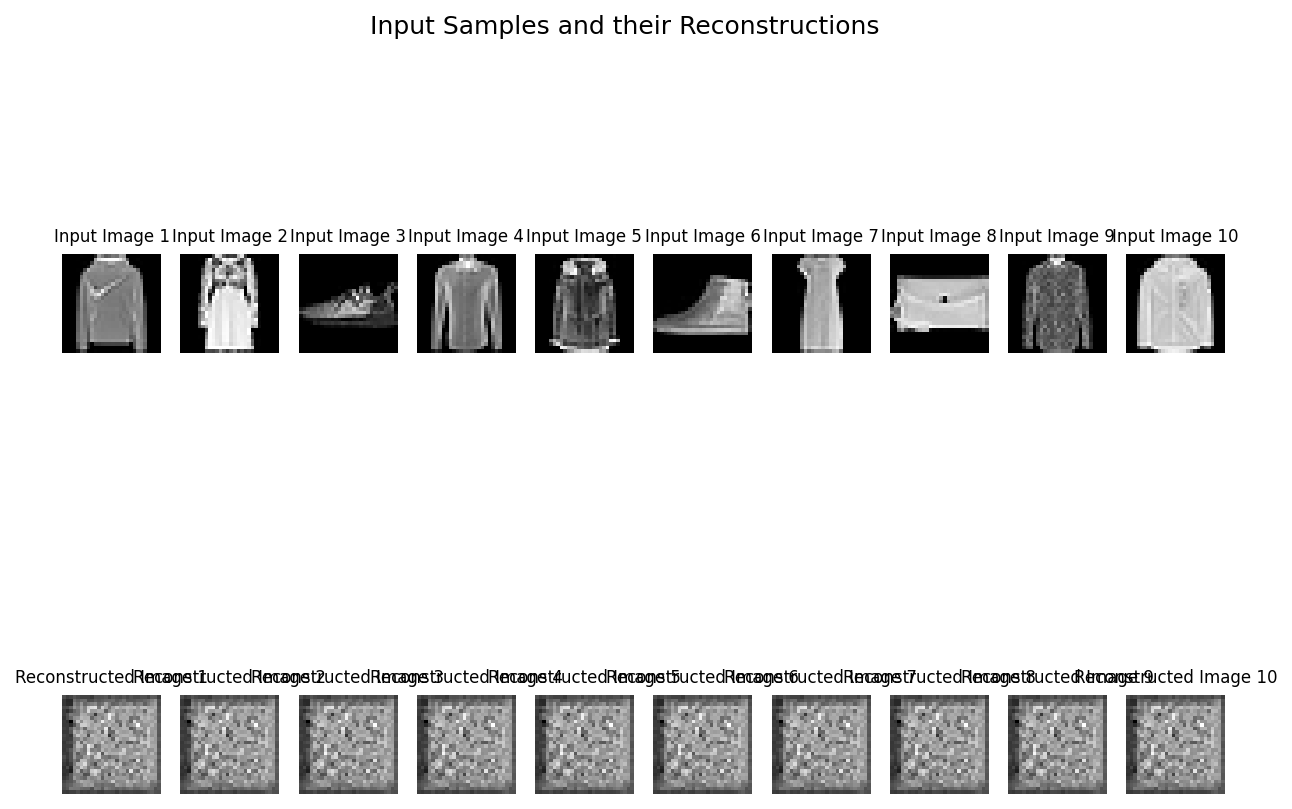

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


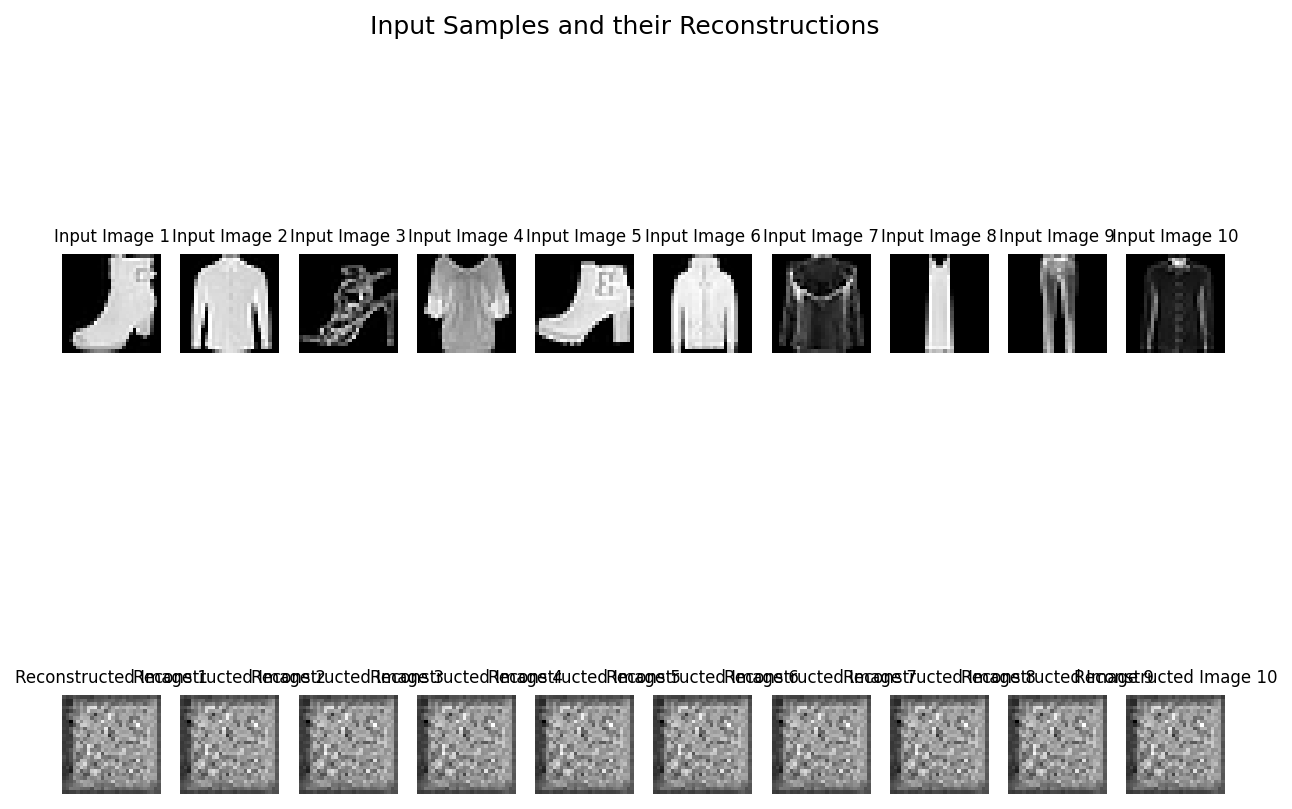

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


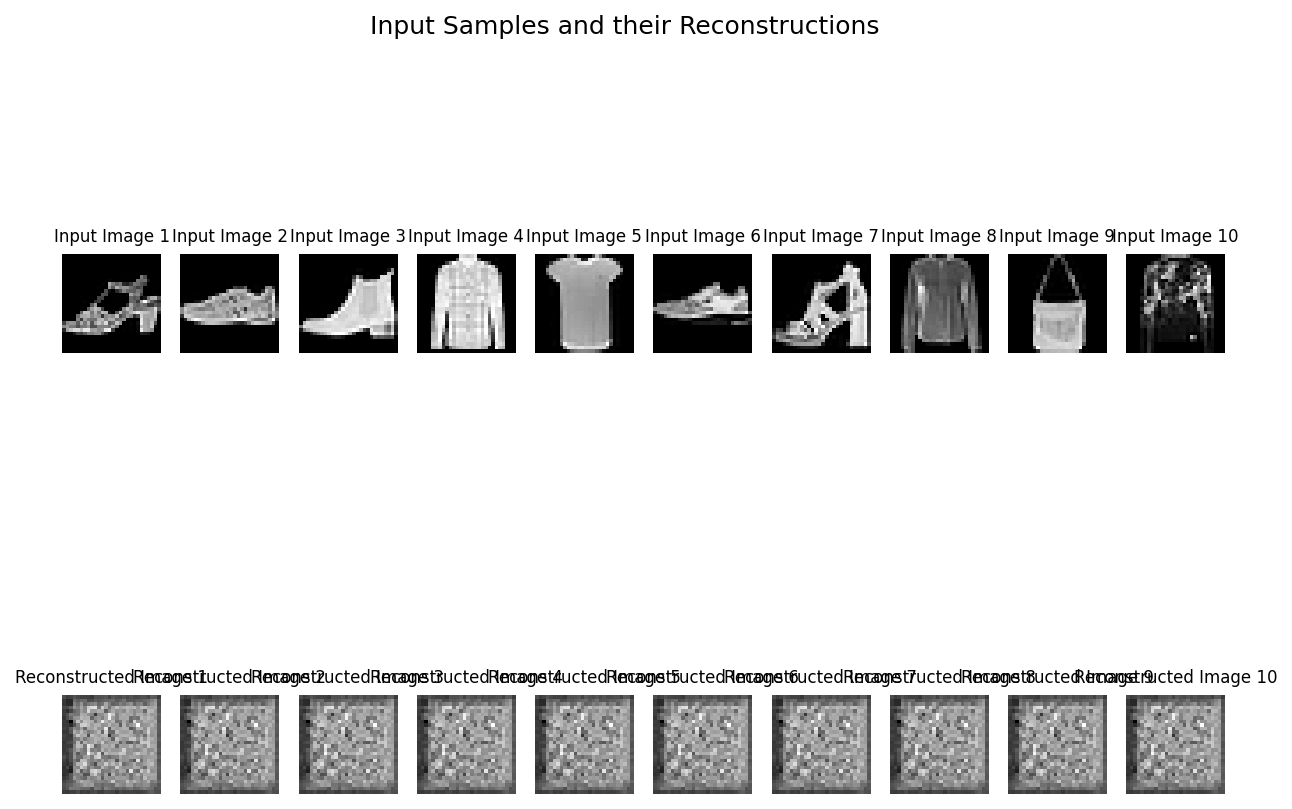

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


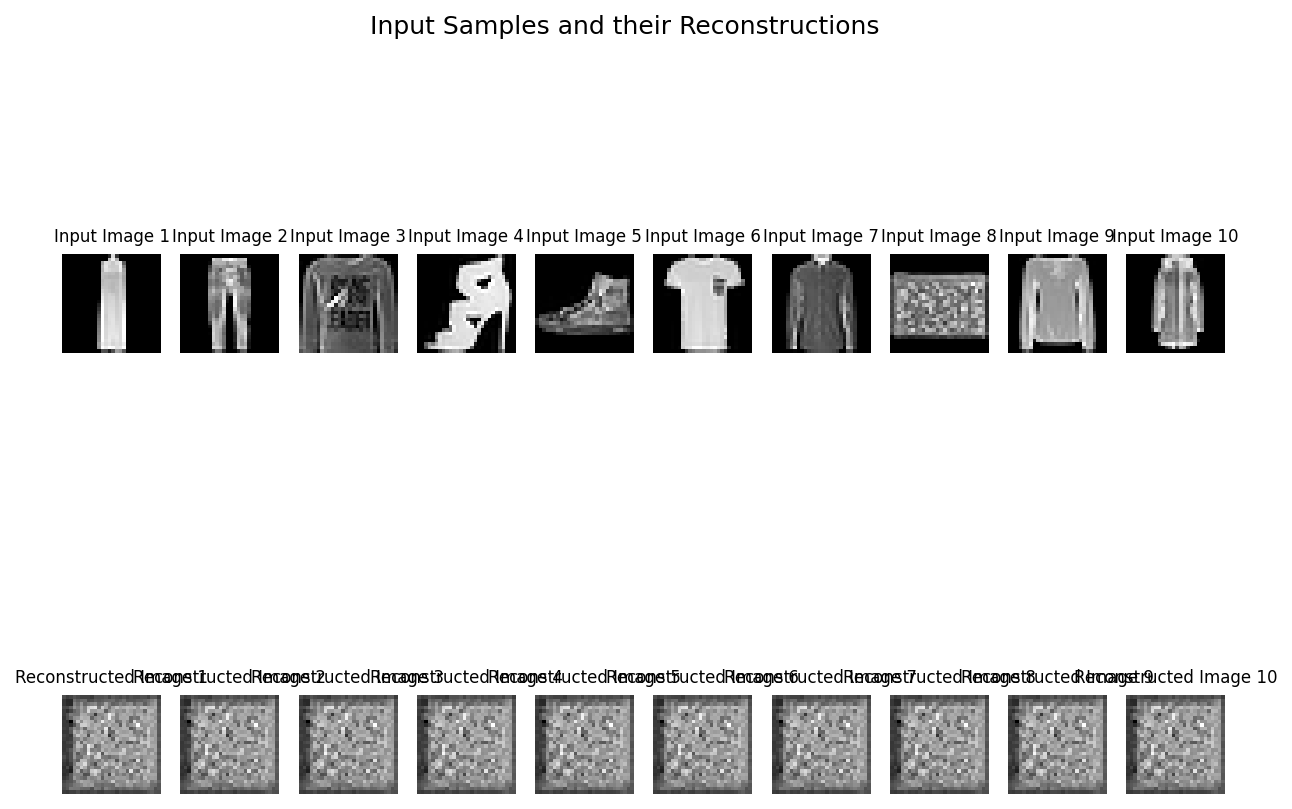

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


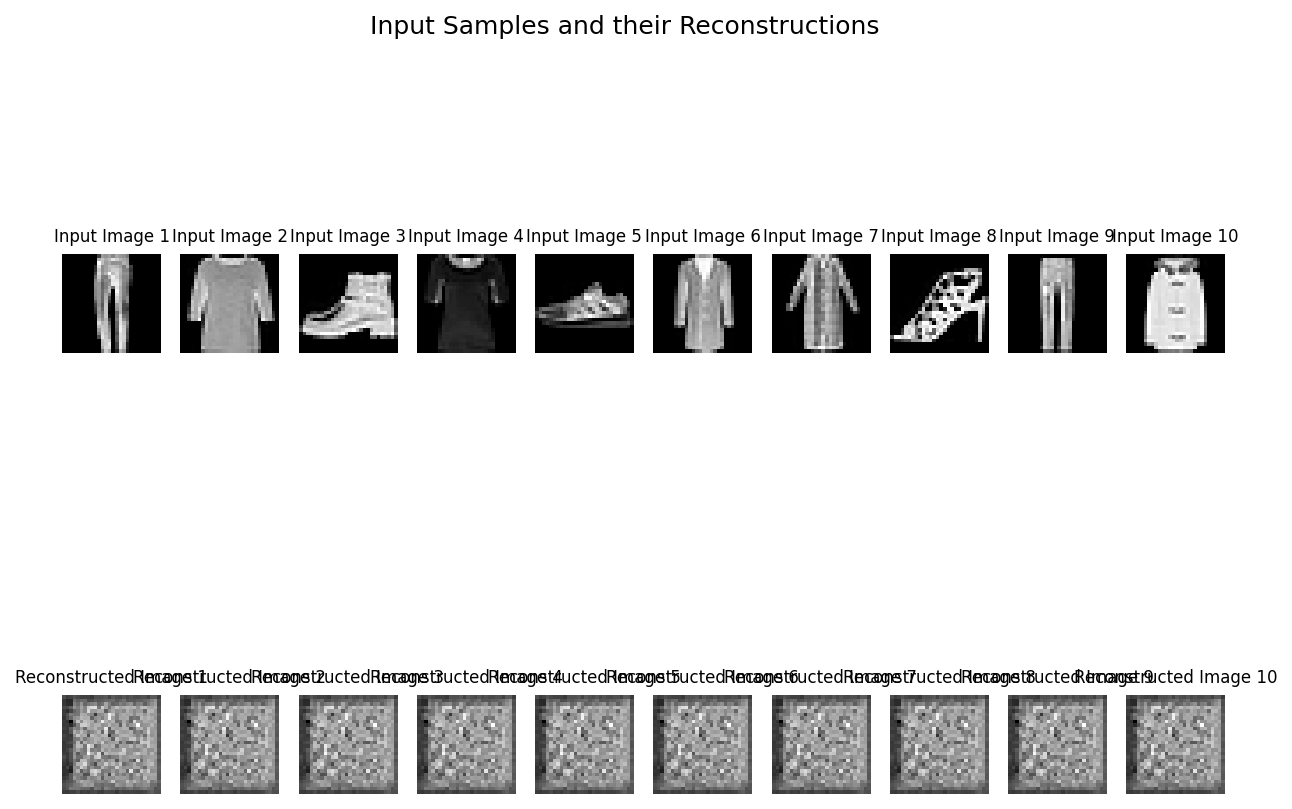

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Epoch 1/3, Loss: 0.9137
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 2

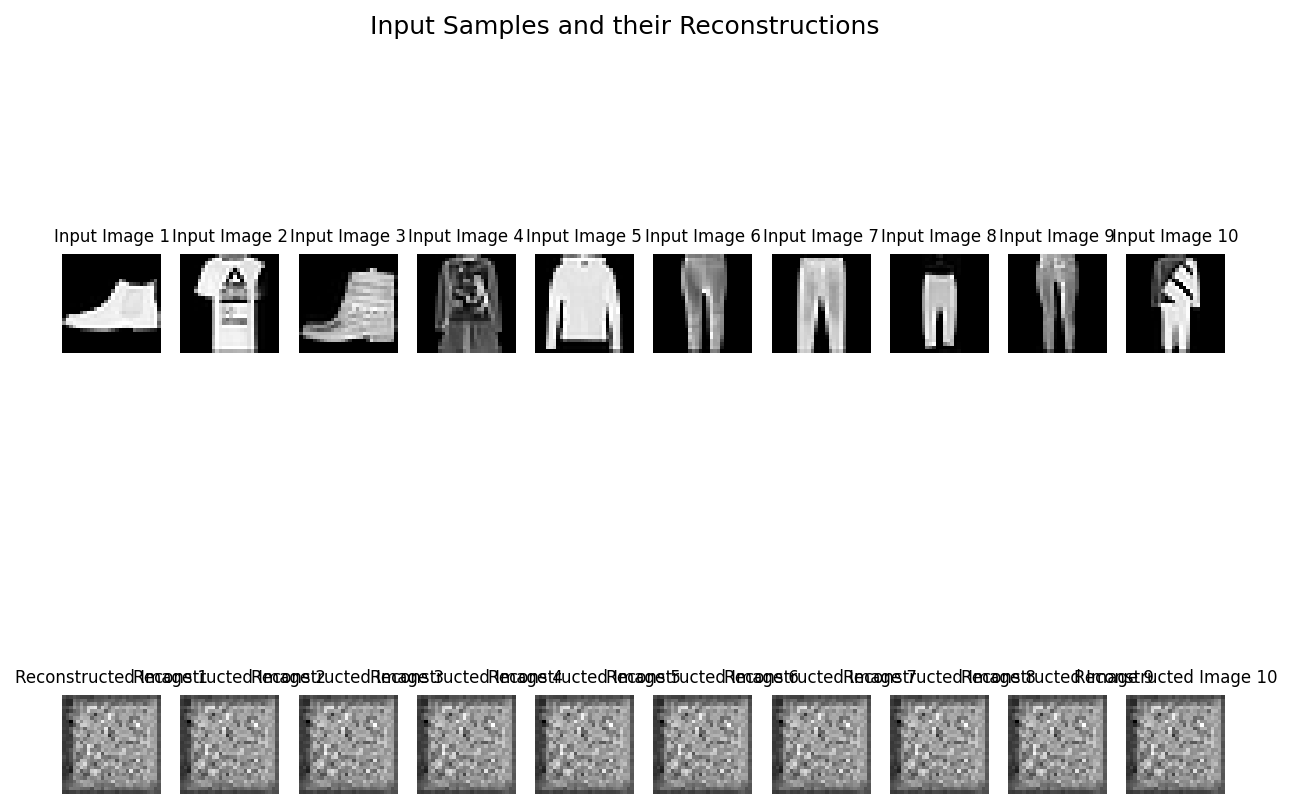

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


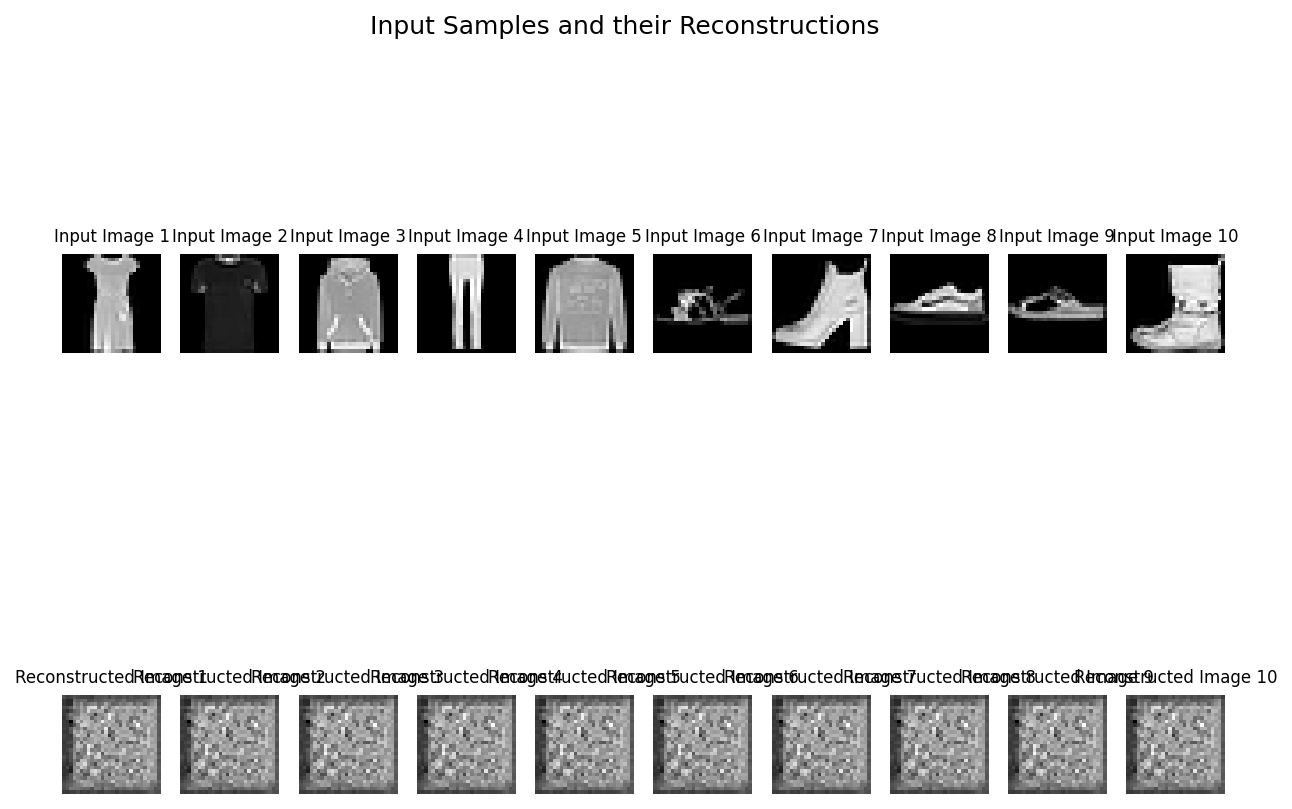

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


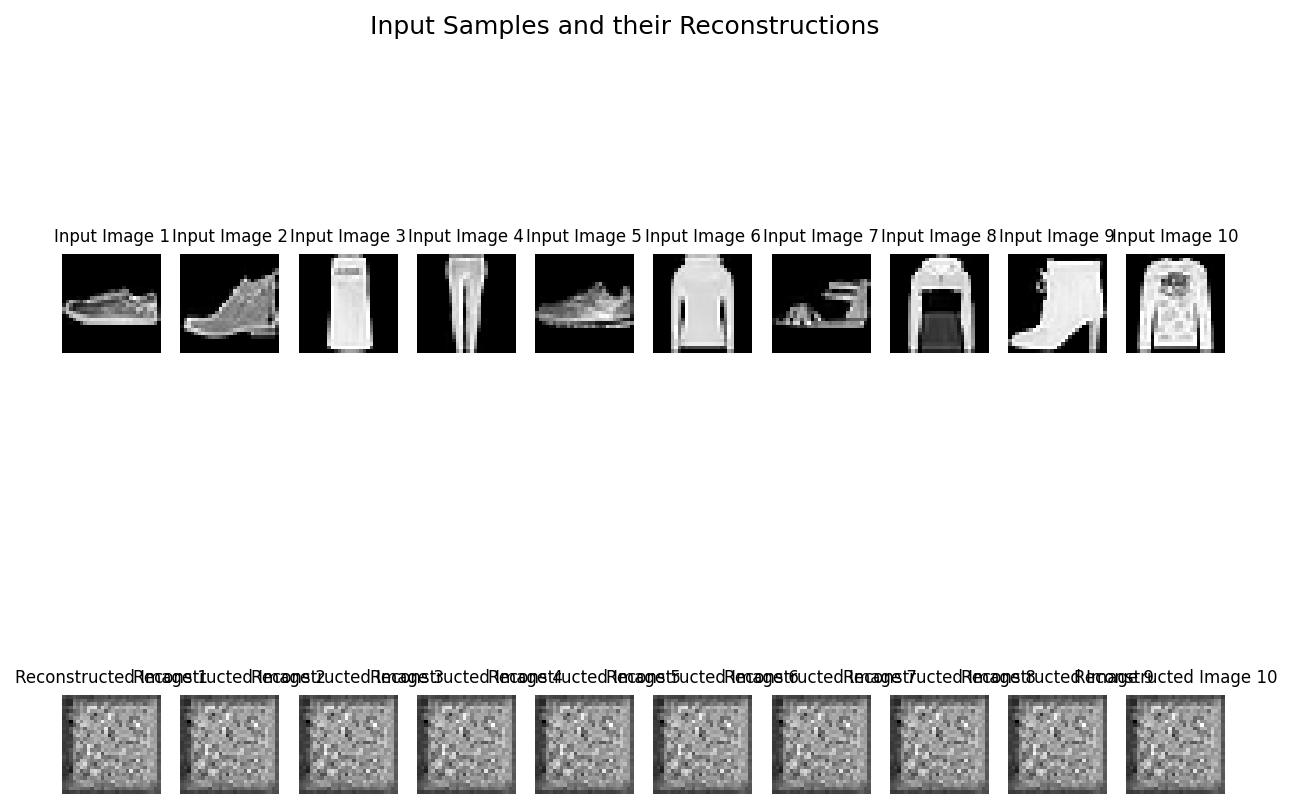

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


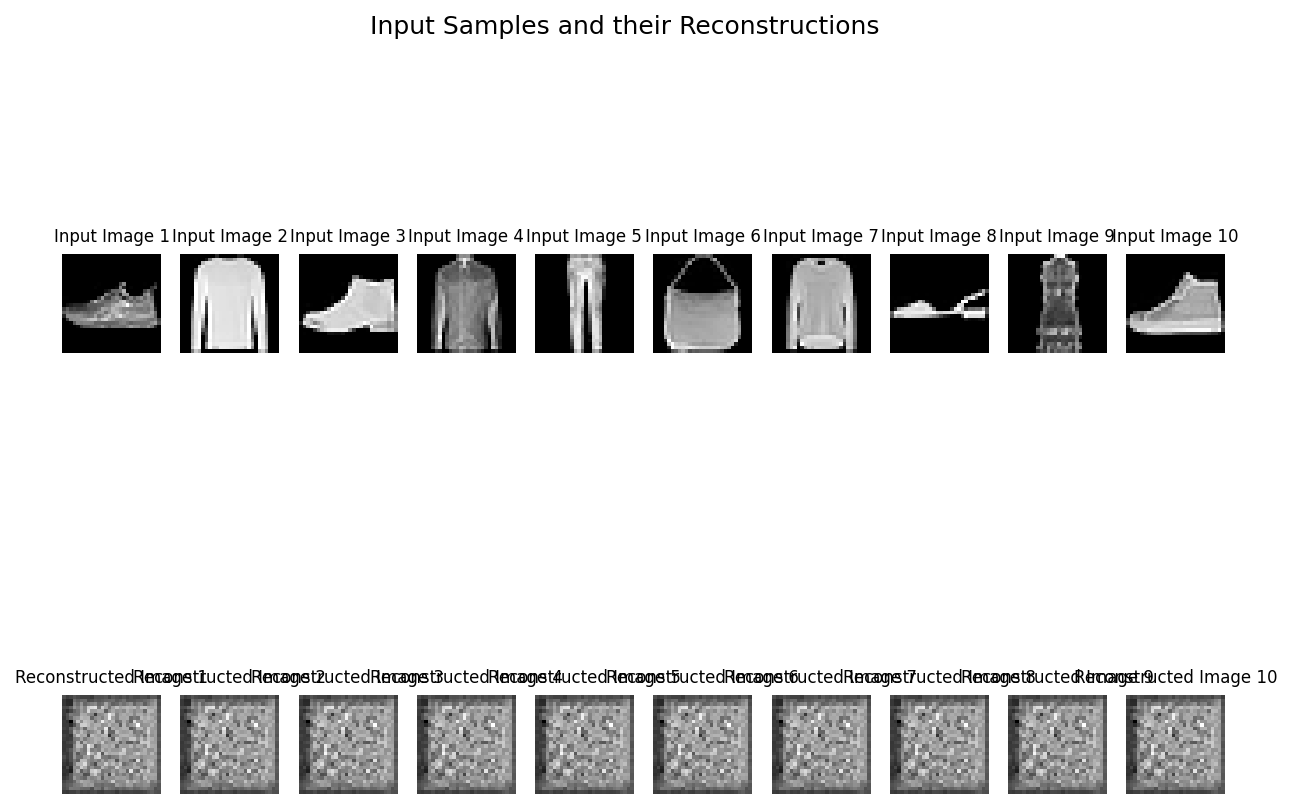

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


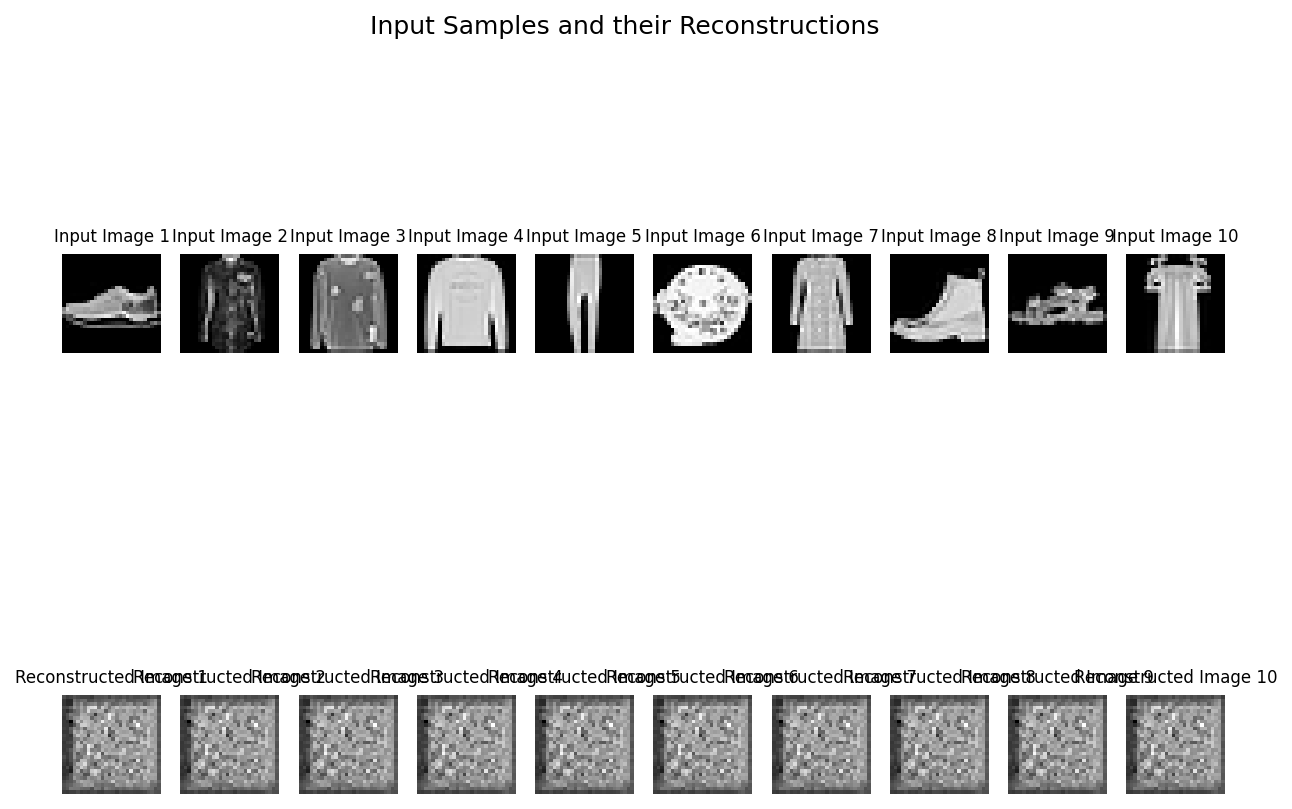

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


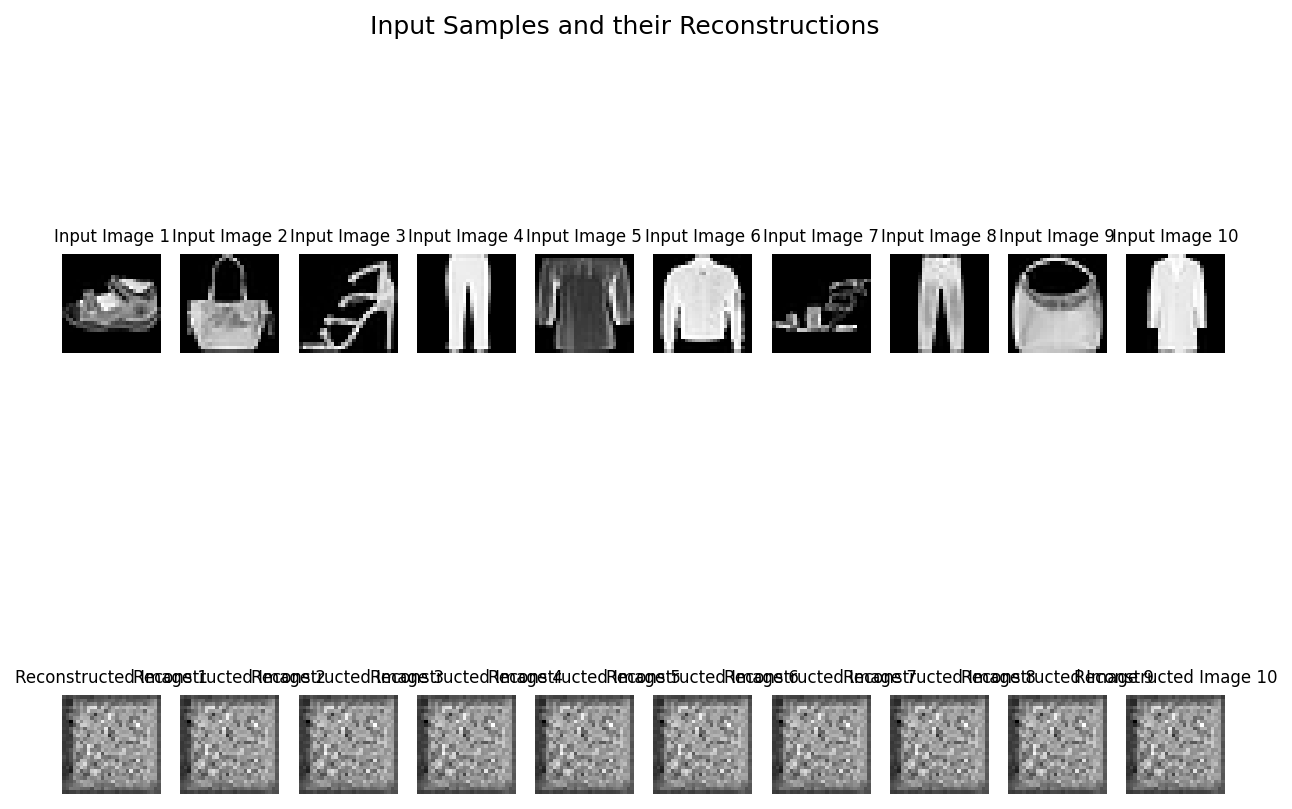

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


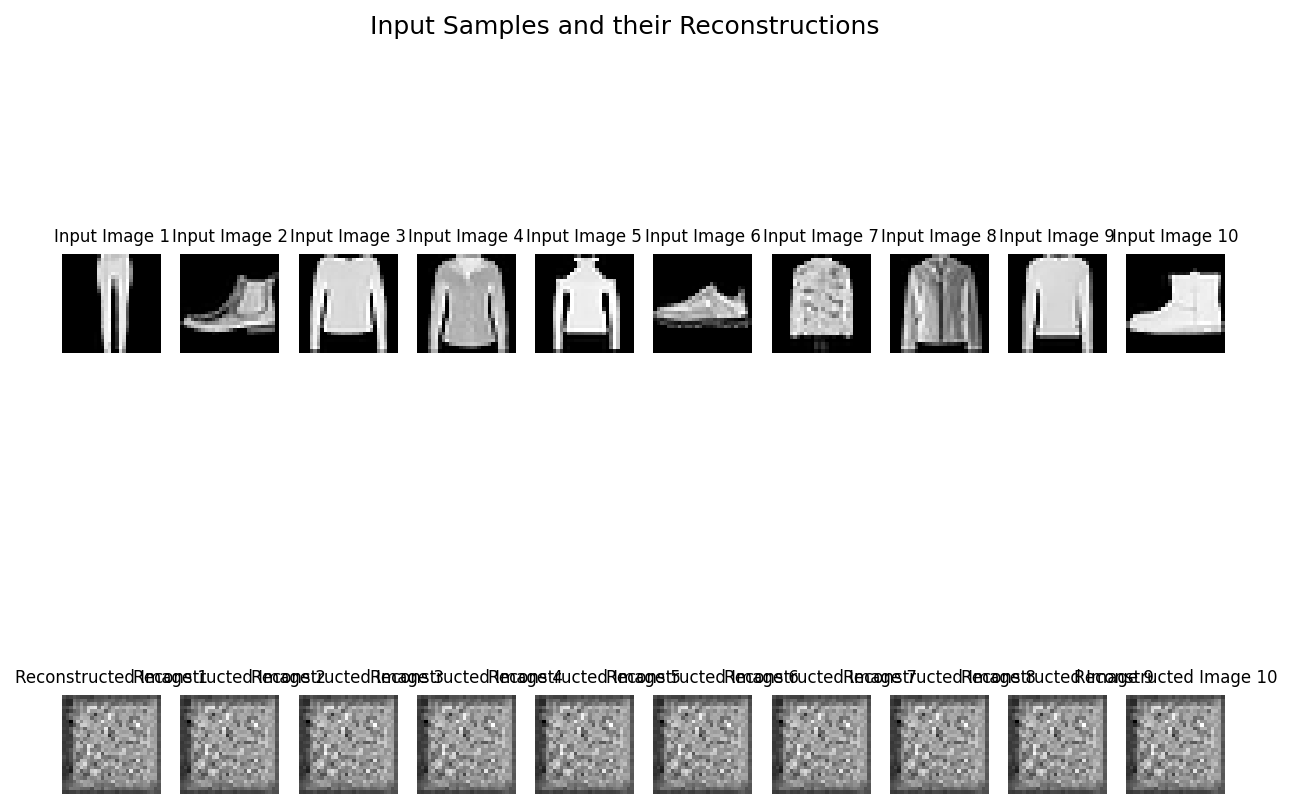

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Epoch 2/3, Loss: 0.9141
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 2

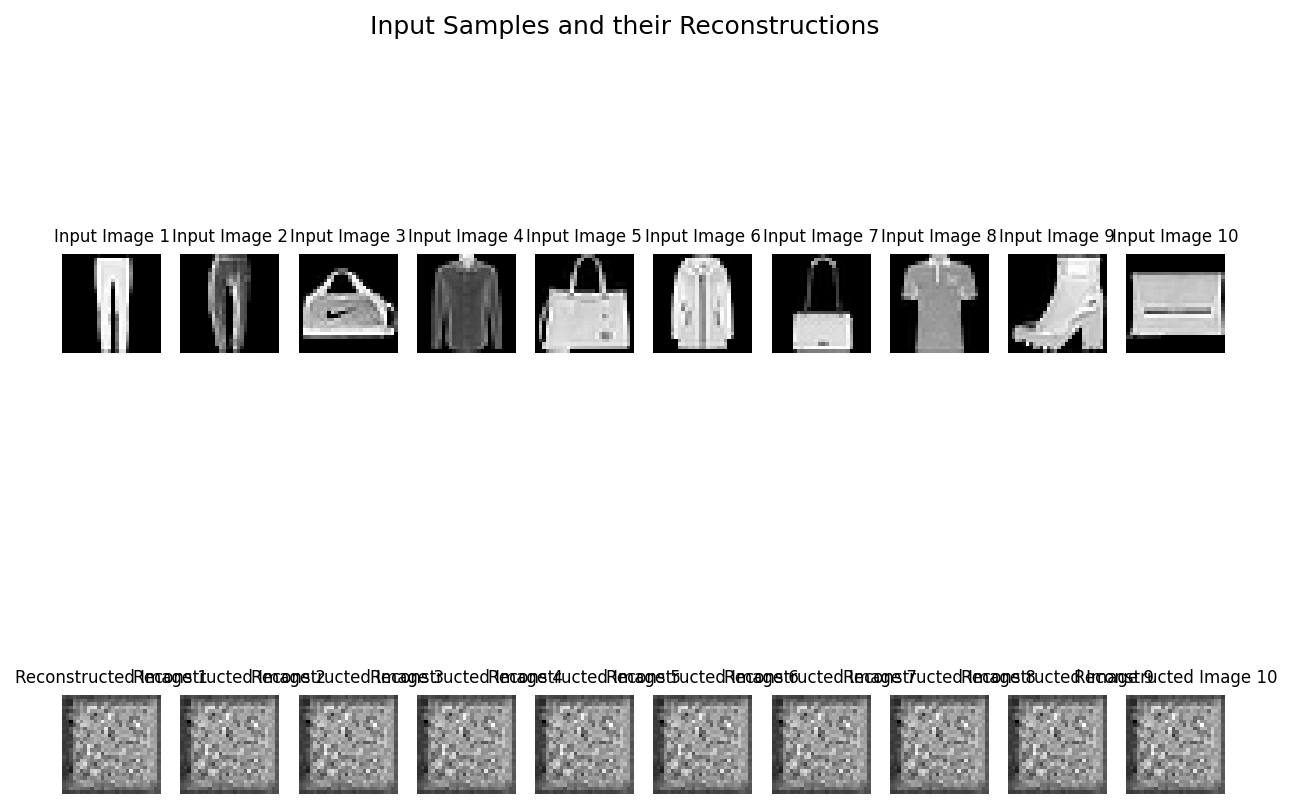

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


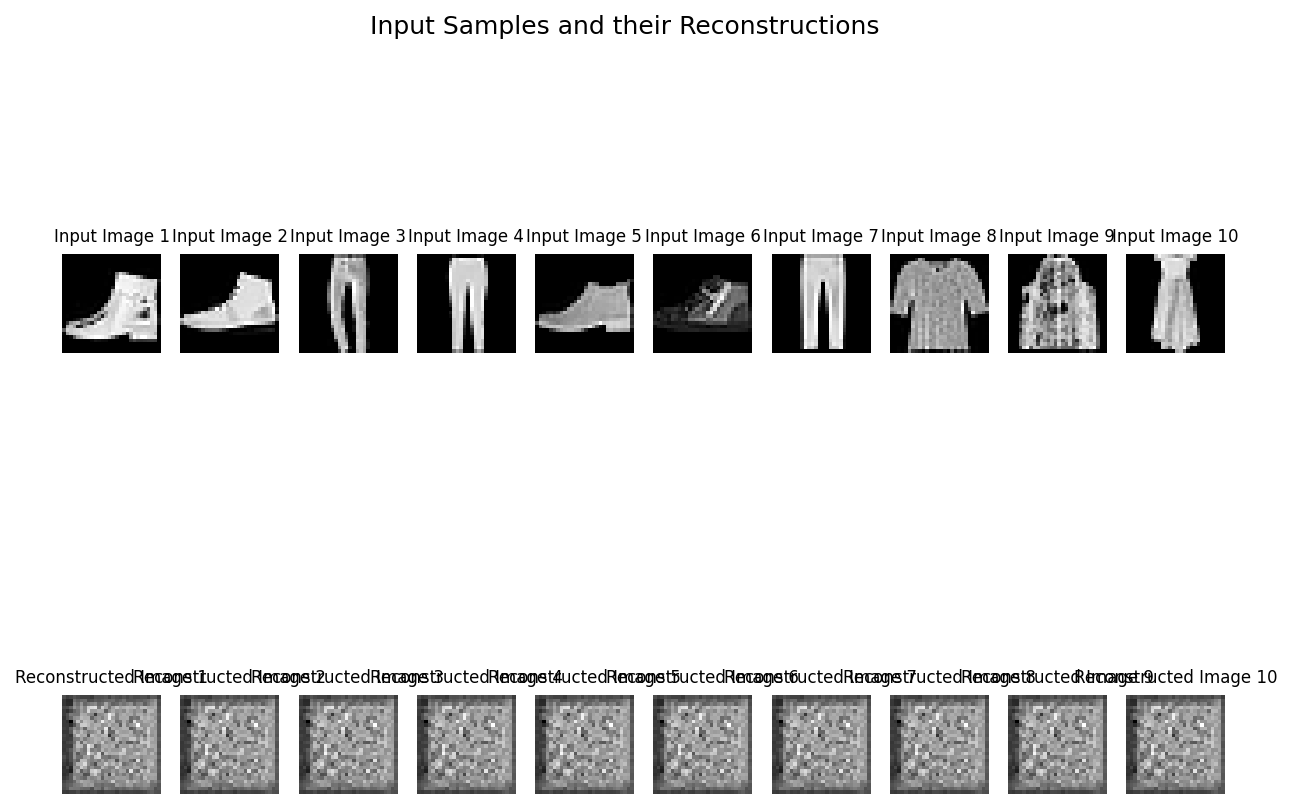

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


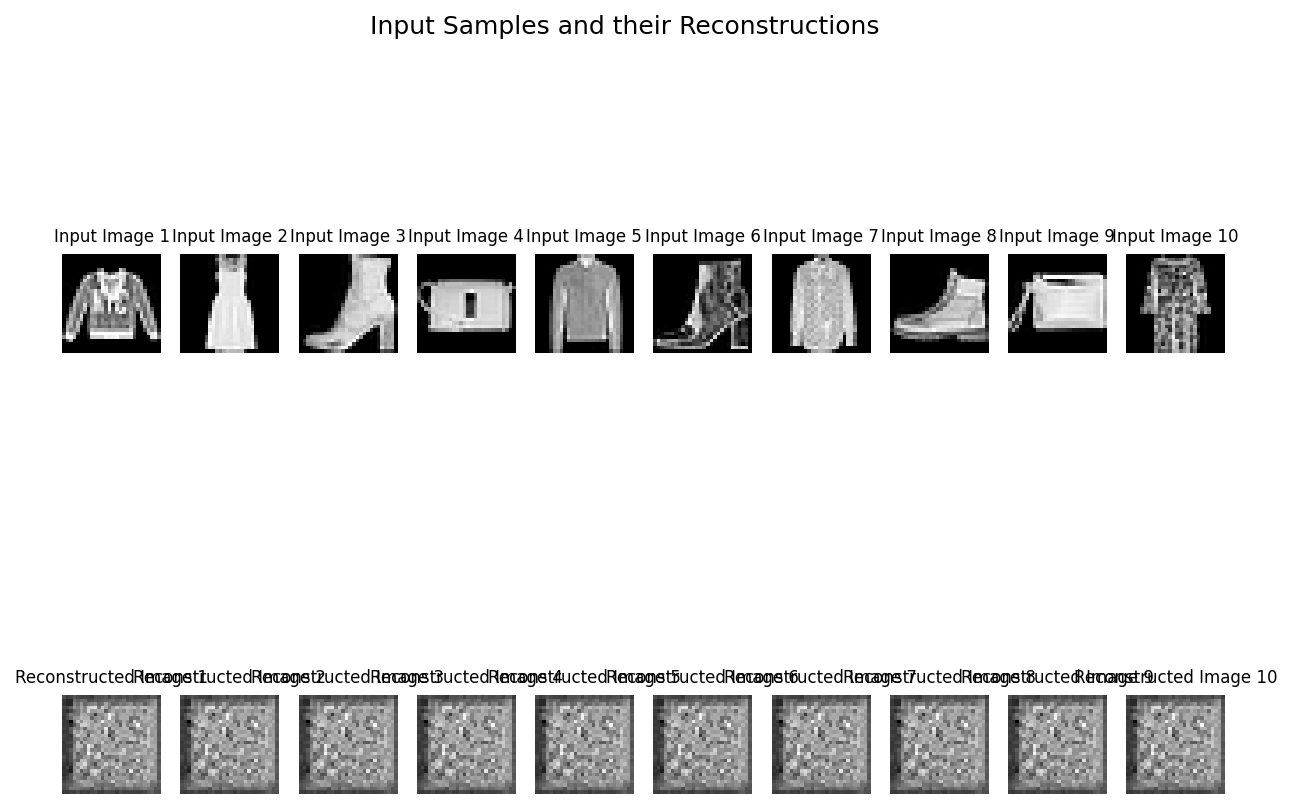

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


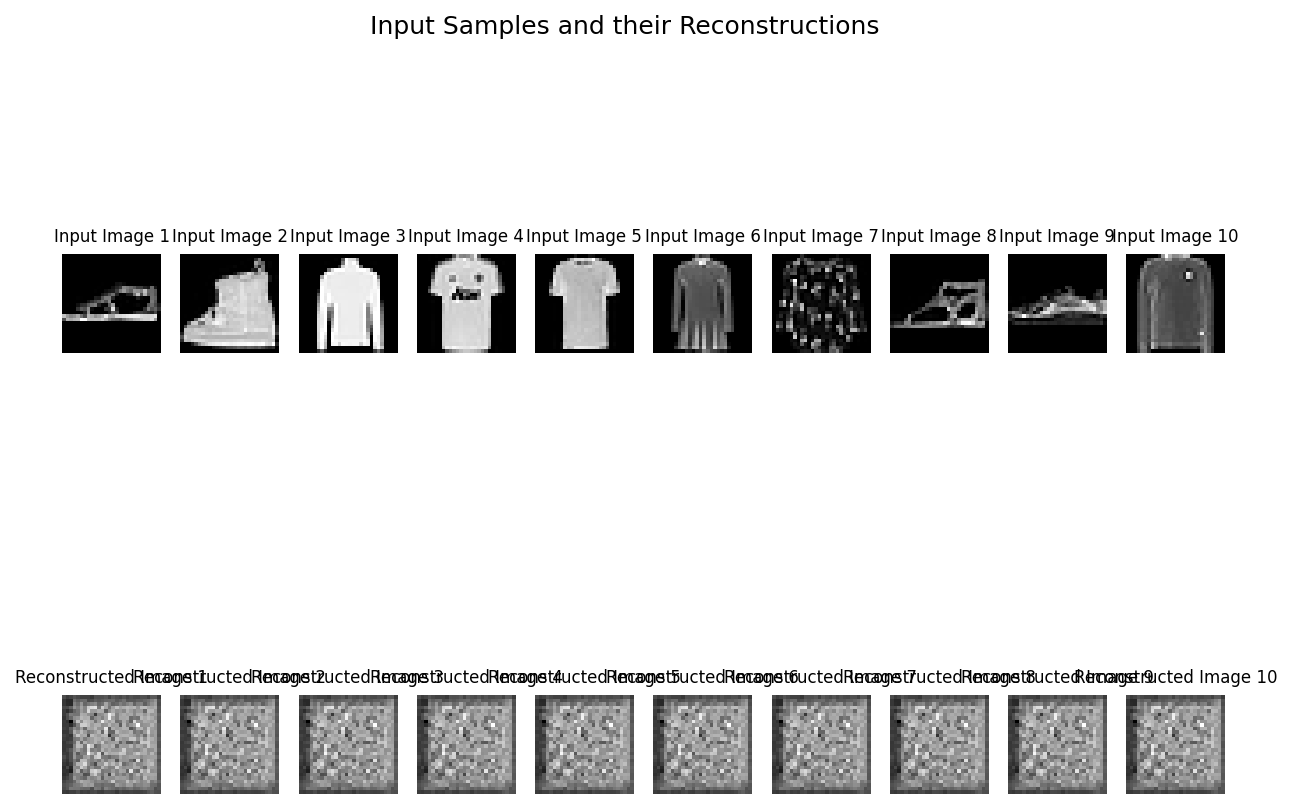

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


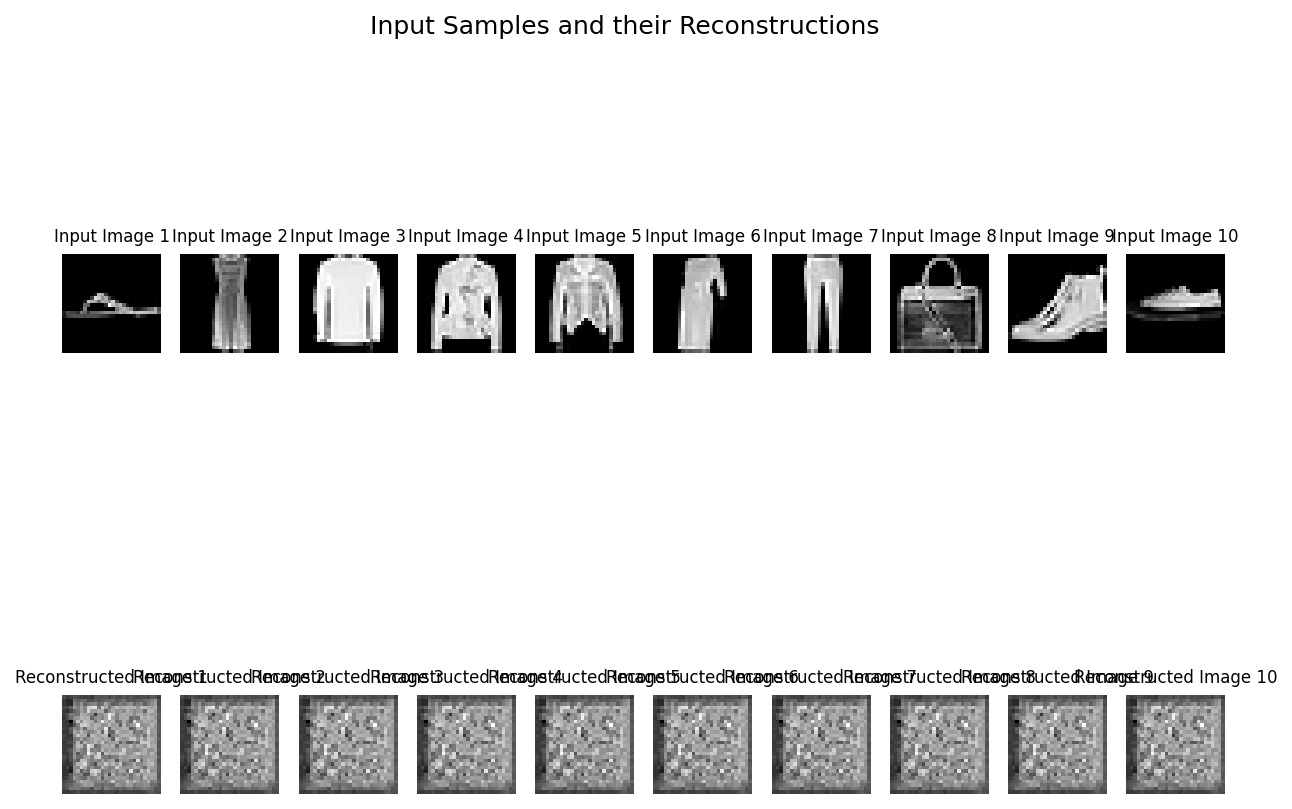

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


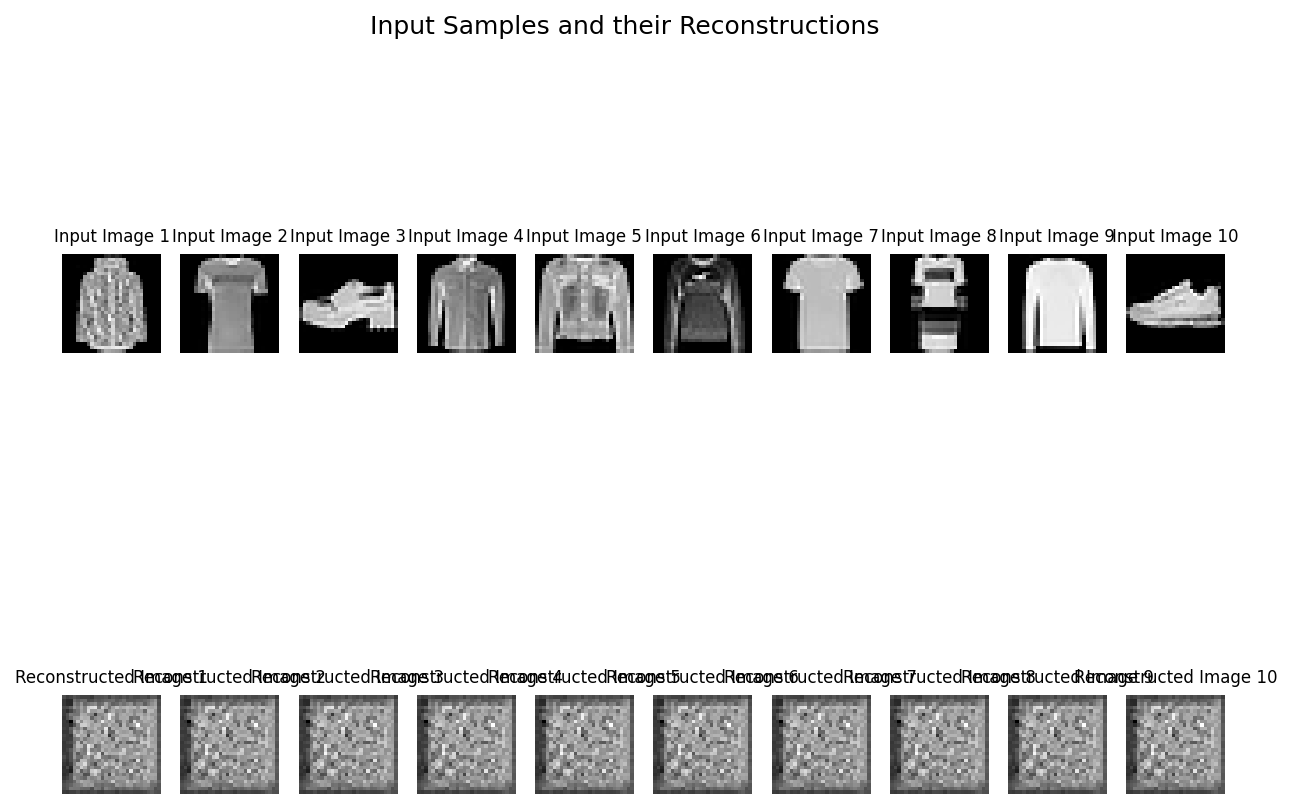

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])


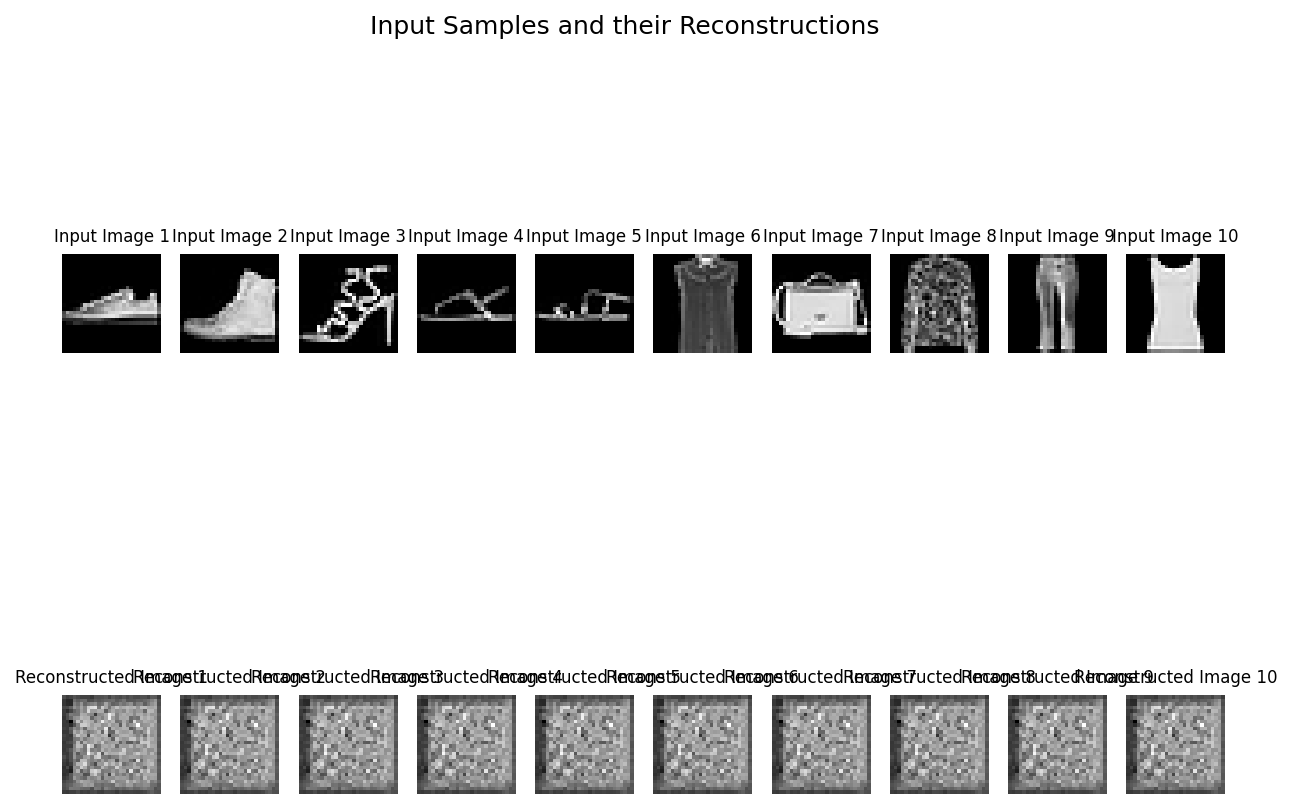

Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28]), Output shape: torch.Size([1, 1, 28, 28])
Epoch 3/3, Loss: 0.9137


In [29]:
# test model
test_losses = []
for epoch in range(EPOCHS):
    test_loss = test(conv_autoencoder, testloader, criterion, device=device)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {test_loss:.4f}')

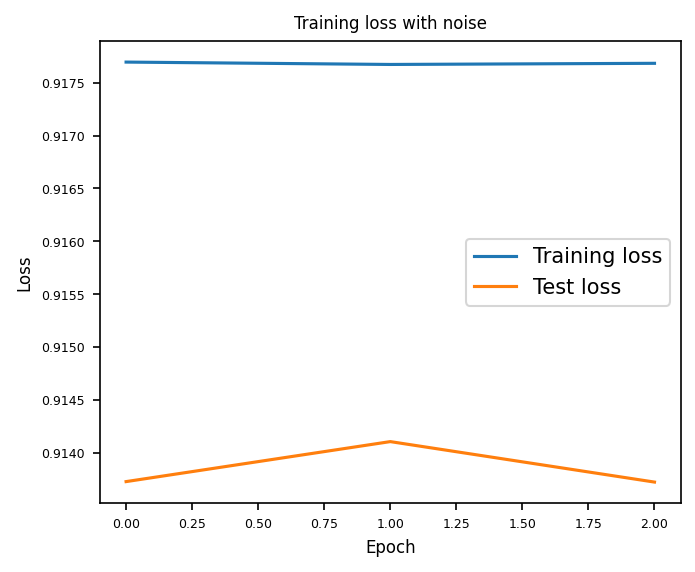

In [30]:
# Plot the loss curve
plot_loss(train_losses, test_losses, label='Training loss with noise', path=RESULTS_DIR+'conv_ae_loss_curve_denoise.png')